In [1]:
import pandas as pd
import datetime
import ta
import plotly.graph_objects as go
from plotly.subplots import make_subplots
import plotly.io as pio
import plotly.express as px
import numpy as np
from scipy import stats
from scipy.stats import linregress, pearsonr
from scipy.stats import f
import seaborn as sns
import matplotlib.pyplot as plt

# 1. Historical Trend of WTI Crude Oil / Henry Hub Natural Gas

In [24]:
wti = pd.read_csv("resources/wti_daily_f.csv")
ng = pd.read_csv("resources/naturalGas_daily_f.csv")


In [25]:
wti_df = wti[['Date', 'Close', 'Volume']].rename(columns={'Close': 'close_wti', 'Volume': 'volume_wti'})
ng_df = ng[['Date', 'Close', 'Volume']].rename(columns={'Close': 'close_ng', 'Volume': 'volume_ng'})


In [26]:
wti_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5030 entries, 0 to 5029
Data columns (total 3 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   Date        5030 non-null   object 
 1   close_wti   5030 non-null   float64
 2   volume_wti  5030 non-null   int64  
dtypes: float64(1), int64(1), object(1)
memory usage: 118.0+ KB


In [27]:
ng_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5031 entries, 0 to 5030
Data columns (total 3 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   Date       5031 non-null   object 
 1   close_ng   5031 non-null   float64
 2   volume_ng  5031 non-null   int64  
dtypes: float64(1), int64(1), object(1)
memory usage: 118.0+ KB


In [28]:
for df in [wti_df, ng_df]:
    df['Date'] = pd.to_datetime(df['Date'])

In [29]:
comm_full = pd.merge(wti_df,ng_df, on='Date', how='outer')
comm_full.head()

Date  close_wti  volume_wti  close_ng  volume_ng
0 2004-12-01  45.490002    146703.0     7.413      32354
1 2004-12-02  43.250000    158715.0     6.811      35709
2 2004-12-03  42.540001    109157.0     6.796      20993
3 2004-12-06  42.980000     82611.0     6.923      23903
4 2004-12-07  41.459999    109069.0     6.621      39556

In [30]:
comm_full.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 5031 entries, 0 to 5030
Data columns (total 5 columns):
 #   Column      Non-Null Count  Dtype         
---  ------      --------------  -----         
 0   Date        5031 non-null   datetime64[ns]
 1   close_wti   5030 non-null   float64       
 2   volume_wti  5030 non-null   float64       
 3   close_ng    5031 non-null   float64       
 4   volume_ng   5031 non-null   int64         
dtypes: datetime64[ns](1), float64(3), int64(1)
memory usage: 235.8 KB


In [31]:
comm_full[comm_full['close_wti'].isna()]

Date  close_wti  volume_wti  close_ng  volume_ng
5030 2023-11-23        NaN         NaN     2.934      59224

In [32]:
comm_full = comm_full.dropna(subset=['close_wti']).reset_index(drop=True)
comm_full.tail()

Date  close_wti  volume_wti  close_ng  volume_ng
5025 2024-11-22  71.239998    408207.0     3.129      95807
5026 2024-11-25  68.940002    380922.0     3.369     108485
5027 2024-11-26  68.769997    292138.0     3.431     222049
5028 2024-11-27  68.720001    227215.0     3.204     214291
5029 2024-11-29  68.000000    291408.0     3.363     163060

In [33]:
comm_full.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5030 entries, 0 to 5029
Data columns (total 5 columns):
 #   Column      Non-Null Count  Dtype         
---  ------      --------------  -----         
 0   Date        5030 non-null   datetime64[ns]
 1   close_wti   5030 non-null   float64       
 2   volume_wti  5030 non-null   float64       
 3   close_ng    5030 non-null   float64       
 4   volume_ng   5030 non-null   int64         
dtypes: datetime64[ns](1), float64(3), int64(1)
memory usage: 196.6 KB


In [34]:
# Correlation between WTI and Henry Hub (starting from Dec 2004 - Nov 2024) 
corr_matrix = comm_full.drop(columns=['Date']).corr()
corr_matrix

close_wti  volume_wti  close_ng  volume_ng
close_wti    1.000000   -0.317230  0.319044  -0.059830
volume_wti  -0.317230    1.000000 -0.430933   0.452627
close_ng     0.319044   -0.430933  1.000000  -0.520225
volume_ng   -0.059830    0.452627 -0.520225   1.000000

In [38]:
def add_trendline(x, y):
    slope, intercept, _, _, _ = linregress(x, y)
    return slope * x + intercept

In [43]:
def plot_comm_vs_factor(comm_value, comm_label,comm_unit,factor_value, factor_label,factor_unit,time_frame, factor_df, comm_df):
  
    fig = go.Figure()


    fig.add_trace(go.Scatter(
        x=comm_df['Date'], 
        y=comm_df[comm_value], 
        mode='lines', 
        name=comm_label
    ))
        

    fig.add_trace(go.Scatter(
        x=comm_df['Date'], 
        y=factor_df[factor_value], 
        mode='lines', 
        name=factor_label, 
        yaxis='y2'
    ))

    
    date_num = comm_df['Date'].map(pd.Timestamp.toordinal)


    slope_comm, intercept_comm, *_ = linregress(date_num, comm_df[comm_value])
    comm_trendline = slope_comm * date_num + intercept_comm
    fig.add_trace(go.Scatter(
        x=comm_df['Date'], 
        y=comm_trendline, 
        mode='lines', 
        name=f'{comm_label} Trendline', 
        line=dict(dash='dash', color='blue')
    ))


    slope_factor, intercept_factor, *_ = linregress(date_num, factor_df[factor_value])
    factor_trendline = slope_factor * date_num + intercept_factor
    fig.add_trace(go.Scatter(
        x=comm_df['Date'], 
        y=factor_trendline, 
        mode='lines', 
        name=f'{factor_label} Trendline', 
        line=dict(dash='dash', color='red'),
        yaxis='y2'
    ))

    fig.update_layout(
        title=f'{comm_label} with {factor_label} ({time_frame})',
        xaxis_title='Date',
        yaxis=dict(
            title=f'{comm_label}({comm_unit})',
            titlefont=dict(color='blue'),
            tickfont=dict(color='blue'),
            showgrid=True,
        ),
        yaxis2=dict(
            title=f'{factor_label}({factor_unit})',
            titlefont=dict(color='red'),
            tickfont=dict(color='red'),
            overlaying='y',
            side='right',
            showgrid=False
        ),
        legend=dict(x=1.1, y=1), 
        template='plotly_white',
    )

    fig.show()

    
    correlation, _ = pearsonr(factor_df[factor_value], comm_df[comm_value])

    print(f"Quick Summary")
    print(f"--------------")
    print(f"The Pearson correlation between {comm_label} and {factor_label} is: {round(correlation, 3)}")
    print(f"The slope of the {comm_label} trendline is: {round(slope_comm, 6)}")
    print(f"The slope of the {factor_label} trendline is: {round(slope_factor, 6)}")

In [75]:
plot_comm_vs_factor(
    comm_value='close_wti', 
    comm_label='WTI Futures Price',
    comm_unit = 'USD/Barrel',
    factor_value='close_ng', 
    factor_label='Henry Hub Futures Price',
    factor_unit = 'USD/MMBtu',
    time_frame = 'From Dec-2004 to Nov-2024',
    factor_df=comm_full, 
    comm_df=comm_full
)

Quick Summary
--------------
The Pearson correlation between WTI Futures Price and Henry Hub Futures Price is: 0.319
The slope of the WTI Futures Price trendline is: -0.00117
The slope of the Henry Hub Futures Price trendline is: -0.000669


# 2. Correlation - CPI v.s. WTI Crude Oil / Henry Hub Natural Gas
---
- **Hypothesis Testing**: Significant correlations across the following periods:  
    - **2.1 Past Decade**: Dec 2014 – Nov 2024  
    - **2.2 COVID-19 Period**: Mar 2020 – May 2023  
    - **2.3 Post-COVID Period**: Jun 2023 – Nov 2024  

In [103]:
def compare_correlation(short_df, long_df):

    if short_df.shape != long_df.shape:
        raise ValueError("The correlation dataframes must have the same shape")
    

    correlation_diff = short_df - long_df


    comparison_matrix = correlation_diff.applymap(
        lambda x: 'High' if x > 0 else 'Low' if x < 0 else 'Same'
    )

    
    for i in comparison_matrix.index:
        comparison_matrix.loc[i, i] = 'Same'
    
    return comparison_matrix

In [104]:
def correlation_change(short_df, long_df):

    if short_df.shape != long_df.shape:
        raise ValueError("The correlation dataframes must have the same shape")
    

    percentage_change = ((short_df - long_df) / long_df.abs()) * 100
    

    for i in percentage_change.index:
        percentage_change.loc[i, i] = 0.0
    
    return percentage_change

In [105]:
def corr_statsig(correlations, n, alpha=0.05):


    for key, r in correlations.items():

        t_stat = r * np.sqrt(n - 2) / np.sqrt(1 - r**2)
        df = n - 2 
        p_value = 2 * stats.t.sf(np.abs(t_stat), df)
        

        is_significant = p_value < alpha
        

        print(f"{key}:")
        print(f"  Correlation (r): {r:.4f}")
        print(f"  t-statistic: {t_stat:.4f}")
        print(f"  p-value: {p_value:.4f}")
        print(f"  Significant: {'Yes' if is_significant else 'No'}")
        print("-" * 50)

In [50]:
cpi_df = pd.read_csv("outputs/cpi_2014Dec_2024Nov.csv")
cpi_df.head()

Date  CPI_all_items  CPI_excl_food_energy  CPI_Energy  \
0  2014-12-01        0.65312               1.62242   -11.06770   
1  2015-01-01       -0.22993               1.63163   -20.13821   
2  2015-02-01       -0.08703               1.68808   -18.76723   
3  2015-03-01       -0.02203               1.74538   -17.68436   
4  2015-04-01       -0.10403               1.80283   -18.52488   

   CPI_Energy_Commo  CPI_Energy_Ser      PCE  
0         -20.82224         3.71750  0.73226  
1         -34.59511         1.66763  0.04140  
2         -31.93502         0.81750  0.17070  
3         -28.07911        -2.93954  0.19935  
4         -30.25245        -1.26697  0.11032

In [61]:
cpi_df['Date'] = pd.to_datetime(cpi_df['Date'])

In [62]:
cpi_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 120 entries, 0 to 119
Data columns (total 7 columns):
 #   Column                Non-Null Count  Dtype         
---  ------                --------------  -----         
 0   Date                  120 non-null    datetime64[ns]
 1   CPI_all_items         120 non-null    float64       
 2   CPI_excl_food_energy  120 non-null    float64       
 3   CPI_Energy            120 non-null    float64       
 4   CPI_Energy_Commo      120 non-null    float64       
 5   CPI_Energy_Ser        120 non-null    float64       
 6   PCE                   120 non-null    float64       
dtypes: datetime64[ns](1), float64(6)
memory usage: 6.7 KB


In [70]:
csi_df = pd.read_csv("outputs/csi_2014Dec_2024Nov.csv")
csi_df.head()

observation_date       CSI
0       2014-12-01  13.45455
1       2015-01-01  20.81281
2       2015-02-01  16.91176
3       2015-03-01  16.25000
4       2015-04-01  14.03092

## 2.1 Past Decade: December 2014 – November 2024
--- 
- hypothesis test (Pearson correlation)
- correlation differences

In [52]:
comm_decade = comm_full[(comm_full['Date'] >= '2014-12-01')&
                                  (comm_full['Date'] <= '2024-11-01')].reset_index(drop=True)

comm_decade.head()

Date  close_wti  volume_wti  close_ng  volume_ng
0 2014-12-01  69.000000    504122.0     4.007     181558
1 2014-12-02  66.879997    360300.0     3.874     144382
2 2014-12-03  67.379997    293483.0     3.805     131446
3 2014-12-04  66.809998    237011.0     3.649     143648
4 2014-12-05  65.839996    276529.0     3.802     162625

In [54]:
comm_decade['YearMonth'] = comm_decade['Date'].dt.to_period('M')
comm_decade.head()

Date  close_wti  volume_wti  close_ng  volume_ng YearMonth
0 2014-12-01  69.000000    504122.0     4.007     181558   2014-12
1 2014-12-02  66.879997    360300.0     3.874     144382   2014-12
2 2014-12-03  67.379997    293483.0     3.805     131446   2014-12
3 2014-12-04  66.809998    237011.0     3.649     143648   2014-12
4 2014-12-05  65.839996    276529.0     3.802     162625   2014-12

In [57]:
monthly_comm_decade = comm_decade.groupby('YearMonth').agg(
    avg_price_wti=('close_wti', 'mean'),
    total_volume_wti=('volume_wti', 'sum'),
    avg_price_ng=('close_ng', 'mean'),
    total_volume_ng=('volume_ng', 'sum')
).reset_index()

monthly_comm_decade.head()

YearMonth  avg_price_wti  total_volume_wti  avg_price_ng  total_volume_ng
0   2014-12      59.289545         6919717.0      3.508591          2698345
1   2015-01      47.325500         7699363.0      2.929350          2754920
2   2015-02      50.724736         8798437.0      2.754947          2600280
3   2015-03      47.854091         8046270.0      2.746909          2450063
4   2015-04      54.628096         7959153.0      2.591333          2509146

In [71]:
monthly_full_decade = pd.concat([cpi_df, csi_df, monthly_comm_decade,], axis=1)
monthly_full_decade.head()

Date  CPI_all_items  CPI_excl_food_energy  CPI_Energy  \
0 2014-12-01        0.65312               1.62242   -11.06770   
1 2015-01-01       -0.22993               1.63163   -20.13821   
2 2015-02-01       -0.08703               1.68808   -18.76723   
3 2015-03-01       -0.02203               1.74538   -17.68436   
4 2015-04-01       -0.10403               1.80283   -18.52488   

   CPI_Energy_Commo  CPI_Energy_Ser      PCE observation_date       CSI  \
0         -20.82224         3.71750  0.73226       2014-12-01  13.45455   
1         -34.59511         1.66763  0.04140       2015-01-01  20.81281   
2         -31.93502         0.81750  0.17070       2015-02-01  16.91176   
3         -28.07911        -2.93954  0.19935       2015-03-01  16.25000   
4         -30.25245        -1.26697  0.11032       2015-04-01  14.03092   

  YearMonth  avg_price_wti  total_volume_wti  avg_price_ng  total_volume_ng  
0   2014-12      59.289545         6919717.0      3.508591          2698345  
1   2015-01      47.325500         7699363.0      2.929350          2754920  
2   2015-02      50.724736         8798437.0      2.754947          2600280  
3   2015-03      47.854091         8046270.0      2.746909          2450063  
4   2015-04      54.628096         7959153.0      2.591333          2509146

In [72]:
monthly_full_decade = monthly_full_decade.drop(columns=['observation_date'])
monthly_full_decade.head()

Date  CPI_all_items  CPI_excl_food_energy  CPI_Energy  \
0 2014-12-01        0.65312               1.62242   -11.06770   
1 2015-01-01       -0.22993               1.63163   -20.13821   
2 2015-02-01       -0.08703               1.68808   -18.76723   
3 2015-03-01       -0.02203               1.74538   -17.68436   
4 2015-04-01       -0.10403               1.80283   -18.52488   

   CPI_Energy_Commo  CPI_Energy_Ser      PCE       CSI YearMonth  \
0         -20.82224         3.71750  0.73226  13.45455   2014-12   
1         -34.59511         1.66763  0.04140  20.81281   2015-01   
2         -31.93502         0.81750  0.17070  16.91176   2015-02   
3         -28.07911        -2.93954  0.19935  16.25000   2015-03   
4         -30.25245        -1.26697  0.11032  14.03092   2015-04   

   avg_price_wti  total_volume_wti  avg_price_ng  total_volume_ng  
0      59.289545         6919717.0      3.508591          2698345  
1      47.325500         7699363.0      2.929350          2754920  
2      50.724736         8798437.0      2.754947          2600280  
3      47.854091         8046270.0      2.746909          2450063  
4      54.628096         7959153.0      2.591333          2509146

In [92]:
corr_decade = monthly_full_decade.drop(columns=['Date','YearMonth']).corr()
corr_decade

CPI_all_items  CPI_excl_food_energy  CPI_Energy  \
CPI_all_items              1.000000              0.923660    0.834369   
CPI_excl_food_energy       0.923660              1.000000    0.581893   
CPI_Energy                 0.834369              0.581893    1.000000   
CPI_Energy_Commo           0.765310              0.502767    0.987640   
CPI_Energy_Ser             0.886510              0.767040    0.760350   
PCE                        0.994797              0.932039    0.809396   
CSI                       -0.364491             -0.205439   -0.340937   
avg_price_wti              0.837872              0.827333    0.651666   
total_volume_wti          -0.354758             -0.505719   -0.025593   
avg_price_ng               0.771960              0.657092    0.691382   
total_volume_ng           -0.264532             -0.322235   -0.129933   

                      CPI_Energy_Commo  CPI_Energy_Ser       PCE       CSI  \
CPI_all_items                 0.765310        0.886510  0.994797 -0.364491   
CPI_excl_food_energy          0.502767        0.767040  0.932039 -0.205439   
CPI_Energy                    0.987640        0.760350  0.809396 -0.340937   
CPI_Energy_Commo              1.000000        0.657860  0.739968 -0.267183   
CPI_Energy_Ser                0.657860        1.000000  0.881798 -0.479249   
PCE                           0.739968        0.881798  1.000000 -0.347591   
CSI                          -0.267183       -0.479249 -0.347591  1.000000   
avg_price_wti                 0.600045        0.669358  0.838897 -0.090956   
total_volume_wti              0.031912       -0.329050 -0.385371  0.000234   
avg_price_ng                  0.614197        0.820383  0.757738 -0.481027   
total_volume_ng              -0.102336       -0.273575 -0.282583 -0.002356   

                      avg_price_wti  total_volume_wti  avg_price_ng  \
CPI_all_items              0.837872         -0.354758      0.771960   
CPI_excl_food_energy       0.827333         -0.505719      0.657092   
CPI_Energy                 0.651666         -0.025593      0.691382   
CPI_Energy_Commo           0.600045          0.031912      0.614197   
CPI_Energy_Ser             0.669358         -0.329050      0.820383   
PCE                        0.838897         -0.385371      0.757738   
CSI                       -0.090956          0.000234     -0.481027   
avg_price_wti              1.000000         -0.462858      0.625353   
total_volume_wti          -0.462858          1.000000     -0.246431   
avg_price_ng               0.625353         -0.246431      1.000000   
total_volume_ng           -0.243117          0.389619     -0.285655   

                      total_volume_ng  
CPI_all_items               -0.264532  
CPI_excl_food_energy        -0.322235  
CPI_Energy                  -0.129933  
CPI_Energy_Commo            -0.102336  
CPI_Energy_Ser              -0.273575  
PCE                         -0.282583  
CSI                         -0.002356  
avg_price_wti               -0.243117  
total_volume_wti             0.389619  
avg_price_ng                -0.285655  
total_volume_ng              1.000000

In [ ]:
# The lowest: Copper v.s. CPI Energy Commodities
correlations = {'Copper v.s. CPI(Energy Commodities)': 0.545460}

n = len(cpi_cop_alu_df)

corr_statsig(correlations, n)

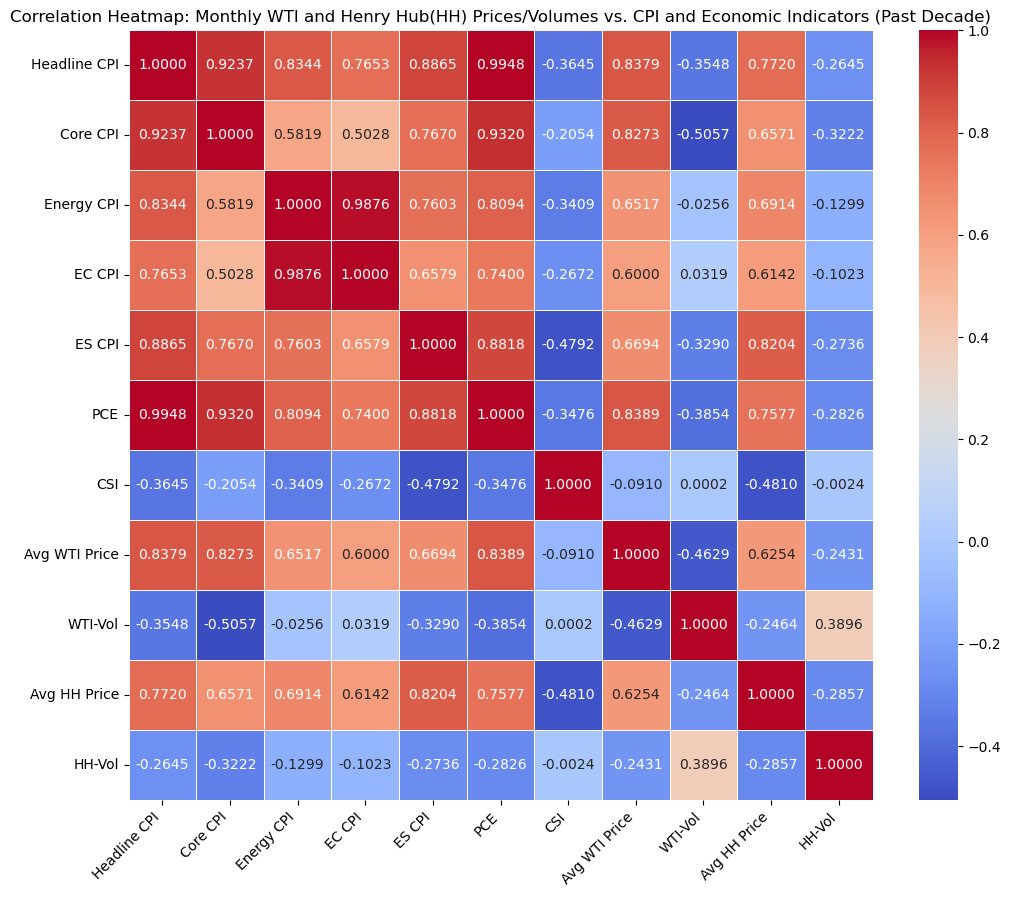

In [102]:
plt.figure(figsize=(12, 10))
heatmap = sns.heatmap(corr_decade, annot=True, fmt=".4f", cmap='coolwarm', linewidths=0.5)

#EC: Energy Commodities
#ES: Energy Service
tick_labels = ["Headline CPI","Core CPI","Energy CPI", "EC CPI", "ES CPI", "PCE","CSI",
               "Avg WTI Price","WTI-Vol","Avg HH Price","HH-Vol"]

heatmap.set_xticklabels(tick_labels, rotation=45,ha='right')
heatmap.set_yticklabels(tick_labels, rotation=0)

plt.title('Correlation Heatmap: Monthly WTI and Henry Hub(HH) Prices/Volumes vs. CPI and Economic Indicators (Past Decade)')

plt.savefig('outputs/heatmap_hhWTI_CPI_10yrs.png')

plt.show()

In [83]:
monthly_full_decade.columns

Index(['Date', 'CPI_all_items', 'CPI_excl_food_energy', 'CPI_Energy',
       'CPI_Energy_Commo', 'CPI_Energy_Ser', 'PCE', 'CSI', 'YearMonth',
       'avg_price_wti', 'total_volume_wti', 'avg_price_ng', 'total_volume_ng'],
      dtype='object')

In [89]:
plot_comm_vs_factor(
    comm_value='avg_price_wti', 
    comm_label='Avg Monthly WTI Futures Price',
    comm_unit='USD/Barrel',
    factor_value='CPI_Energy_Ser', 
    factor_label='Energy Service CPI',
    factor_unit='YoY % Change',
    time_frame='From Dec 2014 to Nov 2024',
    factor_df=monthly_full_decade, 
    comm_df=monthly_full_decade
)

Quick Summary
--------------
The Pearson correlation between Avg Monthly WTI Futures Price and Energy Service CPI is: 0.669
The slope of the Avg Monthly WTI Futures Price trendline is: 0.011293
The slope of the Energy Service CPI trendline is: 0.002599


In [90]:
plot_comm_vs_factor(
    comm_value='avg_price_ng', 
    comm_label='Avg Monthly Henry Hub Futures Price',
    comm_unit='USD/Barrel',
    factor_value='CPI_Energy_Ser', 
    factor_label='Energy Service CPI',
    factor_unit='YoY % Change',
    time_frame='From Dec 2014 to Nov 2024',
    factor_df=monthly_full_decade, 
    comm_df=monthly_full_decade
)

Quick Summary
--------------
The Pearson correlation between Avg Monthly Henry Hub Futures Price and Energy Service CPI is: 0.82
The slope of the Avg Monthly Henry Hub Futures Price trendline is: 0.000303
The slope of the Energy Service CPI trendline is: 0.002599


## 2.2 COVID-19 Period: March 2020 – May 2023
--- 
- hypothesis test (Pearson correlation)
- correlation differences

In [106]:
# "Covid Period" (according to WHO)
monthly_full_covid = monthly_full_decade[(monthly_full_decade['Date'] >= '2020-03-01')&
                                  (monthly_full_decade['Date'] <= '2023-05-01')].reset_index(drop=True)

corr_covid = monthly_full_covid.drop(columns=['Date','YearMonth']).corr()
corr_covid

CPI_all_items  CPI_excl_food_energy  CPI_Energy  \
CPI_all_items              1.000000              0.956405    0.848461   
CPI_excl_food_energy       0.956405              1.000000    0.677621   
CPI_Energy                 0.848461              0.677621    1.000000   
CPI_Energy_Commo           0.767435              0.586824    0.986478   
CPI_Energy_Ser             0.939450              0.884633    0.750679   
PCE                        0.996820              0.959655    0.841403   
CSI                       -0.066666              0.012038    0.006711   
avg_price_wti              0.948642              0.892474    0.812936   
total_volume_wti          -0.328271             -0.343764   -0.145813   
avg_price_ng               0.824596              0.716385    0.732285   
total_volume_ng           -0.599242             -0.556488   -0.515937   

                      CPI_Energy_Commo  CPI_Energy_Ser       PCE       CSI  \
CPI_all_items                 0.767435        0.939450  0.996820 -0.066666   
CPI_excl_food_energy          0.586824        0.884633  0.959655  0.012038   
CPI_Energy                    0.986478        0.750679  0.841403  0.006711   
CPI_Energy_Commo              1.000000        0.637275  0.762570  0.087315   
CPI_Energy_Ser                0.637275        1.000000  0.931466 -0.185473   
PCE                           0.762570        0.931466  1.000000 -0.032694   
CSI                           0.087315       -0.185473 -0.032694  1.000000   
avg_price_wti                 0.734550        0.886522  0.950156 -0.119895   
total_volume_wti             -0.079817       -0.398156 -0.341302  0.051254   
avg_price_ng                  0.634236        0.883636  0.803140 -0.385826   
total_volume_ng              -0.462203       -0.616024 -0.601012 -0.118636   

                      avg_price_wti  total_volume_wti  avg_price_ng  \
CPI_all_items              0.948642         -0.328271      0.824596   
CPI_excl_food_energy       0.892474         -0.343764      0.716385   
CPI_Energy                 0.812936         -0.145813      0.732285   
CPI_Energy_Commo           0.734550         -0.079817      0.634236   
CPI_Energy_Ser             0.886522         -0.398156      0.883636   
PCE                        0.950156         -0.341302      0.803140   
CSI                       -0.119895          0.051254     -0.385826   
avg_price_wti              1.000000         -0.437907      0.795404   
total_volume_wti          -0.437907          1.000000     -0.331559   
avg_price_ng               0.795404         -0.331559      1.000000   
total_volume_ng           -0.597972          0.414923     -0.507430   

                      total_volume_ng  
CPI_all_items               -0.599242  
CPI_excl_food_energy        -0.556488  
CPI_Energy                  -0.515937  
CPI_Energy_Commo            -0.462203  
CPI_Energy_Ser              -0.616024  
PCE                         -0.601012  
CSI                         -0.118636  
avg_price_wti               -0.597972  
total_volume_wti             0.414923  
avg_price_ng                -0.507430  
total_volume_ng              1.000000

In [108]:
# Calculate the correlation difference
# dataframe 1 = corr_decade: Dec 2021 ~ Nov 2024
# dataframe 2 = corr_covid: Feb 2020 ~ May 2023
comparison_matrix_covid = compare_correlation(corr_covid, corr_decade)
comparison_matrix_covid

CPI_all_items CPI_excl_food_energy CPI_Energy  \
CPI_all_items                 Same                 High       High   
CPI_excl_food_energy          High                 Same       High   
CPI_Energy                    High                 High       Same   
CPI_Energy_Commo              High                 High        Low   
CPI_Energy_Ser                High                 High        Low   
PCE                           High                 High       High   
CSI                           High                 High       High   
avg_price_wti                 High                 High       High   
total_volume_wti              High                 High        Low   
avg_price_ng                  High                 High       High   
total_volume_ng                Low                  Low        Low   

                     CPI_Energy_Commo CPI_Energy_Ser   PCE   CSI  \
CPI_all_items                    High           High  High  High   
CPI_excl_food_energy             High           High  High  High   
CPI_Energy                        Low            Low  High  High   
CPI_Energy_Commo                 Same            Low  High  High   
CPI_Energy_Ser                    Low           Same  High  High   
PCE                              High           High  Same  High   
CSI                              High           High  High  Same   
avg_price_wti                    High           High  High   Low   
total_volume_wti                  Low            Low  High  High   
avg_price_ng                     High           High  High  High   
total_volume_ng                   Low            Low   Low   Low   

                     avg_price_wti total_volume_wti avg_price_ng  \
CPI_all_items                 High             High         High   
CPI_excl_food_energy          High             High         High   
CPI_Energy                    High              Low         High   
CPI_Energy_Commo              High              Low         High   
CPI_Energy_Ser                High              Low         High   
PCE                           High             High         High   
CSI                            Low             High         High   
avg_price_wti                 Same             High         High   
total_volume_wti              High             Same          Low   
avg_price_ng                  High              Low         Same   
total_volume_ng                Low             High          Low   

                     total_volume_ng  
CPI_all_items                    Low  
CPI_excl_food_energy             Low  
CPI_Energy                       Low  
CPI_Energy_Commo                 Low  
CPI_Energy_Ser                   Low  
PCE                              Low  
CSI                              Low  
avg_price_wti                    Low  
total_volume_wti                High  
avg_price_ng                     Low  
total_volume_ng                 Same

In [109]:
# Percentage Change in Correlation (Past Decade vs. COVID-19 Period)
percent_change_full_covid = correlation_change(corr_covid, corr_decade)
percent_change_full_covid

CPI_all_items  CPI_excl_food_energy  CPI_Energy  \
CPI_all_items              0.000000              3.545114    1.688862   
CPI_excl_food_energy       3.545114              0.000000   16.451038   
CPI_Energy                 1.688862             16.451038    0.000000   
CPI_Energy_Commo           0.277621             16.718853   -0.117643   
CPI_Energy_Ser             5.971657             15.330777   -1.271895   
PCE                        0.203411              2.963035    3.954486   
CSI                       81.709875            105.859428  101.968436   
avg_price_wti             13.220361              7.873585   24.747439   
total_volume_wti           7.466391             32.024677 -469.747116   
avg_price_ng               6.818567              9.023548    5.916117   
total_volume_ng         -126.529176            -72.696434 -297.077960   

                      CPI_Energy_Commo  CPI_Energy_Ser         PCE  \
CPI_all_items                 0.277621        5.971657    0.203411   
CPI_excl_food_energy         16.718853       15.330777    2.963035   
CPI_Energy                   -0.117643       -1.271895    3.954486   
CPI_Energy_Commo              0.000000       -3.129010    3.054457   
CPI_Energy_Ser               -3.129010        0.000000    5.632608   
PCE                           3.054457        5.632608    0.000000   
CSI                         132.679851       61.299214   90.594060   
avg_price_wti                22.415784       32.443681   13.262549   
total_volume_wti           -350.113599      -21.001894   11.435306   
avg_price_ng                  3.262722        7.710165    5.991865   
total_volume_ng            -351.651644     -125.175715 -112.685174   

                               CSI  avg_price_wti  total_volume_wti  \
CPI_all_items            81.709875      13.220361          7.466391   
CPI_excl_food_energy    105.859428       7.873585         32.024677   
CPI_Energy              101.968436      24.747439       -469.747116   
CPI_Energy_Commo        132.679851      22.415784       -350.113599   
CPI_Energy_Ser           61.299214      32.443681        -21.001894   
PCE                      90.594060      13.262549         11.435306   
CSI                       0.000000     -31.816448      21796.143370   
avg_price_wti           -31.816448       0.000000          5.390673   
total_volume_wti      21796.143370       5.390673          0.000000   
avg_price_ng             19.791280      27.192716        -34.544376   
total_volume_ng       -4934.835001    -145.960849          6.494504   

                      avg_price_ng  total_volume_ng  
CPI_all_items             6.818567      -126.529176  
CPI_excl_food_energy      9.023548       -72.696434  
CPI_Energy                5.916117      -297.077960  
CPI_Energy_Commo          3.262722      -351.651644  
CPI_Energy_Ser            7.710165      -125.175715  
PCE                       5.991865      -112.685174  
CSI                      19.791280     -4934.835001  
avg_price_wti            27.192716      -145.960849  
total_volume_wti        -34.544376         6.494504  
avg_price_ng              0.000000       -77.637126  
total_volume_ng         -77.637126         0.000000

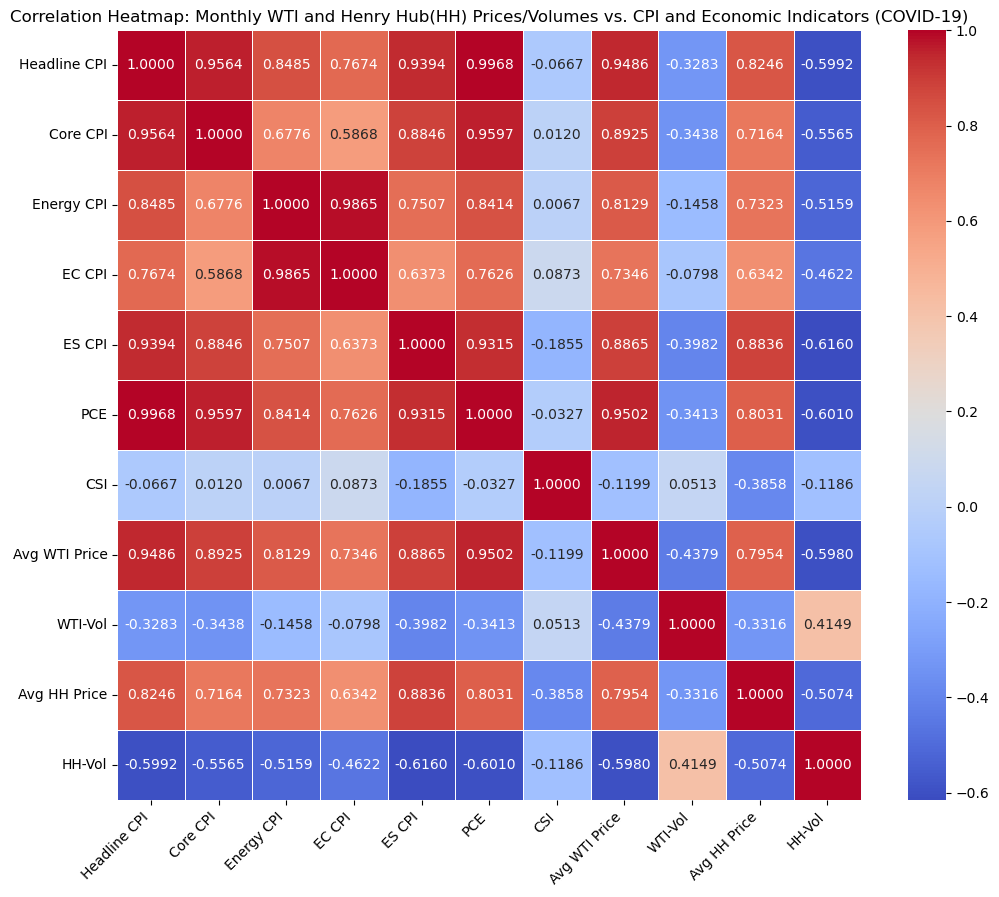

In [110]:
plt.figure(figsize=(12, 10))
heatmap = sns.heatmap(corr_covid, annot=True,fmt=".4f", cmap='coolwarm', linewidths=0.5)

#EC: Energy Commodities
#ES: Energy Service
tick_labels = ["Headline CPI","Core CPI","Energy CPI", "EC CPI", "ES CPI", "PCE","CSI",
               "Avg WTI Price","WTI-Vol","Avg HH Price","HH-Vol"]

heatmap.set_xticklabels(tick_labels, rotation=45,ha='right')
heatmap.set_yticklabels(tick_labels, rotation=0)

plt.title('Correlation Heatmap: Monthly WTI and Henry Hub(HH) Prices/Volumes vs. CPI and Economic Indicators (COVID-19)')

plt.savefig('outputs/heatmap_hhWTI_CPI_covid.png')

plt.show()

## 2.3 Post-COVID Period: June 2023 – November 2024
--- 
- hypothesis test (Spearman Rank Correlation)
- correlation differences

In [139]:
def plot_comm_vs_cpi_spearman(comm_value, comm_label, comm_unit, cpi_value, cpi_label, cpi_unit, title_period, cpi_cop_alu_pcovid):

    fig = go.Figure()

    fig.add_trace(go.Scatter(
        x=cpi_cop_alu_pcovid['Date'], 
        y=cpi_cop_alu_pcovid[comm_value], 
        mode='markers', 
        name=comm_label
    ))

    fig.add_trace(go.Scatter(
        x=cpi_cop_alu_pcovid['Date'], 
        y=cpi_cop_alu_pcovid[cpi_value], 
        mode='lines',
        name=cpi_label, 
        yaxis='y2'
    ))

    date_num = cpi_cop_alu_pcovid['Date'].map(pd.Timestamp.toordinal)


    slope_comm, intercept_comm, *_ = linregress(date_num, cpi_cop_alu_pcovid[comm_value])
    comm_trendline = slope_comm * date_num + intercept_comm
    fig.add_trace(go.Scatter(
        x=cpi_cop_alu_pcovid['Date'], 
        y=comm_trendline, 
        mode='lines', 
        name=f'{comm_label} Trendline', 
        line=dict(dash='dash', color='blue')
    ))

    slope_cpi, intercept_cpi, *_ = linregress(date_num, cpi_cop_alu_pcovid[cpi_value])
    cpi_trendline = slope_cpi * date_num + intercept_cpi
    fig.add_trace(go.Scatter(
        x=cpi_cop_alu_pcovid['Date'], 
        y=cpi_trendline, 
        mode='lines', 
        name=f'{cpi_label} Trendline', 
        line=dict(dash='dash', color='red'),
        yaxis='y2'
    ))


    fig.update_layout(
        title=f'{comm_label} with {cpi_label} ({title_period})',
        xaxis_title='Date',
        yaxis=dict(
            title=f'{comm_label} ({comm_unit})',
            titlefont=dict(color='blue'),
            tickfont=dict(color='blue'),
        ),
        yaxis2=dict(
            title=f'{cpi_label} ({cpi_unit})',
            titlefont=dict(color='red'),
            tickfont=dict(color='red'),
            overlaying='y',
            side='right',
            showgrid=False
        ),
        legend=dict(x=1.1, y=1),template='plotly_white'
    )


    fig.show()


    spearman_corr, p_value = stats.spearmanr(cpi_cop_alu_pcovid[cpi_value], cpi_cop_alu_pcovid[comm_value])

    print(f"Quick Summary")
    print(f"--------------")
    print(f"The Spearman Rank Correlation between {comm_label} and {cpi_label} is: {round(spearman_corr, 3)}")
    print(f"The slope of the {comm_label} trendline is: {round(slope_comm, 6)}")
    print(f"The slope of the {cpi_label} trendline is: {round(slope_cpi, 6)}")
    

In [124]:
def corr_statsig_spearman(x, y, alpha=0.05, label=""):
    
    spearman_corr, p_value = stats.spearmanr(x, y)
    
    is_significant = p_value < alpha
    
    print(f"{label}:")
    print(f"  Correlation (r): {spearman_corr:.4f}")
    print(f"  P-value: {p_value:.4f}")
    print(f"  Significant: {'Yes' if is_significant else 'No'}\n")
    return spearman_corr, p_value, is_significant

In [111]:
monthly_full_pcovid = monthly_full_decade[(monthly_full_decade['Date'] >= '2023-06-01')&
                                  (monthly_full_decade['Date'] <= '2024-11-01')].reset_index(drop=True)
monthly_full_pcovid.head()

Date  CPI_all_items  CPI_excl_food_energy  CPI_Energy  \
0 2023-06-01        3.05326               4.85522   -16.67792   
1 2023-07-01        3.27178               4.70760   -12.47732   
2 2023-08-01        3.71872               4.41280    -3.78274   
3 2023-09-01        3.69406               4.14370    -0.61157   
4 2023-10-01        3.24579               4.02170    -4.43948   

   CPI_Energy_Commo  CPI_Energy_Ser      PCE       CSI YearMonth  \
0         -26.92468        -1.12299  3.26157  28.40000   2023-06   
1         -20.57423        -1.16982  3.37385  38.83495   2023-07   
2          -4.47492        -2.72513  3.38712  19.24399   2023-08   
3           2.04875        -3.45737  3.41634  15.69966   2023-09   
4          -6.14629        -2.20775  2.99429   6.51085   2023-10   

   avg_price_wti  total_volume_wti  avg_price_ng  total_volume_ng  
0      70.274285         6857383.0      2.474619          3206300  
1      76.034500         6301345.0      2.636550          2240758  
2      81.320870         7346160.0      2.645130          3233540  
3      89.430500         6703761.0      2.695650          2504089  
4      85.466818         7404454.0      3.149182          3253805

In [112]:
print(len(monthly_full_pcovid))

18


In [116]:
#Post Covid Period (Using Spearman)
corr_pcovid = monthly_full_pcovid.drop(columns=['Date','YearMonth']).corr(method='spearman')
corr_pcovid

CPI_all_items  CPI_excl_food_energy  CPI_Energy  \
CPI_all_items              1.000000              0.661507    0.384933   
CPI_excl_food_energy       0.661507              1.000000   -0.356037   
CPI_Energy                 0.384933             -0.356037    1.000000   
CPI_Energy_Commo           0.558308             -0.143447    0.942208   
CPI_Energy_Ser            -0.461300             -0.812178    0.453044   
PCE                        0.845201              0.905057   -0.038184   
CSI                        0.541796              0.661507   -0.060888   
avg_price_wti              0.663571              0.211558    0.547988   
total_volume_wti          -0.277606             -0.131063   -0.294118   
avg_price_ng              -0.007224              0.366357   -0.378741   
total_volume_ng           -0.265222             -0.368421    0.110423   

                      CPI_Energy_Commo  CPI_Energy_Ser       PCE       CSI  \
CPI_all_items                 0.558308       -0.461300  0.845201  0.541796   
CPI_excl_food_energy         -0.143447       -0.812178  0.905057  0.661507   
CPI_Energy                    0.942208        0.453044 -0.038184 -0.060888   
CPI_Energy_Commo              1.000000        0.238390  0.176471 -0.042312   
CPI_Energy_Ser                0.238390        1.000000 -0.725490 -0.364293   
PCE                           0.176471       -0.725490  1.000000  0.626419   
CSI                          -0.042312       -0.364293  0.626419  1.000000   
avg_price_wti                 0.700722       -0.147575  0.523220 -0.065015   
total_volume_wti             -0.265222       -0.058824 -0.116615 -0.347781   
avg_price_ng                 -0.188854       -0.461300  0.199174 -0.073271   
total_volume_ng               0.056760        0.391125 -0.442724 -0.197110   

                      avg_price_wti  total_volume_wti  avg_price_ng  \
CPI_all_items              0.663571         -0.277606     -0.007224   
CPI_excl_food_energy       0.211558         -0.131063      0.366357   
CPI_Energy                 0.547988         -0.294118     -0.378741   
CPI_Energy_Commo           0.700722         -0.265222     -0.188854   
CPI_Energy_Ser            -0.147575         -0.058824     -0.461300   
PCE                        0.523220         -0.116615      0.199174   
CSI                       -0.065015         -0.347781     -0.073271   
avg_price_wti              1.000000          0.098039      0.085655   
total_volume_wti           0.098039          1.000000     -0.075335   
avg_price_ng               0.085655         -0.075335      1.000000   
total_volume_ng           -0.095975          0.500516     -0.211558   

                      total_volume_ng  
CPI_all_items               -0.265222  
CPI_excl_food_energy        -0.368421  
CPI_Energy                   0.110423  
CPI_Energy_Commo             0.056760  
CPI_Energy_Ser               0.391125  
PCE                         -0.442724  
CSI                         -0.197110  
avg_price_wti               -0.095975  
total_volume_wti             0.500516  
avg_price_ng                -0.211558  
total_volume_ng              1.000000

In [128]:
# WTI v.s. CPI
cpi_pce_columns = [
    'CPI_all_items', 'CPI_excl_food_energy', 'CPI_Energy', 
    'CPI_Energy_Commo', 'CPI_Energy_Ser', 'PCE'
]


for col in cpi_pce_columns:
    label = f"WTI v.s. {col}"
    print(f"\nTesting: {label}")
    corr_statsig_spearman(monthly_full_pcovid[col], monthly_full_pcovid['avg_price_wti'],label=label)
    print("-" * 50)


Testing: WTI v.s. CPI_all_items
WTI v.s. CPI_all_items:
  Correlation (r): 0.6636
  P-value: 0.0027
  Significant: Yes

--------------------------------------------------

Testing: WTI v.s. CPI_excl_food_energy
WTI v.s. CPI_excl_food_energy:
  Correlation (r): 0.2116
  P-value: 0.3994
  Significant: No

--------------------------------------------------

Testing: WTI v.s. CPI_Energy
WTI v.s. CPI_Energy:
  Correlation (r): 0.5480
  P-value: 0.0186
  Significant: Yes

--------------------------------------------------

Testing: WTI v.s. CPI_Energy_Commo
WTI v.s. CPI_Energy_Commo:
  Correlation (r): 0.7007
  P-value: 0.0012
  Significant: Yes

--------------------------------------------------

Testing: WTI v.s. CPI_Energy_Ser
WTI v.s. CPI_Energy_Ser:
  Correlation (r): -0.1476
  P-value: 0.5590
  Significant: No

--------------------------------------------------

Testing: WTI v.s. PCE
WTI v.s. PCE:
  Correlation (r): 0.5232
  P-value: 0.0259
  Significant: Yes

------------------------

In [130]:
# Henry Hub Natural Gas v.s. CPI
for col in cpi_pce_columns:
    label = f"Henry Hub Natural Gas v.s. {col}"
    print(f"\nTesting: {label}")
    corr_statsig_spearman(monthly_full_pcovid[col], monthly_full_pcovid['avg_price_ng'], label=label)
    print("-" * 50)


Testing: Henry Hub Natural Gas v.s. CPI_all_items
Henry Hub Natural Gas v.s. CPI_all_items:
  Correlation (r): -0.0072
  P-value: 0.9773
  Significant: No

--------------------------------------------------

Testing: Henry Hub Natural Gas v.s. CPI_excl_food_energy
Henry Hub Natural Gas v.s. CPI_excl_food_energy:
  Correlation (r): 0.3664
  P-value: 0.1348
  Significant: No

--------------------------------------------------

Testing: Henry Hub Natural Gas v.s. CPI_Energy
Henry Hub Natural Gas v.s. CPI_Energy:
  Correlation (r): -0.3787
  P-value: 0.1212
  Significant: No

--------------------------------------------------

Testing: Henry Hub Natural Gas v.s. CPI_Energy_Commo
Henry Hub Natural Gas v.s. CPI_Energy_Commo:
  Correlation (r): -0.1889
  P-value: 0.4529
  Significant: No

--------------------------------------------------

Testing: Henry Hub Natural Gas v.s. CPI_Energy_Ser
Henry Hub Natural Gas v.s. CPI_Energy_Ser:
  Correlation (r): -0.4613
  P-value: 0.0540
  Significant: 

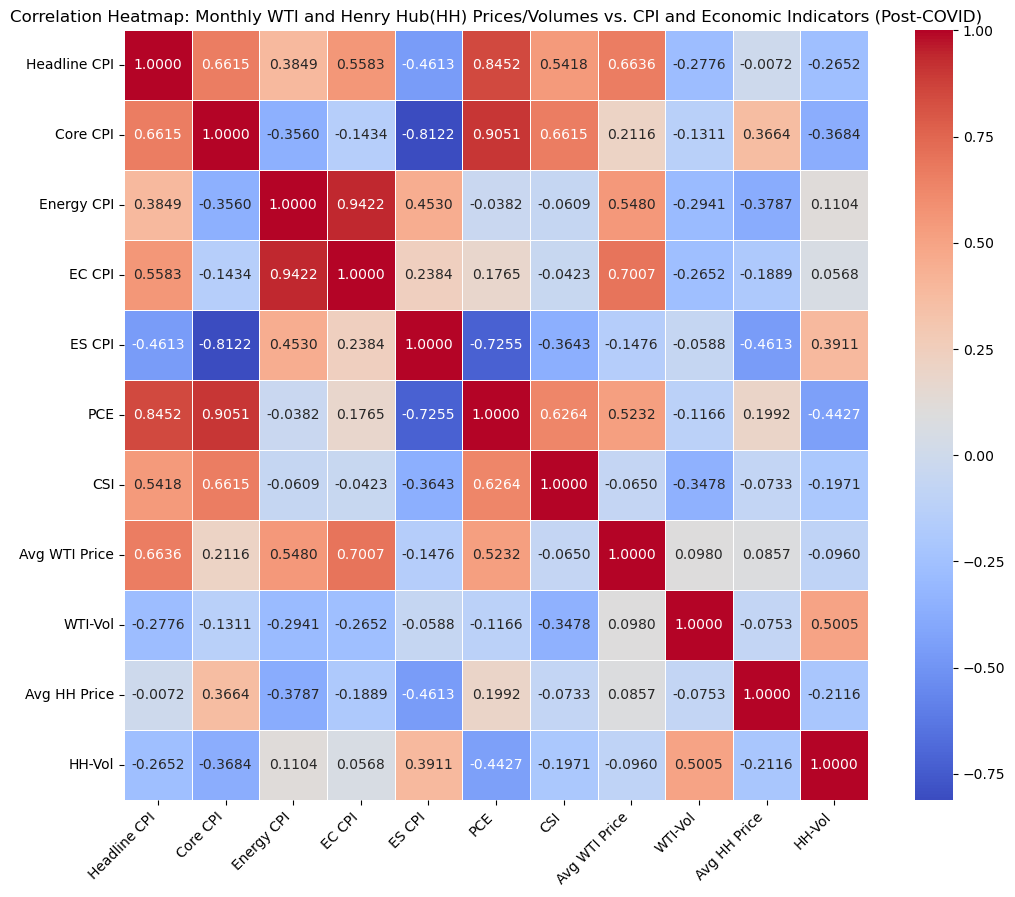

In [121]:
plt.figure(figsize=(12, 10))
heatmap = sns.heatmap(corr_pcovid, annot=True,fmt=".4f", cmap='coolwarm', linewidths=0.5)

#EC: Energy Commodities
#ES: Energy Service
tick_labels = ["Headline CPI","Core CPI","Energy CPI", "EC CPI", "ES CPI", "PCE","CSI",
               "Avg WTI Price","WTI-Vol","Avg HH Price","HH-Vol"]

heatmap.set_xticklabels(tick_labels, rotation=45,ha='right')
heatmap.set_yticklabels(tick_labels, rotation=0)

plt.title('Correlation Heatmap: Monthly WTI and Henry Hub(HH) Prices/Volumes vs. CPI and Economic Indicators (Post-COVID)')

plt.savefig('outputs/heatmap_hhWTI_CPI_pcovid.png')

plt.show()

In [117]:
comparison_matrix_pcovid = compare_correlation(corr_pcovid, corr_covid)
comparison_matrix_pcovid

CPI_all_items CPI_excl_food_energy CPI_Energy  \
CPI_all_items                 Same                  Low        Low   
CPI_excl_food_energy           Low                 Same        Low   
CPI_Energy                     Low                  Low       Same   
CPI_Energy_Commo               Low                  Low        Low   
CPI_Energy_Ser                 Low                  Low        Low   
PCE                            Low                  Low        Low   
CSI                           High                 High        Low   
avg_price_wti                  Low                  Low        Low   
total_volume_wti              High                 High        Low   
avg_price_ng                   Low                  Low        Low   
total_volume_ng               High                 High       High   

                     CPI_Energy_Commo CPI_Energy_Ser   PCE   CSI  \
CPI_all_items                     Low            Low   Low  High   
CPI_excl_food_energy              Low            Low   Low  High   
CPI_Energy                        Low            Low   Low   Low   
CPI_Energy_Commo                 Same            Low   Low   Low   
CPI_Energy_Ser                    Low           Same   Low   Low   
PCE                               Low            Low  Same  High   
CSI                               Low            Low  High  Same   
avg_price_wti                     Low            Low   Low  High   
total_volume_wti                  Low           High  High   Low   
avg_price_ng                      Low            Low   Low  High   
total_volume_ng                  High           High  High   Low   

                     avg_price_wti total_volume_wti avg_price_ng  \
CPI_all_items                  Low             High          Low   
CPI_excl_food_energy           Low             High          Low   
CPI_Energy                     Low              Low          Low   
CPI_Energy_Commo               Low              Low          Low   
CPI_Energy_Ser                 Low             High          Low   
PCE                            Low             High          Low   
CSI                           High              Low         High   
avg_price_wti                 Same             High          Low   
total_volume_wti              High             Same         High   
avg_price_ng                   Low             High         Same   
total_volume_ng               High             High         High   

                     total_volume_ng  
CPI_all_items                   High  
CPI_excl_food_energy            High  
CPI_Energy                      High  
CPI_Energy_Commo                High  
CPI_Energy_Ser                  High  
PCE                             High  
CSI                              Low  
avg_price_wti                   High  
total_volume_wti                High  
avg_price_ng                    High  
total_volume_ng                 Same

In [122]:
# Percentage Change in Correlation (Past Decade vs. COVID-19 Period)
percent_change_full_pcovid = correlation_change(corr_pcovid, corr_covid)
percent_change_full_pcovid

CPI_all_items  CPI_excl_food_energy   CPI_Energy  \
CPI_all_items              0.000000            -30.834023   -54.631608   
CPI_excl_food_energy     -30.834023              0.000000  -152.542231   
CPI_Energy               -54.631608           -152.542231     0.000000   
CPI_Energy_Commo         -27.250190           -124.444632    -4.487664   
CPI_Energy_Ser          -149.103254           -191.809553   -39.648697   
PCE                      -15.210254             -5.689381  -104.538097   
CSI                      912.703116           5395.363992 -1007.260787   
avg_price_wti            -30.050436            -76.295303   -32.591548   
total_volume_wti          15.433868             61.874127  -101.708443   
avg_price_ng            -100.876058            -48.860285  -151.720429   
total_volume_ng           55.740444             33.795269   121.402442   

                      CPI_Energy_Commo  CPI_Energy_Ser          PCE  \
CPI_all_items               -27.250190     -149.103254   -15.210254   
CPI_excl_food_energy       -124.444632     -191.809553    -5.689381   
CPI_Energy                   -4.487664      -39.648697  -104.538097   
CPI_Energy_Commo              0.000000      -62.592282   -76.858438   
CPI_Energy_Ser              -62.592282        0.000000  -177.886897   
PCE                         -76.858438     -177.886897     0.000000   
CSI                        -148.458624      -96.412837  2015.991922   
avg_price_wti                -4.605244     -116.646483   -44.933259   
total_volume_wti           -232.287933       85.226015    65.832332   
avg_price_ng               -129.776684     -152.204814   -75.200542   
total_volume_ng             112.280229      163.491814    26.336882   

                              CSI  avg_price_wti  total_volume_wti  \
CPI_all_items          912.703116     -30.050436         15.433868   
CPI_excl_food_energy  5395.363992     -76.295303         61.874127   
CPI_Energy           -1007.260787     -32.591548       -101.708443   
CPI_Energy_Commo      -148.458624      -4.605244       -232.287933   
CPI_Energy_Ser         -96.412837    -116.646483         85.226015   
PCE                   2015.991922     -44.933259         65.832332   
CSI                      0.000000      45.773027       -778.543306   
avg_price_wti           45.773027       0.000000        122.388144   
total_volume_wti      -778.543306     122.388144          0.000000   
avg_price_ng            81.009194     -89.231215         77.278415   
total_volume_ng        -66.147899      83.949866         20.628619   

                      avg_price_ng  total_volume_ng  
CPI_all_items          -100.876058        55.740444  
CPI_excl_food_energy    -48.860285        33.795269  
CPI_Energy             -151.720429       121.402442  
CPI_Energy_Commo       -129.776684       112.280229  
CPI_Energy_Ser         -152.204814       163.491814  
PCE                     -75.200542        26.336882  
CSI                      81.009194       -66.147899  
avg_price_wti           -89.231215        83.949866  
total_volume_wti         77.278415        20.628619  
avg_price_ng              0.000000        58.307873  
total_volume_ng          58.307873         0.000000

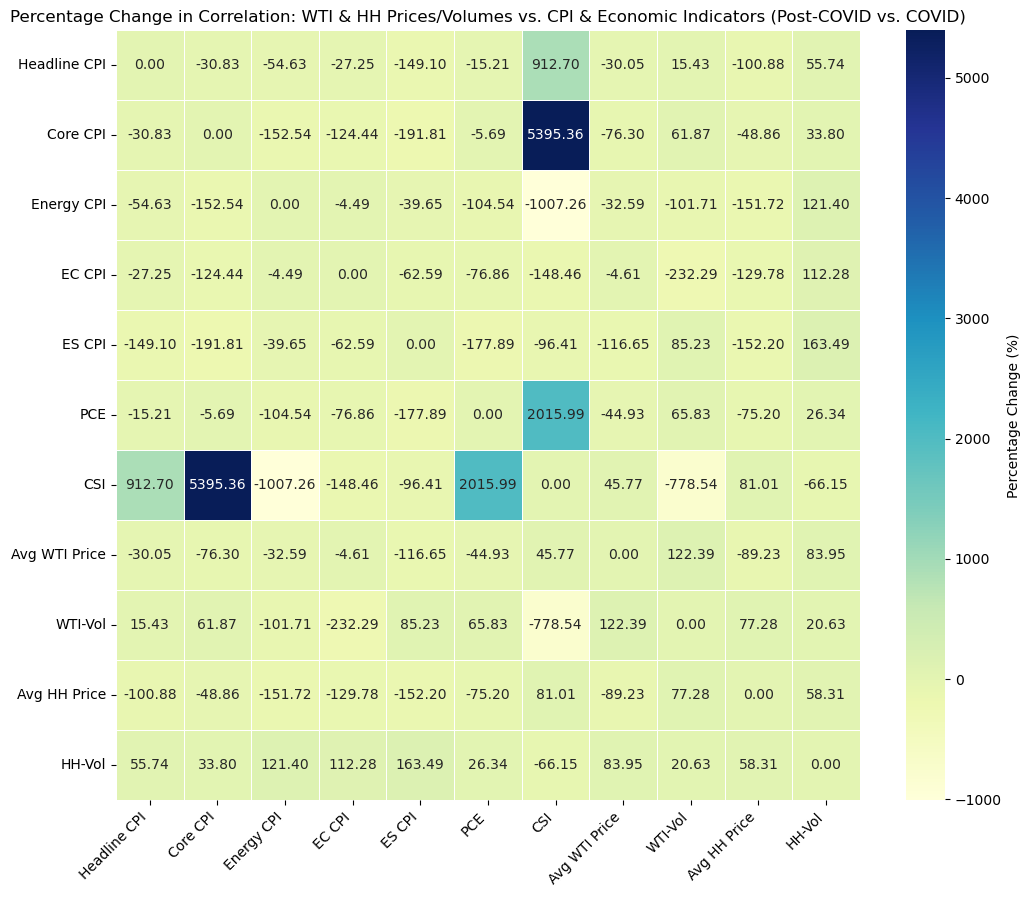

In [133]:
# Percentage Change in Correlation (Post-COVID vs. COVID)
plt.figure(figsize=(12, 10))

heatmap = sns.heatmap(percent_change_full_pcovid, annot=True,fmt=".2f",cmap='YlGnBu', linewidths=0.5,
                     cbar_kws={'label': 'Percentage Change (%)'})

#EC: Energy Commodities
#ES: Energy Service
tick_labels = ["Headline CPI","Core CPI","Energy CPI", "EC CPI", "ES CPI", "PCE","CSI",
               "Avg WTI Price","WTI-Vol","Avg HH Price","HH-Vol"]


heatmap.set_xticklabels(tick_labels, rotation=45,ha='right')
heatmap.set_yticklabels(tick_labels, rotation=0)

plt.title('Percentage Change in Correlation: WTI & HH Prices/Volumes vs. CPI & Economic Indicators (Post-COVID vs. COVID)')

plt.savefig('outputs/heatmap_changeinCorr_hhWTI_CPI_1yrs.png', dpi=300)

plt.show()

In [140]:
plot_comm_vs_cpi_spearman(
    comm_value='avg_price_wti', 
    comm_label='Avg Monthly WTI Futures Price',
    comm_unit = 'USD/Barrel',
    cpi_value='CPI_Energy_Ser', 
    cpi_label='Energy Service CPI',
    cpi_unit = 'YoY % Change',
    title_period ='From 2023-Jun to 2024-Nov',
    cpi_cop_alu_pcovid=monthly_full_pcovid, 
)


Quick Summary
--------------
The Spearman Rank Correlation between Avg Monthly WTI Futures Price and Energy Service CPI is: -0.148
The slope of the Avg Monthly WTI Futures Price trendline is: -0.012108
The slope of the Energy Service CPI trendline is: 0.014483


# 4. Cryptocurrencies
---
- **4.1 Interconnections among Cyrptocurrencies (Bitcoin/Ether)**
- **4.2 Cryptocurrencies and Hard Commodities (Copper/Aluminum)**
    - Includes additional analysis on **gold**.
- **4.3 Seasonality**

## 4.1 Interconnections among Cyrptocurrencies
---
- **4.1.1 Overview**
- **4.1.2 Spot Market Analysis**
- **4.1.3 Spot v.s. Futures Market Dynamics**

In [61]:
bitcoin = pd.read_csv("resources/bitcoin_daily.csv")
bitcoin_f = pd.read_csv("resources/bitcoin_daily_f.csv")
eth = pd.read_csv("resources/eth_daily.csv")
eth_f = pd.read_csv("resources/eth_daily_f.csv")

In [62]:
bitcoin_df = bitcoin[['Date', 'Close', 'Volume']].rename(columns={'Close': 'close_b', 'Volume': 'volume_b'})
bitcoin_f_df = bitcoin_f[['Date', 'Close', 'Volume']].rename(columns={'Close': 'close_b_f', 'Volume': 'volume_b_f'})
eth_df = eth[['Date', 'Close', 'Volume']].rename(columns={'Close': 'close_eth', 'Volume': 'volume_eth'})
eth_f_df= eth_f[['Date', 'Close', 'Volume']].rename(columns={'Close': 'close_eth_f','Volume': 'volume_eth_f'})                    

In [63]:
for df in [bitcoin_df, bitcoin_f_df, eth_df, eth_f_df]:
    df['Date'] = pd.to_datetime(df['Date'])

In [64]:
crypto_dataframes = {
    'bitcoin': bitcoin_df,
    'bitcoin_f': bitcoin_f_df,
    'eth': eth_df,
    'eth_f': eth_f_df,
}

crypto_full = crypto_dataframes['bitcoin']
for key in list(crypto_dataframes.keys())[1:]:
    crypto_full = crypto_full.merge(crypto_dataframes[key], on='Date', how='outer')

crypto_full = crypto_full.sort_values(by='Date').reset_index(drop=True)

crypto_full.head()

Date     close_b  volume_b  close_b_f  volume_b_f  close_eth  \
0 2014-12-01  379.244995  11763000        NaN         NaN        NaN   
1 2014-12-02  381.315002  12364100        NaN         NaN        NaN   
2 2014-12-03  375.010010  13340100        NaN         NaN        NaN   
3 2014-12-04  369.604004  14529600        NaN         NaN        NaN   
4 2014-12-05  376.854004  15181800        NaN         NaN        NaN   

   volume_eth  close_eth_f  volume_eth_f  
0         NaN          NaN           NaN  
1         NaN          NaN           NaN  
2         NaN          NaN           NaN  
3         NaN          NaN           NaN  
4         NaN          NaN           NaN

### 4.1.1 Overview

In [65]:
# Correlation table: ignoring NA values
corr_crypto_full= crypto_full.drop(columns=['Date']).corr()
corr_crypto_full

close_b  volume_b  close_b_f  volume_b_f  close_eth  \
close_b       1.000000  0.650113   0.999759    0.369283   0.912012   
volume_b      0.650113  1.000000   0.518842    0.553870   0.351302   
close_b_f     0.999759  0.518842   1.000000    0.369564   0.910628   
volume_b_f    0.369283  0.553870   0.369564    1.000000   0.283166   
close_eth     0.912012  0.351302   0.910628    0.283166   1.000000   
volume_eth    0.547714  0.868551   0.578504    0.495602   0.476170   
close_eth_f   0.771006  0.189968   0.772002   -0.069005   0.998875   
volume_eth_f -0.107059  0.214849  -0.106445    0.664195  -0.057463   

              volume_eth  close_eth_f  volume_eth_f  
close_b         0.547714     0.771006     -0.107059  
volume_b        0.868551     0.189968      0.214849  
close_b_f       0.578504     0.772002     -0.106445  
volume_b_f      0.495602    -0.069005      0.664195  
close_eth       0.476170     0.998875     -0.057463  
volume_eth      1.000000     0.360287      0.268046  
close_eth_f     0.360287     1.000000     -0.057367  
volume_eth_f    0.268046    -0.057367      1.000000

In [66]:
# Correlation table: excluding NA values
# Note 1: overall correlation decrease except ETH futures and its volume.
# Note 2: ETH futures data is only available starting February 2021.
corr_crypto_full_na = crypto_full.drop(columns=['Date']).dropna().corr()
corr_crypto_full_na

close_b  volume_b  close_b_f  volume_b_f  close_eth  \
close_b       1.000000  0.388480   0.999443    0.120199   0.771179   
volume_b      0.388480  1.000000   0.389403    0.439476   0.186309   
close_b_f     0.999443  0.389403   1.000000    0.120380   0.770919   
volume_b_f    0.120199  0.439476   0.120380    1.000000  -0.069998   
close_eth     0.771179  0.186309   0.770919   -0.069998   1.000000   
volume_eth    0.418609  0.771962   0.419182    0.320378   0.357557   
close_eth_f   0.771006  0.189968   0.772002   -0.069005   0.998875   
volume_eth_f -0.107059  0.214849  -0.106445    0.664195  -0.057463   

              volume_eth  close_eth_f  volume_eth_f  
close_b         0.418609     0.771006     -0.107059  
volume_b        0.771962     0.189968      0.214849  
close_b_f       0.419182     0.772002     -0.106445  
volume_b_f      0.320378    -0.069005      0.664195  
close_eth       0.357557     0.998875     -0.057463  
volume_eth      1.000000     0.360287      0.268046  
close_eth_f     0.360287     1.000000     -0.057367  
volume_eth_f    0.268046    -0.057367      1.000000

### 4.1.2 Spot Market Analysis
---
- **Period 1**: Seven-year (Nov 9, 2017 – Nov 29, 2024)
- **Period 2**: Five-year (Dec 2019 – Nov 2024)

In [67]:
# Cryptocurrency (Spot Market)
# Date Range: Nov 9, 2017 – Nov 29, 2024 (approx. 7 years)
# Ether Data Availability: Nov 9, 2017
crypto_spot_df = pd.merge(bitcoin_df,eth_df, on='Date', how='right').rename(columns = {"Date":"date"})
crypto_spot_df.head()

date      close_b    volume_b   close_eth  volume_eth
0 2017-11-09  7143.580078  3226249984  320.884003   893249984
1 2017-11-10  6618.140137  5208249856  299.252991   885985984
2 2017-11-11  6357.600098  4908680192  314.681000   842300992
3 2017-11-12  5950.069824  8957349888  307.907990  1613479936
4 2017-11-13  6559.490234  6263249920  316.716003  1041889984

In [68]:
# Cryptocurrency (Spot Market) - Correlation table
# Date Range: Nov 9, 2017 – Nov 29, 2024 (approx. 7 years)
crypto_spot_df.drop(columns=['date']).corr()

close_b  volume_b  close_eth  volume_eth
close_b     1.000000  0.476494   0.912012    0.547714
volume_b    0.476494  1.000000   0.351302    0.868551
close_eth   0.912012  0.351302   1.000000    0.476170
volume_eth  0.547714  0.868551   0.476170    1.000000

In [69]:
# Cryptocurrency (Spot Market) - Correlation table
# Date Range: Dec 2019 – Nov 2024 (5 years)
crypto_spot_5yr_df = crypto_spot_df[(crypto_spot_df['date'] >= '2019-12-01')&
                                  (crypto_spot_df['date'] <= '2024-11-29')].reset_index(drop=True)
corr_crypto_spot_5yr = crypto_spot_5yr_df.drop(columns=['date']).corr()
corr_crypto_spot_5yr

close_b  volume_b  close_eth  volume_eth
close_b     1.000000  0.248364   0.869879    0.346081
volume_b    0.248364  1.000000   0.077891    0.814872
close_eth   0.869879  0.077891   1.000000    0.252579
volume_eth  0.346081  0.814872   0.252579    1.000000

In [70]:
# Correlation significance test
correlations = {'Ether(Spot) v.s. Bitcoin(Spot)-Volume': 0.077891}

n = len(crypto_spot_5yr_df)

corr_statsig(correlations, n)

Ether(Spot) v.s. Bitcoin(Spot)-Volume:
  Correlation (r): 0.0779
  t-statistic: 3.3367
  p-value: 0.0009
  Significant: Yes
--------------------------------------------------


In [71]:
print(len(crypto_spot_5yr_df))

1826


### 4.1.3 Spot v.s. Futures Market Dynamics
---
- Heatmap Visualization: Correlation v.s. Percentage Change 
    - **Period 1**: Three-year analysis (Dec 2021 to Nov 2024)
    - **Period 2**: Two-year analysis  (Dec 2022 to Nov 2024)
    - **Period 3**: One-year analysis (Dec 2023 to Nov 2024)

In [72]:
# Cryptocurrency (Futures Market)
# Date Range: Feb 05,2021 ~ Nov 29, 2024 (> 3 yrs)
crypto_f_df = pd.merge(bitcoin_f_df,eth_f_df, on='Date', how='right').rename(columns = {"Date":"date"})
crypto_f_df.head()

date  close_b_f  volume_b_f  close_eth_f  volume_eth_f
0 2021-02-05    38015.0        4767      1745.00           280
1 2021-02-08    44755.0       14369      1751.75           303
2 2021-02-09    47765.0       11114      1797.25           201
3 2021-02-10    44915.0        9743      1728.50           288
4 2021-02-11    47525.0        9072      1778.00           351

#### Period 1: Three-year analysis (Dec 2021 to Nov 2024)

In [73]:
# Cryptocurrency (Futures Market)
# Date Range: Dec 2021 ~ Nov 2024 (3 yrs)
crypto_f_3yr_df = crypto_f_df[(crypto_f_df['date'] >= '2021-12-01')&
                                  (crypto_f_df['date'] <= '2024-11-29')].reset_index(drop=True)

In [74]:
# Cryptocurrency (Spot & Futures)
# Date Range: Dec 2021 ~ Nov 2024 (3 yrs)
crypto_spot_3yr_df = crypto_spot_df[(crypto_spot_df['date'] >= '2021-12-01')&
                                  (crypto_spot_df['date'] <= '2024-11-29')].reset_index(drop=True)
crypto_3yrs_full = pd.merge(crypto_spot_3yr_df,crypto_f_3yr_df, on='date', how='left')
crypto_3yrs_full.head()

date       close_b     volume_b    close_eth   volume_eth  close_b_f  \
0 2021-12-01  57229.828125  36858195307  4586.990234  27634826695    56990.0   
1 2021-12-02  56477.816406  32379968686  4511.302246  21502671027    57175.0   
2 2021-12-03  53598.246094  39789134215  4220.706055  25879591528    53545.0   
3 2021-12-04  49200.703125  61385677469  4119.587402  38478999182        NaN   
4 2021-12-05  49368.847656  37198201161  4198.322754  25533062707        NaN   

   volume_b_f  close_eth_f  volume_eth_f  
0      6552.0      4594.50        5468.0  
1      5835.0      4543.25        5197.0  
2     11175.0      4214.00        6550.0  
3         NaN          NaN           NaN  
4         NaN          NaN           NaN

In [75]:
# Cryptocurrency (Spot & Futures)-Correlation table
# Date Range: Nov 2021 ~ Nov 2024 (3 yrs)
corr_crypto_3yrs_full = crypto_3yrs_full.drop(columns=['date']).corr()
corr_crypto_3yrs_full

close_b  volume_b  close_eth  volume_eth  close_b_f  \
close_b       1.000000  0.377318   0.840239    0.454733   0.999647   
volume_b      0.377318  1.000000   0.272520    0.884235   0.441266   
close_eth     0.840239  0.272520   1.000000    0.410706   0.837482   
volume_eth    0.454733  0.884235   0.410706    1.000000   0.487397   
close_b_f     0.999647  0.441266   0.837482    0.487397   1.000000   
volume_b_f    0.176506  0.634519  -0.006871    0.510165   0.175753   
close_eth_f   0.838610  0.306038   0.999081    0.435459   0.838629   
volume_eth_f -0.057776  0.549874  -0.143551    0.578561  -0.058925   

              volume_b_f  close_eth_f  volume_eth_f  
close_b         0.176506     0.838610     -0.057776  
volume_b        0.634519     0.306038      0.549874  
close_eth      -0.006871     0.999081     -0.143551  
volume_eth      0.510165     0.435459      0.578561  
close_b_f       0.175753     0.838629     -0.058925  
volume_b_f      1.000000    -0.007264      0.709250  
close_eth_f    -0.007264     1.000000     -0.145333  
volume_eth_f    0.709250    -0.145333      1.000000

In [76]:
# Correlation significance test
correlations_crpto_3yrs = {'Ether(Spot) v.s. Bitcoin(Spot)-Volume': 0.272520,
                           'Bitcoin(Spot) v.s. Ether(Futures)-Volume':-0.057776,
                           'Ether(Spot) v.s. Ether(Futures)-Volume':-0.143551,
                          }

n = len(crypto_3yrs_full)

corr_statsig(correlations_crpto_3yrs, n)

Ether(Spot) v.s. Bitcoin(Spot)-Volume:
  Correlation (r): 0.2725
  t-statistic: 9.3641
  p-value: 0.0000
  Significant: Yes
--------------------------------------------------
Bitcoin(Spot) v.s. Ether(Futures)-Volume:
  Correlation (r): -0.0578
  t-statistic: -1.9133
  p-value: 0.0560
  Significant: No
--------------------------------------------------
Ether(Spot) v.s. Ether(Futures)-Volume:
  Correlation (r): -0.1436
  t-statistic: -4.7955
  p-value: 0.0000
  Significant: Yes
--------------------------------------------------


In [77]:
print(len(crypto_3yrs_full))

1095


In [78]:
corr_crypto_3yrs_full.to_csv("outputs/corr_fullCrypto_3yr.csv", index=True)

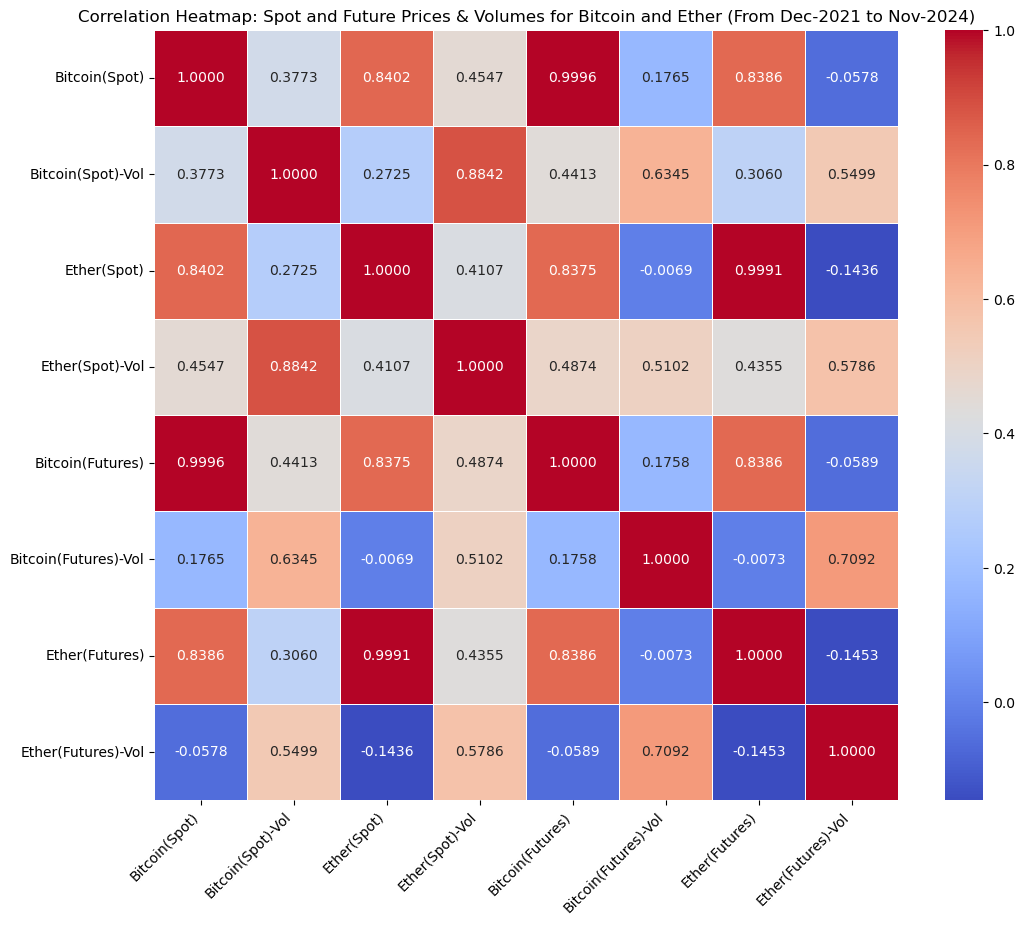

In [79]:
# Cryptocurrency (Spot & Futures)-Correlation Heatmap
# Date Range: Dec 2021 ~ Nov 2024 (3 yrs)
plt.figure(figsize=(12, 10))

heatmap = sns.heatmap(corr_crypto_3yrs_full, annot=True,fmt=".4f",cmap='coolwarm', linewidths=0.5)

tick_labels = ["Bitcoin(Spot)", "Bitcoin(Spot)-Vol", "Ether(Spot)", "Ether(Spot)-Vol", 
               "Bitcoin(Futures)", "Bitcoin(Futures)-Vol", "Ether(Futures)", "Ether(Futures)-Vol"]

heatmap.set_xticklabels(tick_labels, rotation=45,ha='right')
heatmap.set_yticklabels(tick_labels, rotation=0)

plt.title('Correlation Heatmap: Spot and Future Prices & Volumes for Bitcoin and Ether (From Dec-2021 to Nov-2024)')

plt.savefig('outputs/heatmap_crypto_spotFutures_3yrs.png', dpi=300)

plt.show()

In [80]:
def compare_correlation(short_df, long_df):

    if short_df.shape != long_df.shape:
        raise ValueError("The correlation dataframes must have the same shape")
    
    correlation_diff = short_df - long_df

    comparison_matrix = correlation_diff.applymap(
        lambda x: 'High' if x > 0 else 'Low' if x < 0 else 'Same'
    )

    for i in comparison_matrix.index:
        comparison_matrix.loc[i, i] = 'Same'
    
    return comparison_matrix

In [81]:
def correlation_change(short_df, long_df):

    if short_df.shape != long_df.shape:
        raise ValueError("The correlation dataframes must have the same shape")
    

    percentage_change = ((short_df - long_df) / long_df.abs()) * 100

    
    for i in percentage_change.index:
        percentage_change.loc[i, i] = 0.0
    
    return percentage_change

In [82]:
def plot_dual_y_axis(df, years, x_column, primary_y_columns, secondary_y_columns, 
                     primary_y_label, secondary_y_label, title, legend_labels=None):


    filtered_df = df[df['Year'].isin(years)]


    fig = go.Figure()
    

    if legend_labels is None:
        legend_labels = primary_y_columns + secondary_y_columns
    elif len(legend_labels) != len(primary_y_columns) + len(secondary_y_columns):
        raise ValueError("The number of legend_labels must match the total number of columns.")
    

    for column, label in zip(primary_y_columns, legend_labels[:len(primary_y_columns)]):
        fig.add_trace(go.Scatter(
            x=filtered_df[x_column],
            y=filtered_df[column],
            mode='lines',
            name=label,
            yaxis='y1'
        ))
    

    for column, label in zip(secondary_y_columns, legend_labels[len(primary_y_columns):]):
        fig.add_trace(go.Scatter(
            x=filtered_df[x_column],
            y=filtered_df[column],
            mode='lines',
            name=label,
            yaxis='y2'
        ))
    

    fig.update_layout(
        title=f"{title}",
        xaxis=dict(title=x_column),
        yaxis=dict(
            title=primary_y_label,
            showgrid=True,
            zeroline=False,
        ),
        yaxis2=dict(
            title=secondary_y_label,
            overlaying='y',
            side='right',
            showgrid=False,
        ),
        legend=dict(x=1.1, y=1),
        template='plotly_white'
    )
    

    fig.show()
    
    return fig

In [83]:
# Calculate the correlation difference
# dataframe 1 = corr_crypto_3yr_full: Dec 2021 ~ Nov 2024
# dataframe 2 = corr_crypto_full_na: Feb 2021 ~ Nov 2024
comparison_matrix_crypto3Yrs = compare_correlation(corr_crypto_3yrs_full, corr_crypto_full_na)
comparison_matrix_crypto3Yrs

close_b close_b_f close_eth close_eth_f volume_b volume_b_f  \
close_b         Same      High      High        High      Low       High   
close_b_f       High      Same      High        High     High       High   
close_eth       High      High      Same        High     High       High   
close_eth_f     High      High      High        Same     High       High   
volume_b         Low      High      High        High     Same       High   
volume_b_f      High      High      High        High     High       Same   
volume_eth      High      High      High        High     High       High   
volume_eth_f    High      High       Low         Low     High       High   

             volume_eth volume_eth_f  
close_b            High         High  
close_b_f          High         High  
close_eth          High          Low  
close_eth_f        High          Low  
volume_b           High         High  
volume_b_f         High         High  
volume_eth         Same         High  
volume_eth_f       High         Same

In [84]:
comparison_matrix_crypto3Yrs.to_csv("outputs/matrix_crypto_3yrVSfullna.csv", index=True)

In [85]:
# Percentage Change in Correlation (Dec 2021 - Nov 2024 vs. Feb 2021 - Nov 2024)
percent_change_fullCrypto_3yr = correlation_change(corr_crypto_3yrs_full, corr_crypto_full_na)
percent_change_fullCrypto_3yr

close_b  close_b_f   close_eth  close_eth_f    volume_b  \
close_b        0.000000   0.020377    8.955103     8.768321   -2.873329   
close_b_f      0.020377   0.000000    8.634287     8.630346   13.318557   
close_eth      8.955103   8.634287    0.000000     0.020558   46.272892   
close_eth_f    8.768321   8.630346    0.020558     0.000000   61.099513   
volume_b      -2.873329  13.318557   46.272892    61.099513    0.000000   
volume_b_f    46.844199  45.997681   90.184660    89.473045   44.380981   
volume_eth     8.629565  16.273454   14.864690    20.864337   14.543859   
volume_eth_f  46.033849  44.642583 -149.815127  -153.340248  155.934439   

              volume_b_f  volume_eth  volume_eth_f  
close_b        46.844199    8.629565     46.033849  
close_b_f      45.997681   16.273454     44.642583  
close_eth      90.184660   14.864690   -149.815127  
close_eth_f    89.473045   20.864337   -153.340248  
volume_b       44.380981   14.543859    155.934439  
volume_b_f      0.000000   59.238725      6.783407  
volume_eth     59.238725    0.000000    115.844250  
volume_eth_f    6.783407  115.844250      0.000000

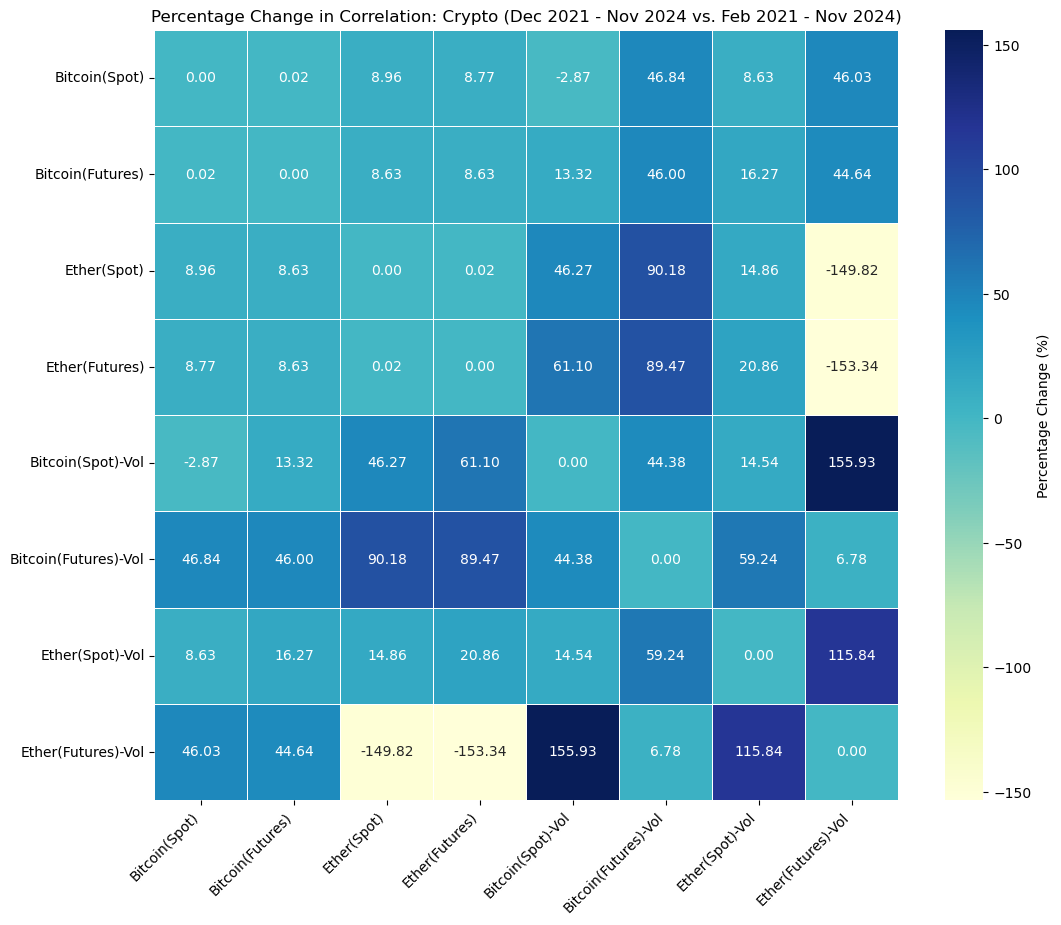

In [86]:
# Percentage Change in Correlation (Dec 2021 - Nov 2024 vs. Feb 2021 - Nov 2024)
plt.figure(figsize=(12, 10))

heatmap = sns.heatmap(percent_change_fullCrypto_3yr, annot=True,fmt=".2f",cmap='YlGnBu', linewidths=0.5,
                     cbar_kws={'label': 'Percentage Change (%)'})

tick_labels = ["Bitcoin(Spot)","Bitcoin(Futures)","Ether(Spot)","Ether(Futures)",
               "Bitcoin(Spot)-Vol","Bitcoin(Futures)-Vol","Ether(Spot)-Vol","Ether(Futures)-Vol"]

heatmap.set_xticklabels(tick_labels, rotation=45,ha='right')
heatmap.set_yticklabels(tick_labels, rotation=0)

plt.title('Percentage Change in Correlation: Crypto (Dec 2021 - Nov 2024 vs. Feb 2021 - Nov 2024)')

plt.savefig('outputs/heatmap_changeinCorr_crypto_3yrs.png', dpi=300)

plt.show()

#### Period 2: Two-year analysis  (Dec 2022 to Nov 2024)

In [87]:
# Cryptocurrency (Spot & Futures)-Correlation Table
# Date Range: Nov 2022 ~ Nov 2024 (2 yrs)
corr_crypto_2yrs_full = crypto_3yrs_full[(crypto_3yrs_full['date'] >= '2022-12-01')&
                        (crypto_3yrs_full['date'] <= '2024-11-29')].drop(columns=['date']).corr()
corr_crypto_2yrs_full

close_b  volume_b  close_eth  volume_eth  close_b_f  \
close_b       1.000000  0.603193   0.915357    0.718032   0.999659   
volume_b      0.603193  1.000000   0.500788    0.919346   0.682491   
close_eth     0.915357  0.500788   1.000000    0.631845   0.912367   
volume_eth    0.718032  0.919346   0.631845    1.000000   0.759816   
close_b_f     0.999659  0.682491   0.912367    0.759816   1.000000   
volume_b_f    0.320867  0.656264   0.270443    0.599640   0.319850   
close_eth_f   0.913849  0.568455   0.999104    0.674837   0.913482   
volume_eth_f  0.192288  0.557064   0.151563    0.588307   0.191440   

              volume_b_f  close_eth_f  volume_eth_f  
close_b         0.320867     0.913849      0.192288  
volume_b        0.656264     0.568455      0.557064  
close_eth       0.270443     0.999104      0.151563  
volume_eth      0.599640     0.674837      0.588307  
close_b_f       0.319850     0.913482      0.191440  
volume_b_f      1.000000     0.267697      0.716948  
close_eth_f     0.267697     1.000000      0.147943  
volume_eth_f    0.716948     0.147943      1.000000

In [88]:
# Correlation significance test
correlations_crpto_2yrs = {'Ether(Futures) v.s. Ether(Futures)-Volume':0.147943,
                           'Bitcoin(Spot) v.s. Ether(Futures)-Volume':0.192288,
                           'Ether(Spot) v.s. Ether(Futures)-Volume':0.151563,
                          }

n = len(crypto_3yrs_full[(crypto_3yrs_full['date'] >= '2022-12-01')&
                        (crypto_3yrs_full['date'] <= '2024-11-29')])

corr_statsig(correlations_crpto_2yrs, n)

Ether(Futures) v.s. Ether(Futures)-Volume:
  Correlation (r): 0.1479
  t-statistic: 4.0361
  p-value: 0.0001
  Significant: Yes
--------------------------------------------------
Bitcoin(Spot) v.s. Ether(Futures)-Volume:
  Correlation (r): 0.1923
  t-statistic: 5.2869
  p-value: 0.0000
  Significant: Yes
--------------------------------------------------
Ether(Spot) v.s. Ether(Futures)-Volume:
  Correlation (r): 0.1516
  t-statistic: 4.1372
  p-value: 0.0000
  Significant: Yes
--------------------------------------------------


In [89]:
corr_crypto_2yrs_full.to_csv("outputs/corr_fullCrypto_2yr.csv", index=True)

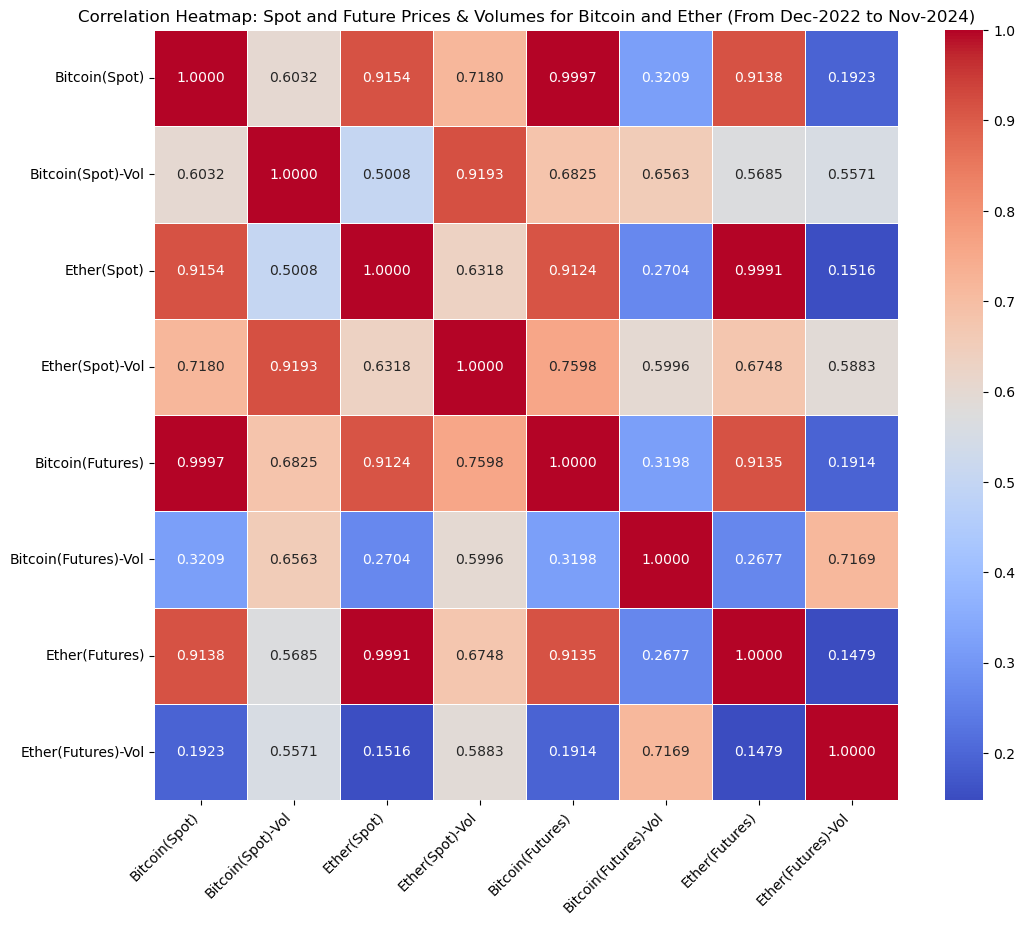

In [90]:
# Cryptocurrency (Spot & Futures) - Correlation Heatmap
# Date Range: Dec 2022 ~ Nov 2024 (2 yrs)

plt.figure(figsize=(12, 10))

heatmap = sns.heatmap(corr_crypto_2yrs_full, annot=True,fmt=".4f",cmap='coolwarm', linewidths=0.5)

tick_labels = ["Bitcoin(Spot)", "Bitcoin(Spot)-Vol", "Ether(Spot)", "Ether(Spot)-Vol", 
               "Bitcoin(Futures)", "Bitcoin(Futures)-Vol", "Ether(Futures)", "Ether(Futures)-Vol"]

heatmap.set_xticklabels(tick_labels, rotation=45,ha='right')
heatmap.set_yticklabels(tick_labels, rotation=0)

plt.title('Correlation Heatmap: Spot and Future Prices & Volumes for Bitcoin and Ether (From Dec-2022 to Nov-2024)')

plt.savefig('outputs/heatmap_crypto_spotFutures_2yrs.png', dpi=300)

plt.show()

In [91]:
# Calculate the correlation difference
# dataframe 1 = corr_crypto_3yr_full: Dec 2021 ~ Nov 2024
# dataframe 2 = corr_crypto_2yrs_full: Dec 2022 ~ Nov 2024
comparison_matrix_crypto2Yrs = compare_correlation(corr_crypto_2yrs_full, corr_crypto_3yrs_full)
comparison_matrix_crypto2Yrs

close_b volume_b close_eth volume_eth close_b_f volume_b_f  \
close_b         Same     High      High       High      High       High   
volume_b        High     Same      High       High      High       High   
close_eth       High     High      Same       High      High       High   
volume_eth      High     High      High       Same      High       High   
close_b_f       High     High      High       High      Same       High   
volume_b_f      High     High      High       High      High       Same   
close_eth_f     High     High      High       High      High       High   
volume_eth_f    High     High      High       High      High       High   

             close_eth_f volume_eth_f  
close_b             High         High  
volume_b            High         High  
close_eth           High         High  
volume_eth          High         High  
close_b_f           High         High  
volume_b_f          High         High  
close_eth_f         Same         High  
volume_eth_f        High         Same

In [92]:
# Percentage Change in Correlation (Dec 2022 - Nov 2024 vs. Dec 2021 - Nov 2024)/ 2 yrs v.s. 3 yrs
percent_change_fullCrypto_2yr = correlation_change(corr_crypto_2yrs_full, corr_crypto_3yrs_full)
percent_change_fullCrypto_2yr

close_b   volume_b    close_eth  volume_eth   close_b_f  \
close_b         0.000000  59.863405     8.940056   57.902022    0.001199   
volume_b       59.863405   0.000000    83.761717    3.970697   54.666653   
close_eth       8.940056  83.761717     0.000000   53.843626    8.941681   
volume_eth     57.902022   3.970697    53.843626    0.000000   55.892561   
close_b_f       0.001199  54.666653     8.941681   55.892561    0.000000   
volume_b_f     81.788482   3.426926  4036.263747   17.538304   81.988700   
close_eth_f     8.971793  85.746545     0.002376   54.971486    8.925634   
volume_eth_f  432.818596   1.307712   205.581087    1.684580  424.887419   

               volume_b_f  close_eth_f  volume_eth_f  
close_b         81.788482     8.971793    432.818596  
volume_b         3.426926    85.746545      1.307712  
close_eth     4036.263747     0.002376    205.581087  
volume_eth      17.538304    54.971486      1.684580  
close_b_f       81.988700     8.925634    424.887419  
volume_b_f       0.000000  3785.182366      1.085493  
close_eth_f   3785.182366     0.000000    201.796017  
volume_eth_f     1.085493   201.796017      0.000000

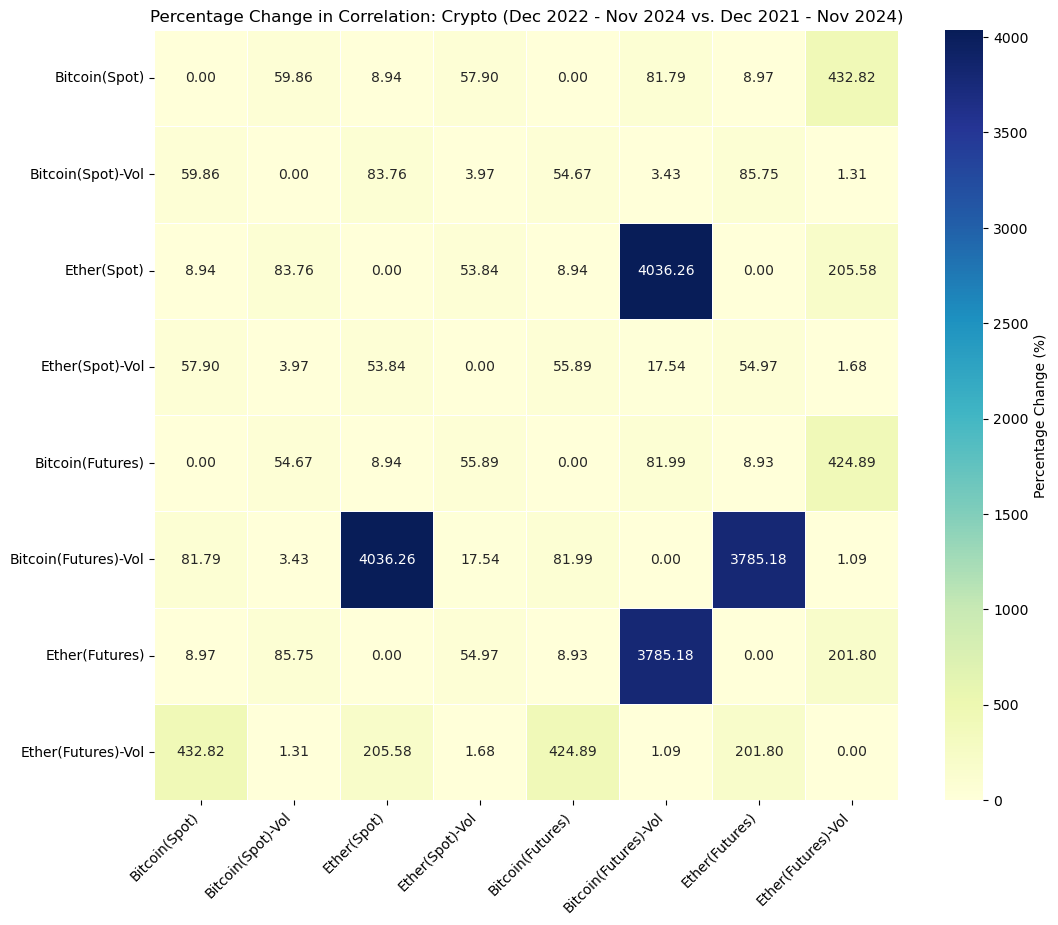

In [93]:
# Percentage Change in Correlation (Dec 2023 - Nov 2024 vs. Dec 2022 - Nov 2024)
plt.figure(figsize=(12, 10))

heatmap = sns.heatmap(percent_change_fullCrypto_2yr, annot=True,fmt=".2f",cmap='YlGnBu', linewidths=0.5,
                     cbar_kws={'label': 'Percentage Change (%)'})

tick_labels = ["Bitcoin(Spot)", "Bitcoin(Spot)-Vol", "Ether(Spot)", "Ether(Spot)-Vol", 
               "Bitcoin(Futures)", "Bitcoin(Futures)-Vol", "Ether(Futures)", "Ether(Futures)-Vol"]

heatmap.set_xticklabels(tick_labels, rotation=45,ha='right')
heatmap.set_yticklabels(tick_labels, rotation=0)

plt.title('Percentage Change in Correlation: Crypto (Dec 2022 - Nov 2024 vs. Dec 2021 - Nov 2024)')

plt.savefig('outputs/heatmap_changeinCorr_crypto_2yrs.png', dpi=300)

plt.show()

#### Period 3: One-year analysis (Nov 2023 to Nov 2024)

In [94]:
# Cryptocurrency (Spot & Futures)-Correlation Table
# Date Range: Dec 2023 ~ Nov 2024 (1 yr)
corr_crypto_1yr_full = crypto_3yrs_full[(crypto_3yrs_full['date'] >= '2023-12-01')&
                                  (crypto_3yrs_full['date'] <= '2024-11-29')].drop(columns=['date']).corr()
corr_crypto_1yr_full


close_b  volume_b  close_eth  volume_eth  close_b_f  \
close_b       1.000000  0.522510   0.645247    0.562974   0.998458   
volume_b      0.522510  1.000000   0.242970    0.915783   0.590284   
close_eth     0.645247  0.242970   1.000000    0.317473   0.632592   
volume_eth    0.562974  0.915783   0.317473    1.000000   0.581079   
close_b_f     0.998458  0.590284   0.632592    0.581079   1.000000   
volume_b_f    0.210848  0.728498   0.070239    0.669624   0.206100   
close_eth_f   0.638785  0.271692   0.997058    0.335361   0.637185   
volume_eth_f  0.189348  0.602694   0.060281    0.706566   0.184952   

              volume_b_f  close_eth_f  volume_eth_f  
close_b         0.210848     0.638785      0.189348  
volume_b        0.728498     0.271692      0.602694  
close_eth       0.070239     0.997058      0.060281  
volume_eth      0.669624     0.335361      0.706566  
close_b_f       0.206100     0.637185      0.184952  
volume_b_f      1.000000     0.063464      0.686584  
close_eth_f     0.063464     1.000000      0.050329  
volume_eth_f    0.686584     0.050329      1.000000

In [95]:
corr_crypto_1yr_full.to_csv("outputs/corr_fullCrypto_1yr.csv", index=True)

In [96]:
# Correlation significance test
correlations_crpto_1yrs = {'Ether(Futures) v.s. Ether(Futures)-Volume':0.050329,
                           'Bitcoin(Spot) v.s. Ether(Futures)-Volume':0.189348,
                           'Ether(Spot) v.s. Ether(Futures)-Volume':0.060281,
                           'Ether(Spot)  v.s. Bitcoin(Futures)-Volume': 0.070239,
                          }

n = len(crypto_3yrs_full[(crypto_3yrs_full['date'] >= '2023-12-01')&
                        (crypto_3yrs_full['date'] <= '2024-11-29')])

corr_statsig(correlations_crpto_1yrs, n)

Ether(Futures) v.s. Ether(Futures)-Volume:
  Correlation (r): 0.0503
  t-statistic: 0.9601
  p-value: 0.3376
  Significant: No
--------------------------------------------------
Bitcoin(Spot) v.s. Ether(Futures)-Volume:
  Correlation (r): 0.1893
  t-statistic: 3.6740
  p-value: 0.0003
  Significant: Yes
--------------------------------------------------
Ether(Spot) v.s. Ether(Futures)-Volume:
  Correlation (r): 0.0603
  t-statistic: 1.1506
  p-value: 0.2507
  Significant: No
--------------------------------------------------
Ether(Spot)  v.s. Bitcoin(Futures)-Volume:
  Correlation (r): 0.0702
  t-statistic: 1.3415
  p-value: 0.1806
  Significant: No
--------------------------------------------------


In [97]:
print(len(crypto_3yrs_full[(crypto_3yrs_full['date'] >= '2023-12-01')&
                                  (crypto_3yrs_full['date'] <= '2024-11-29')]))

365


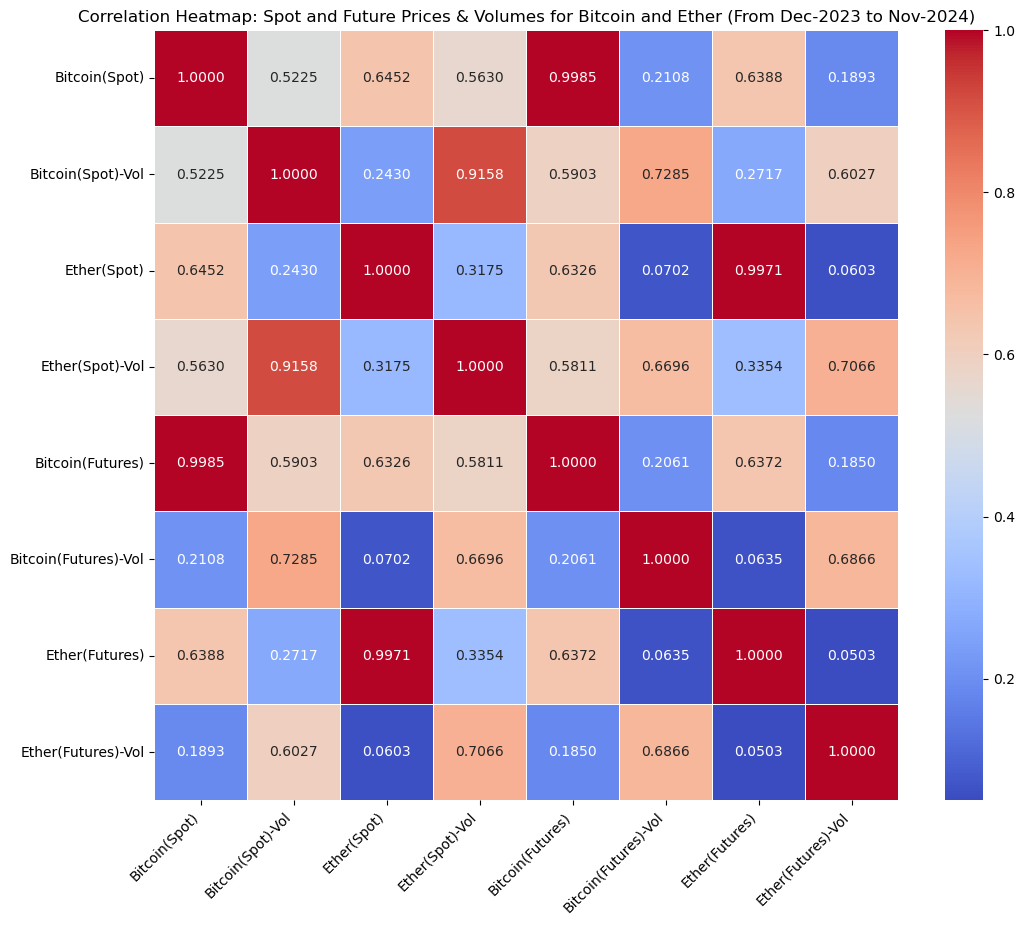

In [98]:
# Cryptocurrency (Spot & Futures)-Correlation Heatmap
# Date Range: Dec 2023 ~ Nov 2024 (1 yrs)
plt.figure(figsize=(12, 10))

heatmap = sns.heatmap(corr_crypto_1yr_full, annot=True,fmt=".4f",cmap='coolwarm', linewidths=0.5)

tick_labels = ["Bitcoin(Spot)", "Bitcoin(Spot)-Vol", "Ether(Spot)", "Ether(Spot)-Vol", 
               "Bitcoin(Futures)", "Bitcoin(Futures)-Vol", "Ether(Futures)", "Ether(Futures)-Vol"]

heatmap.set_xticklabels(tick_labels, rotation=45,ha='right')
heatmap.set_yticklabels(tick_labels, rotation=0)

plt.title('Correlation Heatmap: Spot and Future Prices & Volumes for Bitcoin and Ether (From Dec-2023 to Nov-2024)')

plt.savefig('outputs/heatmap_crypto_spotFutures_1yr.png', dpi=300)

plt.show()

In [99]:
# Calculate the correlation difference
# dataframe 1 = corr_crypto_1yr_full: Dec 2023 ~ Nov 2024
# dataframe 2 = corr_crypto_2yrs_full: Dec 2022 ~ Nov 2024
comparison_matrix_crypto1Yr = compare_correlation(corr_crypto_1yr_full, corr_crypto_2yrs_full)
comparison_matrix_crypto1Yr


close_b volume_b close_eth volume_eth close_b_f volume_b_f  \
close_b         Same      Low       Low        Low       Low        Low   
volume_b         Low     Same       Low        Low       Low       High   
close_eth        Low      Low      Same        Low       Low        Low   
volume_eth       Low      Low       Low       Same       Low       High   
close_b_f        Low      Low       Low        Low      Same        Low   
volume_b_f       Low     High       Low       High       Low       Same   
close_eth_f      Low      Low       Low        Low       Low        Low   
volume_eth_f     Low     High       Low       High       Low        Low   

             close_eth_f volume_eth_f  
close_b              Low          Low  
volume_b             Low         High  
close_eth            Low          Low  
volume_eth           Low         High  
close_b_f            Low          Low  
volume_b_f           Low          Low  
close_eth_f         Same          Low  
volume_eth_f         Low         Same

In [100]:
# Percentage Change in Correlation (Dec 2023 - Nov 2024 vs. Dec 2022 - Nov 2024)/ 1 yrs v.s. 2 yrs
percent_change_fullCrypto_1yr = correlation_change(corr_crypto_1yr_full, corr_crypto_2yrs_full)
percent_change_fullCrypto_1yr

close_b   volume_b  close_eth  volume_eth  close_b_f  \
close_b        0.000000 -13.375906 -29.508657  -21.594874  -0.120125   
volume_b     -13.375906   0.000000 -51.482458   -0.387503 -13.510365   
close_eth    -29.508657 -51.482458   0.000000  -49.754598 -30.664768   
volume_eth   -21.594874  -0.387503 -49.754598    0.000000 -23.523655   
close_b_f     -0.120125 -13.510365 -30.664768  -23.523655   0.000000   
volume_b_f   -34.288137  11.006871 -74.028133   11.671057 -35.563598   
close_eth_f  -30.099501 -52.205240  -0.204825  -50.304839 -30.246590   
volume_eth_f  -1.528847   8.191102 -60.227190   20.101590  -3.389029   

              volume_b_f  close_eth_f  volume_eth_f  
close_b       -34.288137   -30.099501     -1.528847  
volume_b       11.006871   -52.205240      8.191102  
close_eth     -74.028133    -0.204825    -60.227190  
volume_eth     11.671057   -50.304839     20.101590  
close_b_f     -35.563598   -30.246590     -3.389029  
volume_b_f      0.000000   -76.292612     -4.235244  
close_eth_f   -76.292612     0.000000    -65.980483  
volume_eth_f   -4.235244   -65.980483      0.000000

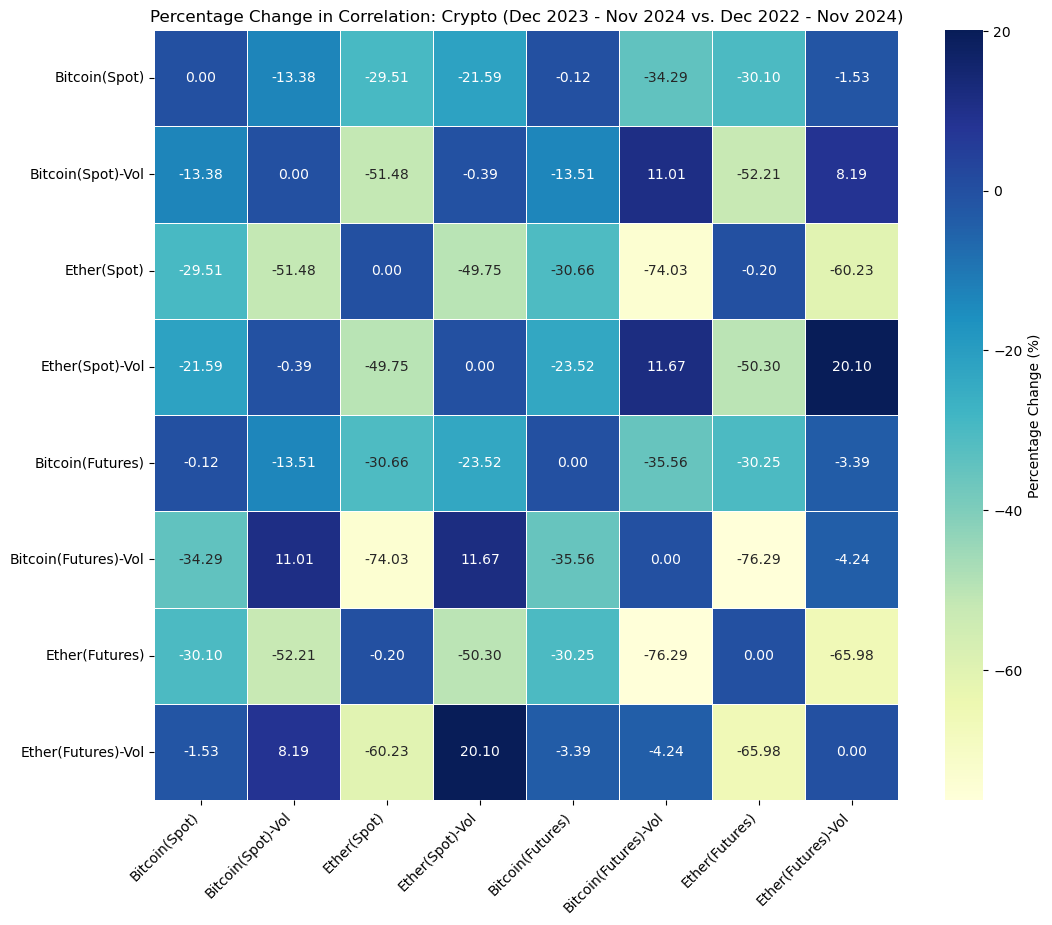

In [101]:
# Percentage Change in Correlation (Dec 2023 - Nov 2024 vs. Dec 2022 - Nov 2024)
plt.figure(figsize=(12, 10))

heatmap = sns.heatmap(percent_change_fullCrypto_1yr, annot=True,fmt=".2f",cmap='YlGnBu', linewidths=0.5,
                     cbar_kws={'label': 'Percentage Change (%)'})

tick_labels = ["Bitcoin(Spot)", "Bitcoin(Spot)-Vol", "Ether(Spot)", "Ether(Spot)-Vol", 
               "Bitcoin(Futures)", "Bitcoin(Futures)-Vol", "Ether(Futures)", "Ether(Futures)-Vol"]

heatmap.set_xticklabels(tick_labels, rotation=45,ha='right')
heatmap.set_yticklabels(tick_labels, rotation=0)

plt.title('Percentage Change in Correlation: Crypto (Dec 2023 - Nov 2024 vs. Dec 2022 - Nov 2024)')

plt.savefig('outputs/heatmap_changeinCorr_crypto_1yrs.png', dpi=300)

plt.show()

In [102]:
crypto_1yr_df = crypto_3yrs_full[(crypto_3yrs_full['date'] >= '2023-12-01')&
                                  (crypto_3yrs_full['date'] <= '2024-11-29')]
crypto_1yr_df.head()

date       close_b     volume_b    close_eth   volume_eth  \
730 2023-12-01  38688.750000  23512784002  2087.139893  10866891430   
731 2023-12-02  39476.332031  15534035612  2165.704102   9130124831   
732 2023-12-03  39978.390625  15769696322  2193.691650   8278465782   
733 2023-12-04  41980.097656  39856129827  2243.215820  16149367134   
734 2023-12-05  44080.648438  36312154535  2293.841797  15383072559   

     close_b_f  volume_b_f  close_eth_f  volume_eth_f  
730    39225.0     11744.0       2118.0        6314.0  
731        NaN         NaN          NaN           NaN  
732        NaN         NaN          NaN           NaN  
733    42280.0     13276.0       2255.0        6640.0  
734    44290.0     10616.0       2292.0        7144.0

In [103]:
crypto_1yr_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 365 entries, 730 to 1094
Data columns (total 9 columns):
 #   Column        Non-Null Count  Dtype         
---  ------        --------------  -----         
 0   date          365 non-null    datetime64[ns]
 1   close_b       365 non-null    float64       
 2   volume_b      365 non-null    int64         
 3   close_eth     365 non-null    float64       
 4   volume_eth    365 non-null    int64         
 5   close_b_f     251 non-null    float64       
 6   volume_b_f    251 non-null    float64       
 7   close_eth_f   251 non-null    float64       
 8   volume_eth_f  251 non-null    float64       
dtypes: datetime64[ns](1), float64(6), int64(2)
memory usage: 28.5 KB


In [104]:
crypto_1yr_df_copy = crypto_1yr_df.copy()
crypto_1yr_df_copy['Year'] = crypto_1yr_df_copy['date'].dt.year
crypto_1yr_df_copy['Month'] = crypto_1yr_df_copy['date'].dt.month
crypto_1yr_df_copy.head()

date       close_b     volume_b    close_eth   volume_eth  \
730 2023-12-01  38688.750000  23512784002  2087.139893  10866891430   
731 2023-12-02  39476.332031  15534035612  2165.704102   9130124831   
732 2023-12-03  39978.390625  15769696322  2193.691650   8278465782   
733 2023-12-04  41980.097656  39856129827  2243.215820  16149367134   
734 2023-12-05  44080.648438  36312154535  2293.841797  15383072559   

     close_b_f  volume_b_f  close_eth_f  volume_eth_f  Year  Month  
730    39225.0     11744.0       2118.0        6314.0  2023     12  
731        NaN         NaN          NaN           NaN  2023     12  
732        NaN         NaN          NaN           NaN  2023     12  
733    42280.0     13276.0       2255.0        6640.0  2023     12  
734    44290.0     10616.0       2292.0        7144.0  2023     12

In [105]:
# Bitcoin Price and Trading Volume (Jan 2024 - Nov 2024)
fig_vol = plot_dual_y_axis(
    df=crypto_1yr_df_copy,
    years=[2024],
    x_column='date',
    primary_y_columns=['close_b'],
    secondary_y_columns=['volume_b'],
    primary_y_label='Bitcoin Price (USD)',
    secondary_y_label='Bitcoin Trading Volume',
    title='Bitcoin Price and Trading Volume (Jan 2024 - Nov 2024)',
    legend_labels=['Price (Spot)', 'Volume']
)

fig_vol.data[1].opacity = 0.5

fig_vol.show()

## 4.2 Cyrptocurrencies v.s. Copper/Aluminum
---
- **Heatmap Visualizations & Hypothesis Testing**
    - **4.2.1 Five-Year Period**: Dec 2019 – Nov 2024  
    - **4.2.2 COVID-19 Period**: Mar 2020 – May 2023  
    - **4.2.3 Post-COVID Period**: Jun 2023 – Nov 2024  

In [106]:
copper_daily = pd.read_csv("resources/copper_daily_f.csv")
alu_daily = pd.read_csv("resources/alu_daily_f.csv")
gold_daily = pd.read_csv("resources/gold_daily_f.csv")

In [107]:
copper_daily.head()

Date    Open    High     Low   Close  Adj Close  Volume
0  2014-12-01  2.8575  2.9405  2.7990  2.9305     2.9305    1035
1  2014-12-02  2.9225  2.9225  2.8775  2.9135     2.9135     246
2  2014-12-03  2.9100  2.9105  2.8870  2.8930     2.8930     440
3  2014-12-04  2.8880  2.9410  2.8880  2.9325     2.9325     564
4  2014-12-05  2.9255  2.9450  2.9215  2.9255     2.9255     408

In [108]:
copper_daily_df = copper_daily[['Date', 'Close', 'Volume']].rename(columns={'Close': 'close_cop', 'Volume': 'volume_cop'})
alu_daily_df = alu_daily[['Date', 'Close', 'Volume']].rename(columns={'Close': 'close_alu', 'Volume': 'volume_alu'})
gold_daily_df = gold_daily[['Date', 'Close', 'Volume']].rename(columns={'Close': 'close_gold', 'Volume': 'volume_gold'})


In [109]:
copper_daily_df = copper_daily[['Date', 'Close', 'Volume']].assign(
        Close=lambda x: x['Close'] * 2204.62).rename(columns={'Close': 'close_cop', 'Volume': 'volume_cop'})
alu_daily_df = alu_daily[['Date', 'Close', 'Volume']].rename(columns={'Close': 'close_alu', 'Volume': 'volume_alu'})
gold_daily_df = gold_daily[['Date', 'Close', 'Volume']].rename(columns={'Close': 'close_gold', 'Volume': 'volume_gold'})


In [110]:
for df in [copper_daily_df, alu_daily_df,gold_daily_df]:
    df['Date'] = pd.to_datetime(df['Date'])

In [111]:
merged_df = pd.merge(copper_daily_df,alu_daily_df, on='Date', how='left')
comm_daily_df = pd.merge(merged_df,gold_daily_df, on='Date', how='left').rename(columns = {"Date":"date"})
comm_daily_df.tail()

date    close_cop  volume_cop  close_alu  volume_alu   close_gold  \
2510 2024-11-22  8981.621619         514    2556.00         0.0  2709.899902   
2511 2024-11-25  9020.202301         335    2580.75         0.0  2616.800049   
2512 2024-11-26  8904.460256       37274    2555.25        14.0  2620.300049   
2513 2024-11-27  8966.189347       11425    2556.50         0.0  2639.899902   
2514 2024-11-29  8995.952188        1274    2562.00        12.0  2657.000000   

      volume_gold  
2510         41.0  
2511         94.0  
2512     177858.0  
2513      61653.0  
2514       3861.0

In [112]:
comm_daily_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2515 entries, 0 to 2514
Data columns (total 7 columns):
 #   Column       Non-Null Count  Dtype         
---  ------       --------------  -----         
 0   date         2515 non-null   datetime64[ns]
 1   close_cop    2515 non-null   float64       
 2   volume_cop   2515 non-null   int64         
 3   close_alu    2479 non-null   float64       
 4   volume_alu   2479 non-null   float64       
 5   close_gold   2514 non-null   float64       
 6   volume_gold  2514 non-null   float64       
dtypes: datetime64[ns](1), float64(5), int64(1)
memory usage: 157.2 KB


In [113]:
# Missing data (Time frame)
# Gold:11-23-2023
# Aluminum: 09-06-2016 ~ 09-28-2016 ; 10-06-2016 ~ 10-27-2016 ; 07-06-2017 ~ 07-10-2017 ; 11-23-2023
comm_daily_df[comm_daily_df['close_alu'].isna()]

date    close_cop  volume_cop  close_alu  volume_alu   close_gold  \
444  2016-09-06  4594.428324         800        NaN         NaN  1349.400024   
445  2016-09-07  4614.269517         478        NaN         NaN  1344.300049   
446  2016-09-08  4620.883423         429        NaN         NaN  1336.800049   
447  2016-09-09  4604.348920         662        NaN         NaN  1330.099976   
448  2016-09-12  4620.883423         357        NaN         NaN  1321.000000   
449  2016-09-13  4619.781193         474        NaN         NaN  1319.000000   
450  2016-09-14  4735.523764         815        NaN         NaN  1321.500000   
451  2016-09-15  4744.342131        1067        NaN         NaN  1313.500000   
452  2016-09-16  4743.239901         418        NaN         NaN  1305.800049   
453  2016-09-19  4737.728224         550        NaN         NaN  1313.500000   
454  2016-09-20  4752.058267         505        NaN         NaN  1313.699951   
455  2016-09-21  4728.909858         484        NaN         NaN  1326.900024   
456  2016-09-22  4822.606250         793        NaN         NaN  1340.400024   
457  2016-09-23  4833.629602         723        NaN         NaN  1337.199951   
458  2016-09-26  4828.117926         745        NaN         NaN  1339.699951   
459  2016-09-27  4765.286080         506        NaN         NaN  1325.900024   
460  2016-09-28  4804.969517         830        NaN         NaN  1319.400024   
466  2016-10-06  4735.523764         223        NaN         NaN  1249.800049   
467  2016-10-07  4754.263253         259        NaN         NaN  1248.900024   
468  2016-10-11  4802.764531         475        NaN         NaN  1253.000000   
469  2016-10-12  4782.923338         191        NaN         NaN  1251.099976   
470  2016-10-13  4662.771321         422        NaN         NaN  1255.000000   
471  2016-10-14  4637.417926         191        NaN         NaN  1253.099976   
472  2016-10-17  4628.599560         279        NaN         NaN  1254.400024   
473  2016-10-18  4625.292869         342        NaN         NaN  1260.800049   
474  2016-10-19  4623.087883         281        NaN         NaN  1267.900024   
475  2016-10-20  4608.758367         188        NaN         NaN  1265.599976   
476  2016-10-21  4593.325568         183        NaN         NaN  1265.900024   
477  2016-10-24  4602.144460         250        NaN         NaN  1262.000000   
478  2016-10-25  4701.352003         420        NaN         NaN  1271.900024   
479  2016-10-26  4716.784276         235        NaN         NaN  1264.800049   
480  2016-10-27  4774.104446         684        NaN         NaN  1267.900024   
651  2017-07-06  5845.549901         593        NaN         NaN  1222.199951   
652  2017-07-07  5814.685355         556        NaN         NaN  1208.599976   
653  2017-07-10  5819.094276         903        NaN         NaN  1212.099976   
2258 2023-11-23  8331.259077         596        NaN         NaN          NaN   

      volume_gold  
444          46.0  
445          14.0  
446          30.0  
447          35.0  
448         177.0  
449          79.0  
450          73.0  
451          37.0  
452           4.0  
453          20.0  
454          97.0  
455          76.0  
456          23.0  
457          40.0  
458          24.0  
459          48.0  
460       10551.0  
466         114.0  
467         169.0  
468          26.0  
469         127.0  
470         315.0  
471         311.0  
472          41.0  
473          11.0  
474         219.0  
475         415.0  
476         224.0  
477          42.0  
478          61.0  
479         279.0  
480         338.0  
651           5.0  
652         116.0  
653          28.0  
2258          NaN

In [114]:
comm_daily_df = comm_daily_df.dropna(subset=['close_alu']).reset_index(drop=True)
comm_daily_df.tail()

date    close_cop  volume_cop  close_alu  volume_alu   close_gold  \
2474 2024-11-22  8981.621619         514    2556.00         0.0  2709.899902   
2475 2024-11-25  9020.202301         335    2580.75         0.0  2616.800049   
2476 2024-11-26  8904.460256       37274    2555.25        14.0  2620.300049   
2477 2024-11-27  8966.189347       11425    2556.50         0.0  2639.899902   
2478 2024-11-29  8995.952188        1274    2562.00        12.0  2657.000000   

      volume_gold  
2474         41.0  
2475         94.0  
2476     177858.0  
2477      61653.0  
2478       3861.0

In [115]:
comm_daily_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2479 entries, 0 to 2478
Data columns (total 7 columns):
 #   Column       Non-Null Count  Dtype         
---  ------       --------------  -----         
 0   date         2479 non-null   datetime64[ns]
 1   close_cop    2479 non-null   float64       
 2   volume_cop   2479 non-null   int64         
 3   close_alu    2479 non-null   float64       
 4   volume_alu   2479 non-null   float64       
 5   close_gold   2479 non-null   float64       
 6   volume_gold  2479 non-null   float64       
dtypes: datetime64[ns](1), float64(5), int64(1)
memory usage: 135.7 KB


In [116]:
comm_daily_df.to_csv("outputs/comm_daily_cleaned_122014_112024.csv", index=True)

### 4.2.1 Five-Year Period: Dec 2019 – Nov 2024  

In [117]:
comm_daily_df_5yr = comm_daily_df[(comm_daily_df['date'] >= '2019-12-01')&
                                  (comm_daily_df['date'] <= '2024-11-29')].reset_index(drop=True)

comm_crypto_df_5yr = pd.merge(comm_daily_df_5yr,crypto_spot_5yr_df, on='date', how='left')
comm_crypto_df_5yr.tail()

date    close_cop  volume_cop  close_alu  volume_alu   close_gold  \
1253 2024-11-22  8981.621619         514    2556.00         0.0  2709.899902   
1254 2024-11-25  9020.202301         335    2580.75         0.0  2616.800049   
1255 2024-11-26  8904.460256       37274    2555.25        14.0  2620.300049   
1256 2024-11-27  8966.189347       11425    2556.50         0.0  2639.899902   
1257 2024-11-29  8995.952188        1274    2562.00        12.0  2657.000000   

      volume_gold       close_b     volume_b    close_eth   volume_eth  
1253         41.0  98997.664062  78473580551  3331.600830  36775716442  
1254         94.0  93102.296875  80909462490  3413.543945  51544793988  
1255     177858.0  91985.320312  91656519855  3326.517334  39902959158  
1256      61653.0  95962.531250  71133452438  3657.249268  43383987191  
1257       3861.0  97461.523438  54968682476  3593.494385  27622629486

In [118]:
corr_comm_crypto_5yr = comm_crypto_df_5yr.drop(columns=['date']).corr()
corr_comm_crypto_5yr

close_cop  volume_cop  close_alu  volume_alu  close_gold  \
close_cop     1.000000    0.015601   0.863313    0.043498    0.467304   
volume_cop    0.015601    1.000000   0.006178    0.069966    0.001070   
close_alu     0.863313    0.006178   1.000000   -0.022535    0.231970   
volume_alu    0.043498    0.069966  -0.022535    1.000000    0.185803   
close_gold    0.467304    0.001070   0.231970    0.185803    1.000000   
volume_gold  -0.007019    0.199996  -0.003192    0.067180   -0.002327   
close_b       0.760446    0.020025   0.546178    0.059156    0.692472   
volume_b      0.086609    0.026058  -0.005615   -0.154459    0.044036   
close_eth     0.856105    0.005506   0.746324    0.046332    0.463479   
volume_eth    0.255817    0.033361   0.144047   -0.173069    0.057312   

             volume_gold   close_b  volume_b  close_eth  volume_eth  
close_cop      -0.007019  0.760446  0.086609   0.856105    0.255817  
volume_cop      0.199996  0.020025  0.026058   0.005506    0.033361  
close_alu      -0.003192  0.546178 -0.005615   0.746324    0.144047  
volume_alu      0.067180  0.059156 -0.154459   0.046332   -0.173069  
close_gold     -0.002327  0.692472  0.044036   0.463479    0.057312  
volume_gold     1.000000  0.012403  0.003336   0.003154    0.009504  
close_b         0.012403  1.000000  0.301565   0.869329    0.384970  
volume_b        0.003336  0.301565  1.000000   0.120308    0.786912  
close_eth       0.003154  0.869329  0.120308   1.000000    0.296513  
volume_eth      0.009504  0.384970  0.786912   0.296513    1.000000

In [119]:
corr_comm_crypto_5yr.iloc[4,3]

0.18580284800316504

In [120]:
# Correlation significance test: five-year period
correlations_comm_crypto_5yr = {'Gold(Futures) v.s. Copper(Futures)': corr_comm_crypto_5yr.iloc[4,0],
                'Gold(Futures) v.s. Aluminum(Futures)': corr_comm_crypto_5yr.iloc[4,2],
               'Gold(Futures) v.s. Aluminum(Futures)-Vol': corr_comm_crypto_5yr.iloc[4,3],
               }

n = len(comm_crypto_df_5yr)

corr_statsig(correlations_comm_crypto_5yr, n)

Gold(Futures) v.s. Copper(Futures):
  Correlation (r): 0.4673
  t-statistic: 18.7325
  p-value: 0.0000
  Significant: Yes
--------------------------------------------------
Gold(Futures) v.s. Aluminum(Futures):
  Correlation (r): 0.2320
  t-statistic: 8.4516
  p-value: 0.0000
  Significant: Yes
--------------------------------------------------
Gold(Futures) v.s. Aluminum(Futures)-Vol:
  Correlation (r): 0.1858
  t-statistic: 6.7016
  p-value: 0.0000
  Significant: Yes
--------------------------------------------------


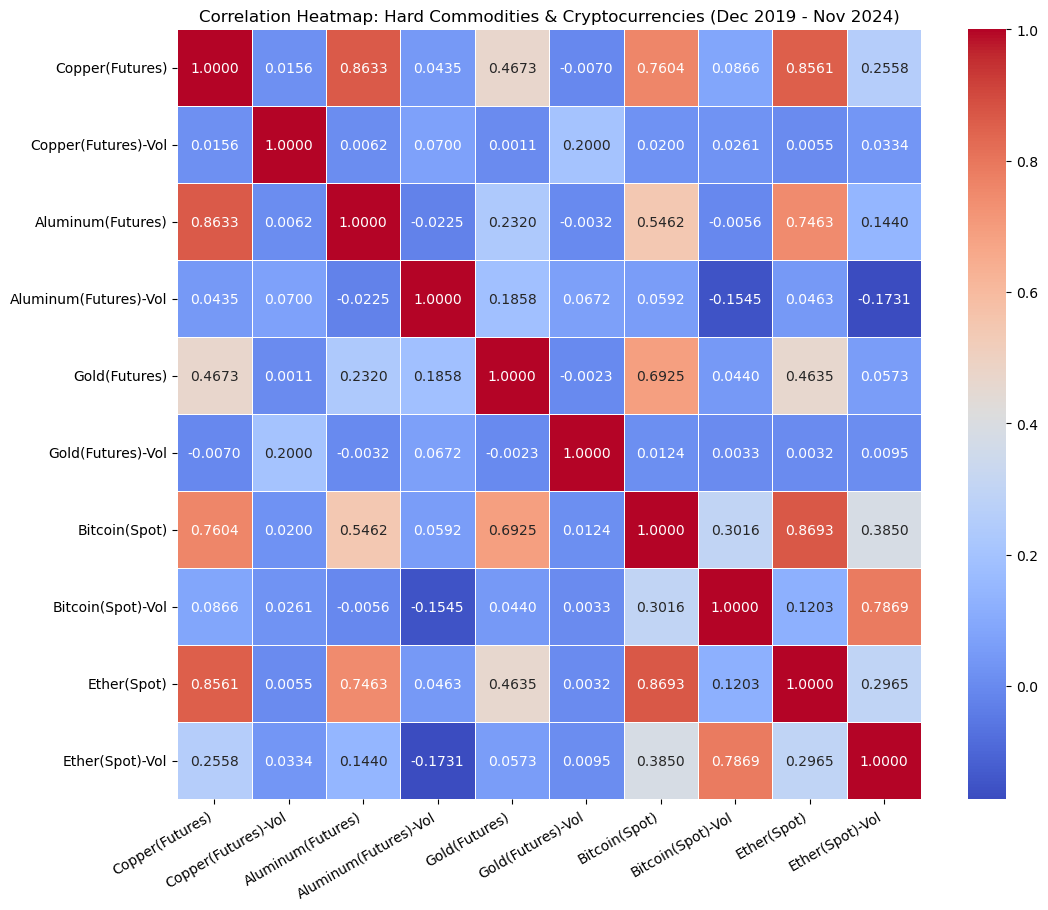

In [121]:
plt.figure(figsize=(12, 10))

heatmap = sns.heatmap(corr_comm_crypto_5yr, annot=True,fmt=".4f",cmap='coolwarm', linewidths=0.5)

tick_labels = ["Copper(Futures)", "Copper(Futures)-Vol", "Aluminum(Futures)", "Aluminum(Futures)-Vol",
               "Gold(Futures)", "Gold(Futures)-Vol",
                "Bitcoin(Spot)", "Bitcoin(Spot)-Vol", "Ether(Spot)", "Ether(Spot)-Vol"]

heatmap.set_xticklabels(tick_labels, rotation=30,ha='right')
heatmap.set_yticklabels(tick_labels, rotation=0)

plt.title('Correlation Heatmap: Hard Commodities & Cryptocurrencies (Dec 2019 - Nov 2024)')

plt.savefig('outputs/heatmap_crypto_comm_5yrs.png', dpi=300)

plt.show()


In [122]:
def plot_comm_vs_factor(comm_value, comm_label, factor_value, factor_label,factor_unit,time_frame, factor_df, comm_df):
  
    fig = go.Figure()

    
    fig.add_trace(go.Scatter(
        x=comm_df['date'], 
        y=comm_df[comm_value], 
        mode='lines', 
        name=comm_label
    ))
        
   
    fig.add_trace(go.Scatter(
        x=comm_df['date'], 
        y=factor_df[factor_value], 
        mode='lines', 
        name=factor_label, 
        yaxis='y2'
    ))

    
 
    date_num = comm_df['date'].map(pd.Timestamp.toordinal)

  
    slope_comm, intercept_comm, *_ = linregress(date_num, comm_df[comm_value])
    comm_trendline = slope_comm * date_num + intercept_comm
    fig.add_trace(go.Scatter(
        x=comm_df['date'], 
        y=comm_trendline, 
        mode='lines', 
        name=f'{comm_label} Trendline', 
        line=dict(dash='dash', color='blue')
    ))

  
    slope_factor, intercept_factor, *_ = linregress(date_num, factor_df[factor_value])
    factor_trendline = slope_factor * date_num + intercept_factor
    fig.add_trace(go.Scatter(
        x=comm_df['date'], 
        y=factor_trendline, 
        mode='lines', 
        name=f'{factor_label} Trendline', 
        line=dict(dash='dash', color='red'),
        yaxis='y2'
    ))

  
    fig.update_layout(
        title=f'{comm_label} with {factor_label} ({time_frame})',
        xaxis_title='Date',
        yaxis=dict(
            title=f'{comm_label}(USD/Metric Ton)',
            titlefont=dict(color='blue'),
            tickfont=dict(color='blue'),
            showgrid=True,
        ),
        yaxis2=dict(
            title=f'{factor_label}({factor_unit})',
            titlefont=dict(color='red'),
            tickfont=dict(color='red'),
            overlaying='y',
            side='right',
            showgrid=False
        ),
        legend=dict(x=1.1, y=1), 
        template='plotly_white',
    )

    fig.show()


    correlation, _ = pearsonr(factor_df[factor_value], comm_df[comm_value])


    print(f"Quick Summary")
    print(f"--------------")
    print(f"The Pearson correlation between {comm_label} and {factor_label} is: {round(correlation, 3)}")
    print(f"The slope of the {comm_label} trendline is: {round(slope_comm, 6)}")
    print(f"The slope of the {factor_label} trendline is: {round(slope_factor, 6)}")

In [123]:
plot_comm_vs_factor(
    comm_value='close_cop', 
    comm_label='Copper Futures Close Price',
    factor_value='close_b', 
    factor_label='Bitcoin Spot Price',
    factor_unit = 'USD',
    time_frame = 'From Dec-2019 to Nov-2024',
    factor_df=comm_crypto_df_5yr, 
    comm_df=comm_crypto_df_5yr
)

Quick Summary
--------------
The Pearson correlation between Copper Futures Close Price and Bitcoin Spot Price is: 0.76
The slope of the Copper Futures Close Price trendline is: 1.516676
The slope of the Bitcoin Spot Price trendline is: 23.021805


In [124]:
plot_comm_vs_factor(
    comm_value='close_cop', 
    comm_label='Copper Futures Close Price',
    factor_value='close_gold', 
    factor_label='Gold Spot Price',
    factor_unit = 'USD/Troy Oz',
    time_frame = 'From Dec-2019 to Nov-2024',
    factor_df=comm_crypto_df_5yr, 
    comm_df=comm_crypto_df_5yr
)

Quick Summary
--------------
The Pearson correlation between Copper Futures Close Price and Gold Spot Price is: 0.467
The slope of the Copper Futures Close Price trendline is: 1.516676
The slope of the Gold Spot Price trendline is: 0.370557


In [125]:
plot_comm_vs_factor(
    comm_value='close_alu', 
    comm_label='Aluminum Futures Close Price',
    factor_value='close_eth', 
    factor_label='Ether Spot Price',
    factor_unit = 'USD',
    time_frame = 'From Dec-2019 to Nov-2024',
    factor_df=comm_crypto_df_5yr, 
    comm_df=comm_crypto_df_5yr
)

Quick Summary
--------------
The Pearson correlation between Aluminum Futures Close Price and Ether Spot Price is: 0.746
The slope of the Aluminum Futures Close Price trendline is: 0.310098
The slope of the Ether Spot Price trendline is: 1.223812


### 4.2.2 COVID-19 Period: Mar 2020 – May 2023  

In [126]:
start_date = '2020-03-01'
end_date = '2023-05-31'

comm_crypto_df_covid = pd.merge(comm_daily_df[(comm_daily_df['date'] >= start_date) & (comm_daily_df['date'] <= end_date)], 
                     crypto_spot_df[(crypto_spot_df['date'] >= start_date) & (crypto_spot_df['date'] <= end_date)], 
                     on='date', how='left')

comm_crypto_df_covid.tail()


date    close_cop  volume_cop  close_alu  volume_alu   close_gold  \
814 2023-05-24  7834.117031         553    2230.00        21.0  1962.800049   
815 2023-05-25  7893.641662         546    2233.25        16.0  1943.099976   
816 2023-05-26  8098.671705         660    2245.00       228.0  1944.099976   
817 2023-05-30  8064.499943        1442    2227.75        39.0  1958.000000   
818 2023-05-31  8004.975313         484    2255.50        18.0  1963.900024   

     volume_gold       close_b     volume_b    close_eth  volume_eth  
814        189.0  26334.818359  16299104428  1800.099976  7101647419  
815          1.0  26476.207031  13851122697  1805.953735  6321689859  
816     166036.0  26719.291016  12711619225  1828.689697  5451414258  
817      37838.0  27702.349609  13251081851  1901.026611  5363439784  
818       5959.0  27219.658203  15656371534  1874.130493  5984512548

In [127]:
corr_comm_crypto_covid = comm_crypto_df_covid.drop(columns=['date']).corr()
corr_comm_crypto_covid

close_cop  volume_cop  close_alu  volume_alu  close_gold  \
close_cop     1.000000    0.028496   0.889736    0.006086    0.323422   
volume_cop    0.028496    1.000000   0.009345    0.055877    0.003661   
close_alu     0.889736    0.009345   1.000000   -0.004184    0.247907   
volume_alu    0.006086    0.055877  -0.004184    1.000000    0.125809   
close_gold    0.323422    0.003661   0.247907    0.125809    1.000000   
volume_gold   0.003147    0.198198  -0.000647    0.147164    0.008763   
close_b       0.808318    0.027440   0.668549   -0.080287    0.076254   
volume_b      0.065414    0.003667  -0.085557   -0.137718   -0.233288   
close_eth     0.851365    0.005204   0.809437   -0.042752    0.123226   
volume_eth    0.279945    0.016385   0.089879   -0.151094   -0.118131   

             volume_gold   close_b  volume_b  close_eth  volume_eth  
close_cop       0.003147  0.808318  0.065414   0.851365    0.279945  
volume_cop      0.198198  0.027440  0.003667   0.005204    0.016385  
close_alu      -0.000647  0.668549 -0.085557   0.809437    0.089879  
volume_alu      0.147164 -0.080287 -0.137718  -0.042752   -0.151094  
close_gold      0.008763  0.076254 -0.233288   0.123226   -0.118131  
volume_gold     1.000000  0.000634 -0.011588  -0.006122    0.002121  
close_b         0.000634  1.000000  0.281753   0.883918    0.458543  
volume_b       -0.011588  0.281753  1.000000   0.055851    0.719196  
close_eth      -0.006122  0.883918  0.055851   1.000000    0.303536  
volume_eth      0.002121  0.458543  0.719196   0.303536    1.000000

In [128]:
# Correlation significance test: COVID-19 period
correlations_comm_crypto_covid = {'Gold(Futures) v.s. Copper(Futures)': corr_comm_crypto_covid.iloc[4,0],
                'Gold(Futures) v.s. Aluminum(Futures)': corr_comm_crypto_covid.iloc[4,2],
               'Gold(Futures) v.s. Bitcoin(Spot)': corr_comm_crypto_covid.iloc[4,6],
                'Gold(Futures) v.s. Ether(Spot)': corr_comm_crypto_covid.iloc[4,8],
               }

n = len(comm_crypto_df_covid)

corr_statsig(correlations_comm_crypto_covid, n)

Gold(Futures) v.s. Copper(Futures):
  Correlation (r): 0.3234
  t-statistic: 9.7695
  p-value: 0.0000
  Significant: Yes
--------------------------------------------------
Gold(Futures) v.s. Aluminum(Futures):
  Correlation (r): 0.2479
  t-statistic: 7.3143
  p-value: 0.0000
  Significant: Yes
--------------------------------------------------
Gold(Futures) v.s. Bitcoin(Spot):
  Correlation (r): 0.0763
  t-statistic: 2.1860
  p-value: 0.0291
  Significant: Yes
--------------------------------------------------
Gold(Futures) v.s. Ether(Spot):
  Correlation (r): 0.1232
  t-statistic: 3.5492
  p-value: 0.0004
  Significant: Yes
--------------------------------------------------


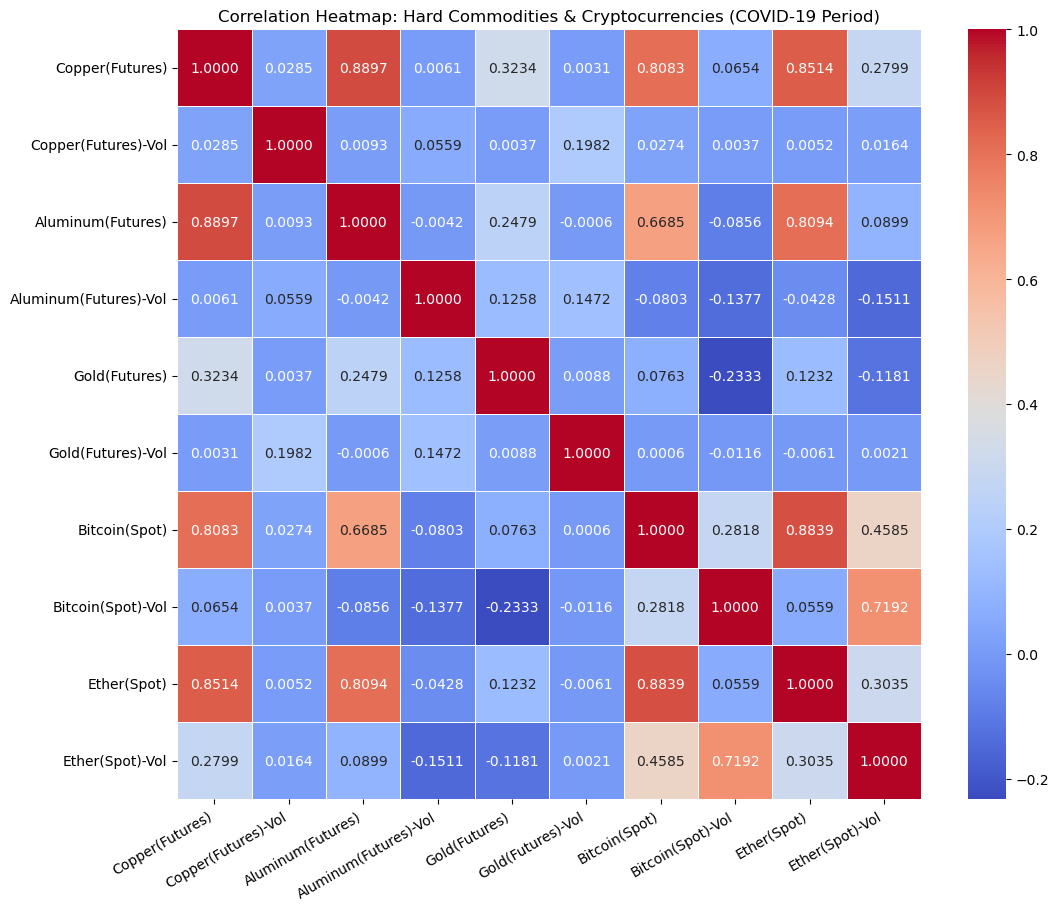

In [129]:
plt.figure(figsize=(12, 10))

heatmap = sns.heatmap(corr_comm_crypto_covid, annot=True,fmt=".4f",cmap='coolwarm', linewidths=0.5)

tick_labels = ["Copper(Futures)", "Copper(Futures)-Vol", "Aluminum(Futures)", "Aluminum(Futures)-Vol",
               "Gold(Futures)", "Gold(Futures)-Vol",
                "Bitcoin(Spot)", "Bitcoin(Spot)-Vol", "Ether(Spot)", "Ether(Spot)-Vol"]

heatmap.set_xticklabels(tick_labels, rotation=30,ha='right')
heatmap.set_yticklabels(tick_labels, rotation=0)

plt.title('Correlation Heatmap: Hard Commodities & Cryptocurrencies (COVID-19 Period)')

plt.savefig('outputs/heatmap_crypto_comm_covid.png', dpi=300)

plt.show()

In [130]:
# Calculate the correlation difference
# dataframe 1 = corr_comm_crypto_covid: Mar 2020 ~ May 2023
# dataframe 2 = corr_comm_crypto_5yr: Nov 2019 ~ Nov 2024
comparison_matrix_commCrypto1 = compare_correlation(corr_comm_crypto_covid, corr_comm_crypto_5yr)
comparison_matrix_commCrypto1

close_cop volume_cop close_alu volume_alu close_gold volume_gold  \
close_cop        Same       High      High        Low        Low        High   
volume_cop       High       Same      High        Low       High         Low   
close_alu        High       High      Same       High       High        High   
volume_alu        Low        Low      High       Same        Low        High   
close_gold        Low       High      High        Low       Same        High   
volume_gold      High        Low      High       High       High        Same   
close_b          High       High      High        Low        Low         Low   
volume_b          Low        Low       Low       High        Low         Low   
close_eth         Low        Low      High        Low        Low         Low   
volume_eth       High        Low       Low       High        Low         Low   

            close_b volume_b close_eth volume_eth  
close_cop      High      Low       Low       High  
volume_cop     High      Low       Low        Low  
close_alu      High      Low      High        Low  
volume_alu      Low     High       Low       High  
close_gold      Low      Low       Low        Low  
volume_gold     Low      Low       Low        Low  
close_b        Same      Low      High       High  
volume_b        Low     Same       Low        Low  
close_eth      High      Low      Same       High  
volume_eth     High      Low      High       Same

In [131]:
comparison_matrix_commCrypto1.to_csv("outputs/matrix_comm_crypto_covid5Yr.csv", index=True)

In [132]:
plot_comm_vs_factor(
    comm_value='close_cop', 
    comm_label='Copper Futures Close Price',
    factor_value='close_b', 
    factor_label='Bitcoin Spot Price',
    factor_unit = 'USD',
    time_frame = 'From Mar-2020 to May-2023',
    factor_df=comm_crypto_df_covid, 
    comm_df=comm_crypto_df_covid,
)

Quick Summary
--------------
The Pearson correlation between Copper Futures Close Price and Bitcoin Spot Price is: 0.808
The slope of the Copper Futures Close Price trendline is: 2.386595
The slope of the Bitcoin Spot Price trendline is: 8.401279


In [133]:
plot_comm_vs_factor(
    comm_value='close_alu', 
    comm_label='Aluminum Futures Close Price',
    factor_value='close_eth', 
    factor_label='Ether Spot Price',
    factor_unit = 'USD',
    time_frame = 'From Mar-2020 to May-2023',
    factor_df=comm_crypto_df_covid, 
    comm_df=comm_crypto_df_covid
)

Quick Summary
--------------
The Pearson correlation between Aluminum Futures Close Price and Ether Spot Price is: 0.809
The slope of the Aluminum Futures Close Price trendline is: 0.834319
The slope of the Ether Spot Price trendline is: 1.338582


### 4.2.3 Post-COVID Period: Jun 2023 – Nov 2024  

In [134]:
start_date = '2023-06-01'
end_date = '2024-11-30'


comm_crypto_df_pcovid = pd.merge(comm_daily_df[(comm_daily_df['date'] >= start_date) & (comm_daily_df['date'] <= end_date)], 
                     crypto_spot_df[(crypto_spot_df['date'] >= start_date) & (crypto_spot_df['date'] <= end_date)], 
                     on='date', how='left')

comm_crypto_df_pcovid.tail()

date    close_cop  volume_cop  close_alu  volume_alu   close_gold  \
373 2024-11-22  8981.621619         514    2556.00         0.0  2709.899902   
374 2024-11-25  9020.202301         335    2580.75         0.0  2616.800049   
375 2024-11-26  8904.460256       37274    2555.25        14.0  2620.300049   
376 2024-11-27  8966.189347       11425    2556.50         0.0  2639.899902   
377 2024-11-29  8995.952188        1274    2562.00        12.0  2657.000000   

     volume_gold       close_b     volume_b    close_eth   volume_eth  
373         41.0  98997.664062  78473580551  3331.600830  36775716442  
374         94.0  93102.296875  80909462490  3413.543945  51544793988  
375     177858.0  91985.320312  91656519855  3326.517334  39902959158  
376      61653.0  95962.531250  71133452438  3657.249268  43383987191  
377       3861.0  97461.523438  54968682476  3593.494385  27622629486

In [135]:
corr_comm_crypto_pcovid = comm_crypto_df_pcovid.drop(columns=['date']).corr()
corr_comm_crypto_pcovid

close_cop  volume_cop  close_alu  volume_alu  close_gold  \
close_cop     1.000000    0.030792   0.841400   -0.206770    0.744542   
volume_cop    0.030792    1.000000   0.046162    0.133706    0.022668   
close_alu     0.841400    0.046162   1.000000   -0.192806    0.783928   
volume_alu   -0.206770    0.133706  -0.192806    1.000000   -0.146373   
close_gold    0.744542    0.022668   0.783928   -0.146373    1.000000   
volume_gold  -0.004711    0.292274   0.008522   -0.001705    0.010545   
close_b       0.707680    0.056017   0.711409   -0.202322    0.853687   
volume_b      0.287633    0.052806   0.363566   -0.134512    0.551393   
close_eth     0.688881    0.055159   0.536901   -0.196204    0.582794   
volume_eth    0.364940    0.036742   0.398364   -0.152817    0.572758   

             volume_gold   close_b  volume_b  close_eth  volume_eth  
close_cop      -0.004711  0.707680  0.287633   0.688881    0.364940  
volume_cop      0.292274  0.056017  0.052806   0.055159    0.036742  
close_alu       0.008522  0.711409  0.363566   0.536901    0.398364  
volume_alu     -0.001705 -0.202322 -0.134512  -0.196204   -0.152817  
close_gold      0.010545  0.853687  0.551393   0.582794    0.572758  
volume_gold     1.000000  0.070956  0.037152   0.077509    0.037963  
close_b         0.070956  1.000000  0.732682   0.873198    0.749052  
volume_b        0.037152  0.732682  1.000000   0.577993    0.939606  
close_eth       0.077509  0.873198  0.577993   1.000000    0.632096  
volume_eth      0.037963  0.749052  0.939606   0.632096    1.000000

In [136]:
# Correlation significance test: Post-COVID period
correlations_comm_crypto_pcovid = {'Gold(Futures) v.s. Copper(Futures)': corr_comm_crypto_pcovid.iloc[4,0],
                'Gold(Futures) v.s. Aluminum(Futures)': corr_comm_crypto_pcovid.iloc[4,2],
               'Gold(Futures) v.s. Bitcoin(Spot)': corr_comm_crypto_pcovid.iloc[4,6],
                'Gold(Futures) v.s. Ether(Spot)': corr_comm_crypto_pcovid.iloc[4,8],
                'Gold(Futures) v.s. Copper(Futures)-Vol': corr_comm_crypto_pcovid.iloc[4,1]
               }

n = len(corr_comm_crypto_pcovid)

corr_statsig(correlations_comm_crypto_pcovid, n)

Gold(Futures) v.s. Copper(Futures):
  Correlation (r): 0.7445
  t-statistic: 3.1545
  p-value: 0.0135
  Significant: Yes
--------------------------------------------------
Gold(Futures) v.s. Aluminum(Futures):
  Correlation (r): 0.7839
  t-statistic: 3.5714
  p-value: 0.0073
  Significant: Yes
--------------------------------------------------
Gold(Futures) v.s. Bitcoin(Spot):
  Correlation (r): 0.8537
  t-statistic: 4.6364
  p-value: 0.0017
  Significant: Yes
--------------------------------------------------
Gold(Futures) v.s. Ether(Spot):
  Correlation (r): 0.5828
  t-statistic: 2.0285
  p-value: 0.0770
  Significant: No
--------------------------------------------------
Gold(Futures) v.s. Copper(Futures)-Vol:
  Correlation (r): 0.0227
  t-statistic: 0.0641
  p-value: 0.9504
  Significant: No
--------------------------------------------------


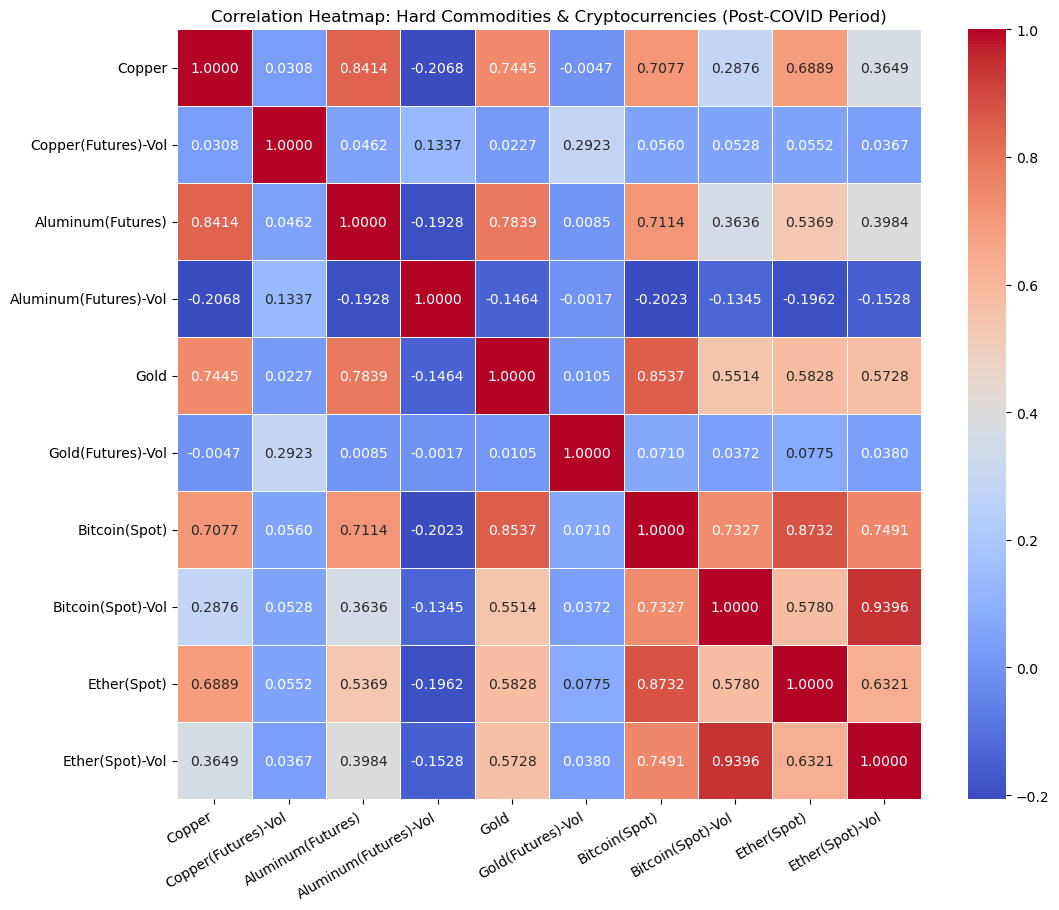

In [137]:
plt.figure(figsize=(12, 10))

heatmap = sns.heatmap(corr_comm_crypto_pcovid, annot=True,fmt=".4f",cmap='coolwarm', linewidths=0.5)

tick_labels = ["Copper", "Copper(Futures)-Vol", "Aluminum(Futures)", "Aluminum(Futures)-Vol",
               "Gold", "Gold(Futures)-Vol",
                "Bitcoin(Spot)", "Bitcoin(Spot)-Vol", "Ether(Spot)", "Ether(Spot)-Vol"]

heatmap.set_xticklabels(tick_labels, rotation=30,ha='right')
heatmap.set_yticklabels(tick_labels, rotation=0)

plt.title('Correlation Heatmap: Hard Commodities & Cryptocurrencies (Post-COVID Period)')

plt.savefig('outputs/heatmap_crypto_comm_postCovid.png', dpi=300)

plt.show()

In [138]:
# Calculate the correlation difference
# dataframe 1 = corr_comm_crypto_pcovid: Jun 2023 ~ Nov 2024
# dataframe 2 = corr_comm_crypto_covid: Mar 2020 ~ May 2023
comparison_matrix_commCrypto2 = compare_correlation(corr_comm_crypto_pcovid, corr_comm_crypto_covid)
comparison_matrix_commCrypto2

close_cop volume_cop close_alu volume_alu close_gold volume_gold  \
close_cop        Same       High       Low        Low       High         Low   
volume_cop       High       Same      High       High       High        High   
close_alu         Low       High      Same        Low       High        High   
volume_alu        Low       High       Low       Same        Low         Low   
close_gold       High       High      High        Low       Same        High   
volume_gold       Low       High      High        Low       High        Same   
close_b           Low       High      High        Low       High        High   
volume_b         High       High      High       High       High        High   
close_eth         Low       High       Low        Low       High        High   
volume_eth       High       High      High        Low       High        High   

            close_b volume_b close_eth volume_eth  
close_cop       Low     High       Low       High  
volume_cop     High     High      High       High  
close_alu      High     High       Low       High  
volume_alu      Low     High       Low        Low  
close_gold     High     High      High       High  
volume_gold    High     High      High       High  
close_b        Same     High       Low       High  
volume_b       High     Same      High       High  
close_eth       Low     High      Same       High  
volume_eth     High     High      High       Same

In [139]:
comparison_matrix_commCrypto2.to_csv("outputs/matrix_comm_crypto_pcovidCovid.csv", index=True)

In [140]:
plot_comm_vs_factor(
    comm_value='close_cop', 
    comm_label='Copper Futures Close Price',
    factor_value='close_b', 
    factor_label='Bitcoin Spot Price',
    factor_unit = 'USD',
    time_frame = 'From Jun-2023 to Nov-2024',
    factor_df=comm_crypto_df_pcovid, 
    comm_df=comm_crypto_df_pcovid
)

Quick Summary
--------------
The Pearson correlation between Copper Futures Close Price and Bitcoin Spot Price is: 0.708
The slope of the Copper Futures Close Price trendline is: 3.2826
The slope of the Bitcoin Spot Price trendline is: 102.009525


In [141]:
plot_comm_vs_factor(
    comm_value='close_alu', 
    comm_label='Aluminum Futures Close Price',
    factor_value='close_eth', 
    factor_label='Ether Spot Price',
    factor_unit = 'USD',
    time_frame = 'From Jun-2023 to Nov-2024',
    factor_df=comm_crypto_df_covid, 
    comm_df=comm_crypto_df_covid
)

Quick Summary
--------------
The Pearson correlation between Aluminum Futures Close Price and Ether Spot Price is: 0.809
The slope of the Aluminum Futures Close Price trendline is: 0.834319
The slope of the Ether Spot Price trendline is: 1.338582


## 4.3 Seasonality 
---
- Analysis Focus:
    - **Period**: December 2021 to November 2024
    - **Metrics Analyzed**:
        1. Average Monthly Values- 
        2. Month-over-Month (MoM) Changes

In [142]:
comm_daily_df_3yr = comm_daily_df[(comm_daily_df['date'] >= '2021-12-01')&
                                  (comm_daily_df['date'] <= '2024-11-29')].reset_index(drop=True)

comm_crypto_df_3yr = pd.merge(comm_daily_df_3yr,crypto_3yrs_full, on='date', how='left')
comm_crypto_df_3yr.head()

date    close_cop  volume_cop  close_alu  volume_alu   close_gold  \
0 2021-12-01  9364.123324        1392    2628.50         0.0  1781.599976   
1 2021-12-02  9477.660909         834    2585.25         0.0  1760.699951   
2 2021-12-03  9406.011222         891    2596.25         0.0  1782.000000   
3 2021-12-06  9561.436705         712    2566.75         0.0  1777.500000   
4 2021-12-07  9563.641165         887    2601.75         0.0  1782.599976   

   volume_gold       close_b     volume_b    close_eth   volume_eth  \
0       1128.0  57229.828125  36858195307  4586.990234  27634826695   
1       1557.0  56477.816406  32379968686  4511.302246  21502671027   
2        694.0  53598.246094  39789134215  4220.706055  25879591528   
3        381.0  50582.625000  37707308001  4358.737305  28229518513   
4        308.0  50700.085938  33676814852  4315.061523  22366213354   

   close_b_f  volume_b_f  close_eth_f  volume_eth_f  
0    56990.0      6552.0      4594.50        5468.0  
1    57175.0      5835.0      4543.25        5197.0  
2    53545.0     11175.0      4214.00        6550.0  
3    48960.0      9344.0      4206.50        4634.0  
4    50600.0      4985.0      4298.50        2832.0

In [143]:
copied_season_df = comm_crypto_df_3yr.copy()

In [144]:
copied_season_df['Year'] = pd.to_datetime(copied_season_df['date']).dt.year
copied_season_df['Month'] = pd.to_datetime(copied_season_df['date']).dt.month
copied_season_df.head()

date    close_cop  volume_cop  close_alu  volume_alu   close_gold  \
0 2021-12-01  9364.123324        1392    2628.50         0.0  1781.599976   
1 2021-12-02  9477.660909         834    2585.25         0.0  1760.699951   
2 2021-12-03  9406.011222         891    2596.25         0.0  1782.000000   
3 2021-12-06  9561.436705         712    2566.75         0.0  1777.500000   
4 2021-12-07  9563.641165         887    2601.75         0.0  1782.599976   

   volume_gold       close_b     volume_b    close_eth   volume_eth  \
0       1128.0  57229.828125  36858195307  4586.990234  27634826695   
1       1557.0  56477.816406  32379968686  4511.302246  21502671027   
2        694.0  53598.246094  39789134215  4220.706055  25879591528   
3        381.0  50582.625000  37707308001  4358.737305  28229518513   
4        308.0  50700.085938  33676814852  4315.061523  22366213354   

   close_b_f  volume_b_f  close_eth_f  volume_eth_f  Year  Month  
0    56990.0      6552.0      4594.50        5468.0  2021     12  
1    57175.0      5835.0      4543.25        5197.0  2021     12  
2    53545.0     11175.0      4214.00        6550.0  2021     12  
3    48960.0      9344.0      4206.50        4634.0  2021     12  
4    50600.0      4985.0      4298.50        2832.0  2021     12

In [145]:
# Commodities: Daily Close Prices - 2024 (Jan-Nov)
fig = plot_dual_y_axis(
    df=copied_season_df,
    years = [2024],
    x_column='date',
    primary_y_columns=['close_cop', 'close_alu'],
    secondary_y_columns=['close_gold'],
    primary_y_label='Copper and Aluminium Prices (USD/Per Metric Ton)',
    secondary_y_label='Gold Prices (USD/Per Troy Ounce)',
    title='Copper, Aluminium, and Gold Futures Close Prices (Jan 2024 - Nov 2024)',
    legend_labels=['Copper', 'Aluminium', 'Gold']
)

In [146]:
def calculate_MoM_change(target_columns, df, agg_function):

    if not all(col in df.columns for col in target_columns):
        raise ValueError("One or more target columns are not in the DataFrame")
    
    if not hasattr(pd.core.groupby.DataFrameGroupBy, agg_function):
        raise ValueError(f"Invalid aggregation function: '{agg_function}'")
        
    seasonal_df = df.groupby(['Year', 'Month'])[target_columns].agg(agg_function).reset_index()
    
    for column in target_columns:
        seasonal_df[f'{column}_MoM'] = seasonal_df[column].pct_change(periods=1) * 100

    return seasonal_df

In [147]:
def plot_monthly_values(variables, seasonal_df, year,title_name,legend_labels=None):


    filtered_df = seasonal_df[seasonal_df['Year'] == year]
    
    if legend_labels is None:
        legend_labels = variables
    elif len(legend_labels) != len(variables):
        raise ValueError("The number of legend_labels must match the number of target_columns.")
    

    fig = go.Figure()
    
    for column, legend_label in zip(variables, legend_labels):
        fig.add_trace(go.Scatter(
            x=filtered_df['Month'],
            y=filtered_df[column],
            mode='lines+markers',
            name=legend_label
        ))
    
    fig.update_layout(
        title=f"Average Monthly Value of {title_name}",
        xaxis=dict(
            title='Month',
            tickmode='linear',
            tick0=1,
            dtick=1
        ),
        yaxis_title='Average Monthly Close Price($)',
        template='plotly_white'
    )
    
    fig.show()

In [148]:
def plot_MoM_pct_change(variables, seasonal_df, year,title_name,legend_labels=None):


    filtered_df = seasonal_df[seasonal_df['Year'] == year]
    
    if legend_labels is None:
        legend_labels = variables
    elif len(legend_labels) != len(variables):
        raise ValueError("The number of legend_labels must match the number of target_columns.")
    

    fig = go.Figure()
    
    for column, legend_label in zip(variables, legend_labels):
        fig.add_trace(go.Scatter(
            x=filtered_df['Month'],
            y=filtered_df[column],
            mode='lines+markers',
            name=legend_label
        ))
    
    fig.update_layout(
        title=f"Month-over-Month (MoM) Percentage Change in {title_name}",
        xaxis=dict(
            title='Month',
            tickmode='linear',
            tick0=1,
            dtick=1
        ),
        yaxis_title='MoM Percentage Change',
        template='plotly_white'
    )
    
    fig.show()

In [149]:
# Commodities MoM percentage change
target_columns = ['close_cop', 'close_alu', 'close_gold']
seasonal_comm = calculate_MoM_change(target_columns, copied_season_df, 'mean')
seasonal_comm.head()

Year  Month     close_cop    close_alu   close_gold  close_cop_MoM  \
0  2021     12   9552.618434  2660.159091  1791.045443            NaN   
1  2022      1   9768.946739  2978.575000  1816.639996       2.264597   
2  2022      2   9925.431356  3267.157895  1857.742091       1.601858   
3  2022      3  10322.653896  3490.173913  1950.673902       4.002068   
4  2022      4  10224.200781  3235.487500  1933.930005      -0.953758   

   close_alu_MoM  close_gold_MoM  
0            NaN             NaN  
1      11.969807        1.429029  
2       9.688623        2.262534  
3       6.825995        5.002407  
4      -7.297241       -0.858365

In [188]:
# Commodities: Average Monthly Futures Prices - 2024 (Jan-Nov)
fig = plot_dual_y_axis(
    df=seasonal_comm,
    years = [2024],
    x_column='Month',
    primary_y_columns=['close_cop', 'close_alu'],
    secondary_y_columns=['close_gold'],
    primary_y_label='Copper and Aluminium Prices (USD/Per Metric Ton)',
    secondary_y_label='Gold Prices (USD/Per Troy Ounce)',
    title='Copper, Aluminium, and Gold Monthly Futures Close Prices (Jan 2024 - Nov 2024)',
    legend_labels=['Copper', 'Aluminium', 'Gold']
)

In [151]:
# Commodities: MoM percentage change - 2023
variables = ['close_cop_MoM', 'close_alu_MoM', 'close_gold_MoM']
legend_labels = ['Copper(Futures)', 'Aluminum(Futures)', 'Gold(Futures)']


plot_MoM_pct_change(
    variables=variables,
    seasonal_df=seasonal_comm,
    year=2023,
    legend_labels=legend_labels,
    title_name="Hard Commodities (2023)"
)

In [152]:
# Commodities - Correlation Table: three years (Dec 2021 - Nov 2024)
seasonal_comm.drop(columns=['Year','Month']).corr()

close_cop  close_alu  close_gold  close_cop_MoM  \
close_cop        1.000000   0.712023    0.472770       0.286836   
close_alu        0.712023   1.000000   -0.061792       0.103852   
close_gold       0.472770  -0.061792    1.000000       0.109501   
close_cop_MoM    0.286836   0.103852    0.109501       1.000000   
close_alu_MoM    0.250810   0.243443    0.201421       0.646723   
close_gold_MoM   0.316770   0.095432    0.348513       0.704367   

                close_alu_MoM  close_gold_MoM  
close_cop            0.250810        0.316770  
close_alu            0.243443        0.095432  
close_gold           0.201421        0.348513  
close_cop_MoM        0.646723        0.704367  
close_alu_MoM        1.000000        0.659650  
close_gold_MoM       0.659650        1.000000

In [153]:
# Commodities - Correlation Table: target year
seasonal_comm[seasonal_comm['Year'] == 2022].drop(columns=['Year','Month']).corr()

close_cop  close_alu  close_gold  close_cop_MoM  \
close_cop        1.000000   0.952133    0.932649       0.251968   
close_alu        0.952133   1.000000    0.912607       0.178306   
close_gold       0.932649   0.912607    1.000000       0.167920   
close_cop_MoM    0.251968   0.178306    0.167920       1.000000   
close_alu_MoM    0.242570   0.319007    0.077945       0.633402   
close_gold_MoM   0.367260   0.351142    0.355996       0.872308   

                close_alu_MoM  close_gold_MoM  
close_cop            0.242570        0.367260  
close_alu            0.319007        0.351142  
close_gold           0.077945        0.355996  
close_cop_MoM        0.633402        0.872308  
close_alu_MoM        1.000000        0.750908  
close_gold_MoM       0.750908        1.000000

In [154]:
# Cryptocurrencies MoM change
target_columns = ['close_b', 'close_eth', 'close_b_f','close_eth_f']
seasonal_crypto = calculate_MoM_change(target_columns, copied_season_df, 'mean')
seasonal_crypto.head()

Year  Month       close_b    close_eth     close_b_f  close_eth_f  \
0  2021     12  49250.533026  4034.461659  49537.819602  4055.234086   
1  2022      1  40998.242773  3040.539648  41080.544531  3050.703503   
2  2022      2  41086.207442  2898.262181  41031.688939  2888.894210   
3  2022      3  42244.318274  2896.155327  42244.521739  2899.015222   
4  2022      4  41419.073242  3089.012427  41461.866992  3093.923999   

   close_b_MoM  close_eth_MoM  close_b_f_MoM  close_eth_f_MoM  
0          NaN            NaN            NaN              NaN  
1   -16.755738     -24.635803     -17.072360       -24.771211  
2     0.214557      -4.679349      -0.118926        -5.303999  
3     2.818734      -0.072694       2.955844         0.350342  
4    -1.953505       6.659073      -1.852677         6.723275

In [155]:
# Cryptocurrencies: Average Monthly Futures Prices - 2024 (Jan-Nov)

variables = ['close_b', 'close_eth']
legend_labels = ['Bitcoin(Spot)', 'Ether(Spot)']


plot_monthly_values(
    variables=variables,
    seasonal_df=seasonal_crypto,
    year=2024,
    legend_labels=legend_labels,
    title_name="Cryptocurrencies Spot Price"
)

In [156]:
# Commodities: MoM percentage change - 2024 (Jan-Nov)
variables = ['close_b_MoM', 'close_eth_MoM']
legend_labels = ['Bitcoin(Spot)', 'Ether(Spot)']

plot_MoM_pct_change(
    variables=variables,
    seasonal_df=seasonal_crypto,
    year=2024,
    legend_labels=legend_labels,
    title_name="Cryptocurrencies(Jan 2024 - Nov 2024)"
)

In [157]:
# Volume(Cryptocurrencies[SPOT] & Hard Commodities) MoM change
target_columns = ['volume_b', 'volume_eth', 'volume_cop','volume_alu','volume_gold','volume_b_f','volume_eth_f']
seasonal_vol = calculate_MoM_change(target_columns, copied_season_df, 'sum')
seasonal_vol.tail(12)

Year  Month       volume_b    volume_eth  volume_cop  volume_alu  \
24  2023     12   543101483723  262744415795       15971       454.0   
25  2024      1   662412726857  292368766644        9910       762.0   
26  2024      2   679481873402  329721063279       39340       426.0   
27  2024      3  1133065238711  518587891682       18033       343.0   
28  2024      4   792471815914  363861059125       77579       179.0   
29  2024      5   714798266448  403186305896       19419        67.0   
30  2024      6   570705037243  295302220502       43154       404.0   
31  2024      7   733361962437  386683039569       14837       231.0   
32  2024      8   857095910974  430158687713       38667       531.0   
33  2024      9   690986052300  328297026402       13126       911.0   
34  2024     10   861000381596  419196098826       12343       108.0   
35  2024     11  1620471627116  743225466715       58494       270.0   

    volume_gold  volume_b_f  volume_eth_f  volume_b_MoM  volume_eth_MoM  \
24       8723.0    181400.0      104836.0     17.667028        6.414596   
25     184110.0    264258.0      124005.0     21.968499       11.274969   
26      10440.0    208644.0      103853.0      2.576814       12.775748   
27     241903.0    255080.0       90127.0     66.754300       57.280790   
28       8117.0    224665.0       78819.0    -30.059472      -29.836183   
29     154217.0    188178.0      101418.0     -9.801427       10.807765   
30       7958.0    171196.0       83139.0    -20.158587      -26.757874   
31     155434.0    220878.0      100217.0     28.501050       30.944847   
32      12103.0    250529.0       89872.0     16.872152       11.243226   
33      24007.0    220696.0       75428.0    -19.380545      -23.680020   
34       4495.0    231714.0       97890.0     24.604596       27.688058   
35     246317.0    303395.0      165221.0     88.208003       77.297801   

    volume_cop_MoM  volume_alu_MoM  volume_gold_MoM  volume_b_f_MoM  \
24      -68.172579        1.793722       -95.637737      -16.505569   
25      -37.950034       67.841410      2010.627078       45.676957   
26      296.972755      -44.094488       -94.329477      -21.045342   
27      -54.161159      -19.483568      2217.078544       22.256092   
28      330.205734      -47.813411       -96.644523      -11.923710   
29      -74.968742      -62.569832      1799.926081      -16.240625   
30      122.225655      502.985075       -94.839739       -9.024434   
31      -65.618483      -42.821782      1853.179191       29.020538   
32      160.611984      129.870130       -92.213415       13.424153   
33      -66.053741       71.563089        98.355780      -11.908003   
34       -5.965260      -88.144896       -81.276294        4.992388   
35      373.904237      150.000000      5379.799778       30.935118   

    volume_eth_f_MoM  
24        -13.992009  
25         18.284750  
26        -16.250958  
27        -13.216758  
28        -12.546740  
29         28.672021  
30        -18.023428  
31         20.541503  
32        -10.322600  
33        -16.071746  
34         29.779392  
35         68.782307

In [158]:
test_corr_vol = seasonal_vol[seasonal_vol['Year'] == 2024].drop(columns=['Year','Month']).corr()
test_corr_vol

volume_b  volume_eth  volume_cop  volume_alu  volume_gold  \
volume_b          1.000000    0.982095    0.307863   -0.250476     0.601588   
volume_eth        0.982095    1.000000    0.278277   -0.351626     0.600500   
volume_cop        0.307863    0.278277    1.000000   -0.282737    -0.214209   
volume_alu       -0.250476   -0.351626   -0.282737    1.000000    -0.111127   
volume_gold       0.601588    0.600500   -0.214209   -0.111127     1.000000   
volume_b_f        0.791385    0.709095    0.092443    0.152952     0.566813   
volume_eth_f      0.693391    0.682149    0.113499   -0.121649     0.643399   
volume_b_MoM      0.840087    0.822984   -0.112831   -0.148830     0.754884   
volume_eth_MoM    0.803336    0.820576   -0.154719   -0.308128     0.753017   
volume_cop_MoM    0.400437    0.355765    0.907184   -0.180347    -0.203038   
volume_alu_MoM   -0.057841   -0.067509    0.241811    0.300407    -0.143054   
volume_gold_MoM   0.787971    0.791828    0.036903   -0.161176     0.902615   
volume_b_f_MoM    0.439172    0.388601   -0.265377    0.153045     0.684973   
volume_eth_f_MoM  0.614267    0.661784   -0.048629   -0.394277     0.575543   

                  volume_b_f  volume_eth_f  volume_b_MoM  volume_eth_MoM  \
volume_b            0.791385      0.693391      0.840087        0.803336   
volume_eth          0.709095      0.682149      0.822984        0.820576   
volume_cop          0.092443      0.113499     -0.112831       -0.154719   
volume_alu          0.152952     -0.121649     -0.148830       -0.308128   
volume_gold         0.566813      0.643399      0.754884        0.753017   
volume_b_f          1.000000      0.683079      0.796206        0.693571   
volume_eth_f        0.683079      1.000000      0.719754        0.723662   
volume_b_MoM        0.796206      0.719754      1.000000        0.965693   
volume_eth_MoM      0.693571      0.723662      0.965693        1.000000   
volume_cop_MoM      0.252658      0.339915      0.069045        0.037918   
volume_alu_MoM     -0.180563      0.009832     -0.110993       -0.262303   
volume_gold_MoM     0.668710      0.854011      0.792412        0.784234   
volume_b_f_MoM      0.743782      0.573016      0.729911        0.615300   
volume_eth_f_MoM    0.518722      0.840943      0.601111        0.663966   

                  volume_cop_MoM  volume_alu_MoM  volume_gold_MoM  \
volume_b                0.400437       -0.057841         0.787971   
volume_eth              0.355765       -0.067509         0.791828   
volume_cop              0.907184        0.241811         0.036903   
volume_alu             -0.180347        0.300407        -0.161176   
volume_gold            -0.203038       -0.143054         0.902615   
volume_b_f              0.252658       -0.180563         0.668710   
volume_eth_f            0.339915        0.009832         0.854011   
volume_b_MoM            0.069045       -0.110993         0.792412   
volume_eth_MoM          0.037918       -0.262303         0.784234   
volume_cop_MoM          1.000000        0.189656         0.105263   
volume_alu_MoM          0.189656        1.000000        -0.018067   
volume_gold_MoM         0.105263       -0.018067         1.000000   
volume_b_f_MoM         -0.181143        0.005608         0.627232   
volume_eth_f_MoM        0.064878       -0.172407         0.776939   

                  volume_b_f_MoM  volume_eth_f_MoM  
volume_b                0.439172          0.614267  
volume_eth              0.388601          0.661784  
volume_cop             -0.265377         -0.048629  
volume_alu              0.153045         -0.394277  
volume_gold             0.684973          0.575543  
volume_b_f              0.743782          0.518722  
volume_eth_f            0.573016          0.840943  
volume_b_MoM            0.729911          0.601111  
volume_eth_MoM          0.615300          0.663966  
volume_cop_MoM         -0.181143          0.064878  
volume_alu_MoM          0.005608         -0.172407  
volume_gold_MoM    

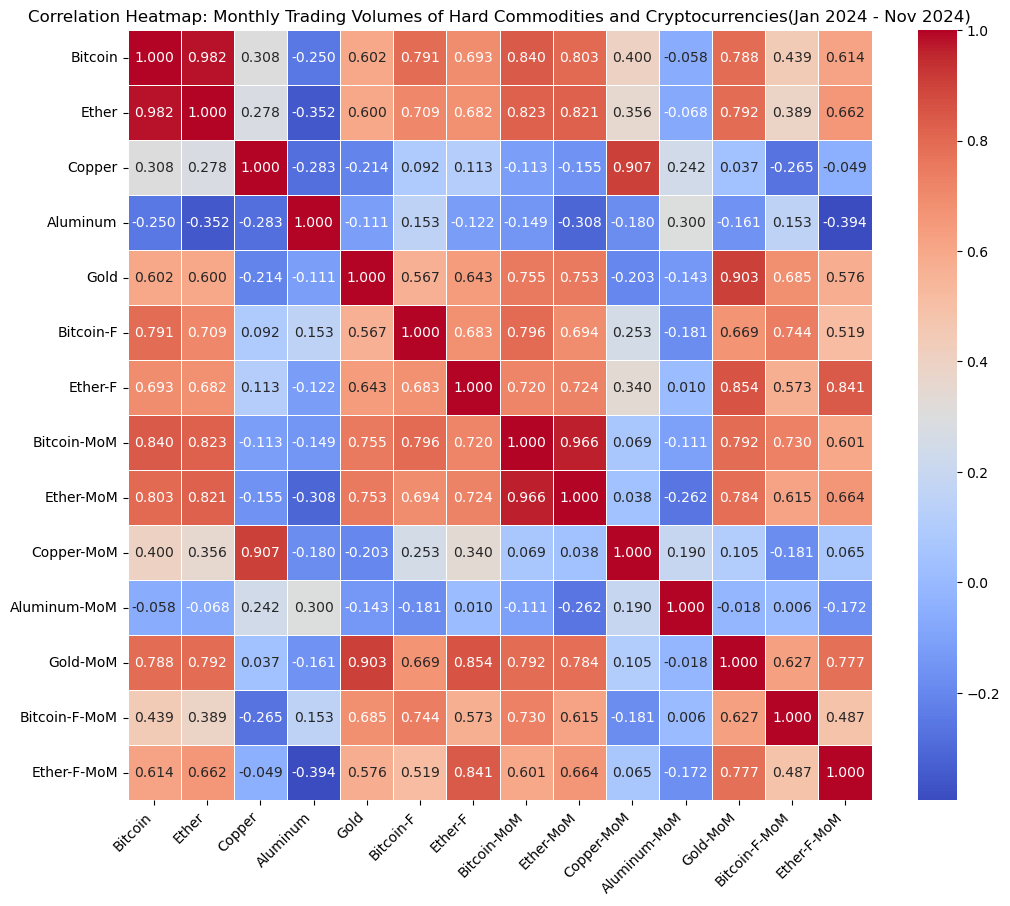

In [189]:
plt.figure(figsize=(12, 10))
heatmap = sns.heatmap(test_corr_vol, annot=True, fmt=".3f", cmap='coolwarm', linewidths=0.5)

tick_labels = ["Bitcoin","Ether","Copper", "Aluminum", "Gold","Bitcoin-F","Ether-F",
              "Bitcoin-MoM","Ether-MoM","Copper-MoM", "Aluminum-MoM", "Gold-MoM","Bitcoin-F-MoM","Ether-F-MoM"]
heatmap.set_xticklabels(tick_labels, rotation=45,ha='right')
heatmap.set_yticklabels(tick_labels, rotation=0)

plt.title('Correlation Heatmap: Monthly Trading Volumes of Hard Commodities and Cryptocurrencies(Jan 2024 - Nov 2024)')

plt.savefig('outputs/heatmap_tradingVolumes.png')

plt.show()

In [160]:
# Volume MoM change - 2024 (Jan-Nov)
variables = ['volume_b_MoM', 'volume_eth_MoM']
legend_labels = ['Bitcoin(Spot)-Volume', 'Ether(Spot)-Volume',]


plot_MoM_pct_change(
    variables=variables,
    seasonal_df=seasonal_vol,
    year=2024,
    legend_labels=legend_labels,
    title_name="Volume(Cryptocurrencies)"
)

In [190]:
# Volume: MoM percentage change - 2024 (Jan-Nov)

# variables = ['volume_cop_MoM']
# legend_labels = ['Aluminum(Futures)-Volume']

# variables = ['volume_cop_MoM','volume_alu_MoM']
# legend_labels = ['Copper(Futures)-Volume','Aluminum(Futures)-Volume']

# variables = ['volume_cop_MoM','volume_alu_MoM','volume_gold_MoM','volume_b_MoM']
# legend_labels = ['Copper(Futures)-Volume','Aluminum(Futures)-Volume','Gold(Futures)-Volume','Bitcoin(Spot)-Volume']

variables = ['volume_gold_MoM','volume_b_MoM']
legend_labels = ['Gold(Futures)-Volume','Bitcoin(Spot)-Volume']

# variables = ['volume_alu_MoM','volume_gold_MoM','volume_b_MoM']
# legend_labels = ['Alu(Futures)-Volume','Gold(Futures)-Volume','Bitcoin(Futures)-Volume']


plot_MoM_pct_change(
    variables=variables,
    seasonal_df=seasonal_vol,
    year=2024,
    legend_labels=legend_labels,
    title_name="Volume"
)

In [162]:
variables = ['volume_cop_MoM','volume_alu_MoM','volume_gold_MoM','volume_b_f_MoM']
legend_labels = ['Copper(Futures)-Volume','Aluminum(Futures)-Volume','Gold(Futures)-Volume','Bitcoin(Spot)-Volume']

plot_MoM_pct_change(
    variables=variables,
    seasonal_df=seasonal_vol,
    year=2024,
    legend_labels=legend_labels,
    title_name="Volume"
)

# 5. Supporting Data Analysis  
---  
- **5.1 Variance Test**: Significant differences in variances between copper and aluminum prices  
- **5.2 Histograms**: Copper & Aluminum prices over the past decade  
- **5.3 US Housing Data**: Rent estimates and growth trends  

## 5.1 Variance Test

In [163]:
# Variance Test: Significant Difference Between Copper and Aluminum Prices (Past Decade)
var_copper = np.var(cpi_cop_alu_df['copper_value'], ddof=1)
var_aluminum = np.var(cpi_cop_alu_df['alu_value'], ddof=1)


F_statistic = var_copper / var_aluminum


df_copper = len(cpi_cop_alu_df) - 1
df_aluminum = df_copper

alpha = 0.05


lower_critical_value = f.ppf(alpha / 2, df_copper, df_aluminum)
upper_critical_value = f.ppf(1 - alpha / 2, df_copper, df_aluminum)


print(f"F-statistic: {F_statistic}")
print(f"Lower critical value: {lower_critical_value}")
print(f"Upper critical value: {upper_critical_value}")

if F_statistic < lower_critical_value or F_statistic > upper_critical_value:
    print("Reject the null hypothesis: Variances are significantly different.")
else:
    print("Fail to reject the null hypothesis: Variances are not significantly different.")


F-statistic: 16.462577787114633
Lower critical value: 0.6969327270745552
Upper critical value: 1.4348587190009001
Reject the null hypothesis: Variances are significantly different.


In [164]:
# Variance Test: Significant Difference Between Copper and Aluminum Prices (COVID Period)
var_copper = np.var(cpi_cop_alu_covid['copper_value'], ddof=1)
var_aluminum = np.var(cpi_cop_alu_covid['alu_value'], ddof=1)


F_statistic = var_copper / var_aluminum


df_copper = len(cpi_cop_alu_covid) - 1
df_aluminum = df_copper

alpha = 0.05

lower_critical_value = f.ppf(alpha / 2, df_copper, df_aluminum)
upper_critical_value = f.ppf(1 - alpha / 2, df_copper, df_aluminum)

print(f"F-statistic: {F_statistic}")
print(f"Lower critical value: {lower_critical_value}")
print(f"Upper critical value: {upper_critical_value}")

if F_statistic < lower_critical_value or F_statistic > upper_critical_value:
    print("Reject the null hypothesis: Variances are significantly different.")
else:
    print("Fail to reject the null hypothesis: Variances are not significantly different.")


F-statistic: 8.881472832264187
Lower critical value: 0.5243828442919567
Upper critical value: 1.9070036536955
Reject the null hypothesis: Variances are significantly different.


In [165]:
# Variance Test: if copper's variance is significant higher than aluminum prices (COVID Period)
var_copper = np.var(cpi_cop_alu_covid['copper_value'], ddof=1)
var_aluminum = np.var(cpi_cop_alu_covid['alu_value'], ddof=1)

F_statistic = var_copper / var_aluminum

df_copper = len(cpi_cop_alu_covid) - 1
df_aluminum = df_copper

alpha = 0.05


upper_critical_value = f.ppf(1 - alpha, df_copper, df_aluminum)


print(f"F-statistic: {F_statistic}")
print(f"Critical value: {upper_critical_value}")


if F_statistic > upper_critical_value:
    print("Reject the null hypothesis: Variance of copper is significantly higher than that of aluminum.")
else:
    print("Fail to reject the null hypothesis: Variance of copper is not significantly higher than that of aluminum.")

F-statistic: 8.881472832264187
Critical value: 1.7166871444419058
Reject the null hypothesis: Variance of copper is significantly higher than that of aluminum.


## 5.2 Histograms

In [166]:
# Copper prices (Past Decade) 
fig = px.histogram(
    cpi_cop_alu_df,
    x='copper_value',
    nbins=30, 
    title='Histogram of Copper Prices',
    template='plotly_white'
)


fig.update_layout(
    xaxis_title="Copper Price",
    yaxis_title="Frequency",
    bargap=0.1
)

fig.show()

In [167]:
# Aluminum prices (Past Decade)
fig = px.histogram(
    cpi_cop_alu_df,
    x='alu_value',
    nbins=30, 
    title='Histogram of Aluminum Prices',
    template='plotly_white'
)


fig.update_layout(
    xaxis_title="Copper Price",
    yaxis_title="Frequency",
    bargap=0.1
)

fig.show()

## 5.3 US Housing Data  
---  
- **Data Type**:  
    - Rent Estimate  
    - Rent Growth  
- **Data Source**:  
    - [Apartment List](https://www.apartmentlist.com/research/category/data-rent-estimates)  

In [168]:
rent_df = pd.read_csv('resources/historical_rent_estimates.txt', delimiter=',')

In [169]:
rent_df = rent_df[rent_df["bed_size"] == "overall"]
rent_df.head()

location_name location_type  location_fips_code  population       state  \
0   United States      National                   0   331097593         NaN   
3      California         State                   6    39356104  California   
6           Texas         State                  48    29243342       Texas   
9         Florida         State                  12    21634529     Florida   
12       New York         State                  36    19994379    New York   

   county metro bed_size  2017_01  2017_02  ...  2024_02  2024_03  2024_04  \
0     NaN   NaN  overall   1070.0   1071.0  ...     1380     1389     1397   
3     NaN   NaN  overall   1740.0   1745.0  ...     2119     2135     2146   
6     NaN   NaN  overall   1054.0   1051.0  ...     1287     1290     1292   
9     NaN   NaN  overall   1074.0   1076.0  ...     1543     1550     1555   
12    NaN   NaN  overall   1429.0   1423.0  ...     1808     1826     1843   

    2024_05  2024_06  2024_07  2024_08  2024_09  2024_10  2024_11  
0      1404     1410     1413     1411     1404     1394     1382  
3      2154     2163     2170     2174     2168     2156     2142  
6      1295     1296     1297     1293     1286     1276     1266  
9      1558     1558     1555     1551     1543     1537     1529  
12     1867     1883     1892     1888     1874     1853     1840  

[5 rows x 103 columns]

In [170]:
rent_df_state = rent_df[rent_df["location_type"].isin(['National', 'State'])]
rent_df_state.head()

location_name location_type  location_fips_code  population       state  \
0   United States      National                   0   331097593         NaN   
3      California         State                   6    39356104  California   
6           Texas         State                  48    29243342       Texas   
9         Florida         State                  12    21634529     Florida   
12       New York         State                  36    19994379    New York   

   county metro bed_size  2017_01  2017_02  ...  2024_02  2024_03  2024_04  \
0     NaN   NaN  overall   1070.0   1071.0  ...     1380     1389     1397   
3     NaN   NaN  overall   1740.0   1745.0  ...     2119     2135     2146   
6     NaN   NaN  overall   1054.0   1051.0  ...     1287     1290     1292   
9     NaN   NaN  overall   1074.0   1076.0  ...     1543     1550     1555   
12    NaN   NaN  overall   1429.0   1423.0  ...     1808     1826     1843   

    2024_05  2024_06  2024_07  2024_08  2024_09  2024_10  2024_11  
0      1404     1410     1413     1411     1404     1394     1382  
3      2154     2163     2170     2174     2168     2156     2142  
6      1295     1296     1297     1293     1286     1276     1266  
9      1558     1558     1555     1551     1543     1537     1529  
12     1867     1883     1892     1888     1874     1853     1840  

[5 rows x 103 columns]

In [171]:
# Note: Maine,Vermont, West virginia, are three missed states and remove District of Columbia
print(rent_df_state[rent_df_state["location_type"]=="State"]["location_name"].unique())

['California' 'Texas' 'Florida' 'New York' 'Pennsylvania' 'Illinois'
 'Ohio' 'Georgia' 'North Carolina' 'Michigan' 'New Jersey' 'Virginia'
 'Washington' 'Arizona' 'Massachusetts' 'Tennessee' 'Indiana' 'Maryland'
 'Missouri' 'Wisconsin' 'Colorado' 'Minnesota' 'South Carolina' 'Alabama'
 'Louisiana' 'Kentucky' 'Oregon' 'Oklahoma' 'Connecticut' 'Utah' 'Iowa'
 'Nevada' 'Arkansas' 'Mississippi' 'Kansas' 'New Mexico' 'Nebraska'
 'Idaho' 'Hawaii' 'New Hampshire' 'Rhode Island' 'Montana' 'Delaware'
 'South Dakota' 'North Dakota' 'Alaska' 'District of Columbia' 'Wyoming']


In [172]:
rent_state_f = rent_df_state[rent_df_state['location_name'] != 'District of Columbia']
rent_state_f.head()

location_name location_type  location_fips_code  population       state  \
0   United States      National                   0   331097593         NaN   
3      California         State                   6    39356104  California   
6           Texas         State                  48    29243342       Texas   
9         Florida         State                  12    21634529     Florida   
12       New York         State                  36    19994379    New York   

   county metro bed_size  2017_01  2017_02  ...  2024_02  2024_03  2024_04  \
0     NaN   NaN  overall   1070.0   1071.0  ...     1380     1389     1397   
3     NaN   NaN  overall   1740.0   1745.0  ...     2119     2135     2146   
6     NaN   NaN  overall   1054.0   1051.0  ...     1287     1290     1292   
9     NaN   NaN  overall   1074.0   1076.0  ...     1543     1550     1555   
12    NaN   NaN  overall   1429.0   1423.0  ...     1808     1826     1843   

    2024_05  2024_06  2024_07  2024_08  2024_09  2024_10  2024_11  
0      1404     1410     1413     1411     1404     1394     1382  
3      2154     2163     2170     2174     2168     2156     2142  
6      1295     1296     1297     1293     1286     1276     1266  
9      1558     1558     1555     1551     1543     1537     1529  
12     1867     1883     1892     1888     1874     1853     1840  

[5 rows x 103 columns]

In [173]:
rent_df_long = rent_state_f.melt(
    id_vars=['location_name', 'location_type', 'location_fips_code', 'population', 'state', 'county', 'metro', 'bed_size'],
    var_name='year_month', 
    value_name='rent_amount'
)

final_rent_df = rent_df_long[
    ['location_name', 'location_type', 'location_fips_code', 'population', 
     'state', 'county', 'metro', 'bed_size', 'year_month', 'rent_amount']
]


final_rent_df['date'] = pd.to_datetime(final_rent_df['year_month'] + '_01', format='%Y_%m_%d')

final_rent_df = final_rent_df.drop(columns=['year_month'])


In [174]:
final_rent_df.tail()

location_name location_type  location_fips_code  population  \
4555      Delaware         State                  10      993635   
4556  South Dakota         State                  46      890342   
4557  North Dakota         State                  38      776874   
4558        Alaska         State                   2      734821   
4559       Wyoming         State                  56      577929   

             state county metro bed_size  rent_amount       date  
4555      Delaware    NaN   NaN  overall       1484.0 2024-11-01  
4556  South Dakota    NaN   NaN  overall        869.0 2024-11-01  
4557  North Dakota    NaN   NaN  overall       1105.0 2024-11-01  
4558        Alaska    NaN   NaN  overall       1599.0 2024-11-01  
4559       Wyoming    NaN   NaN  overall       1122.0 2024-11-01

In [175]:
final_rent_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4560 entries, 0 to 4559
Data columns (total 10 columns):
 #   Column              Non-Null Count  Dtype         
---  ------              --------------  -----         
 0   location_name       4560 non-null   object        
 1   location_type       4560 non-null   object        
 2   location_fips_code  4560 non-null   int64         
 3   population          4560 non-null   int64         
 4   state               4465 non-null   object        
 5   county              0 non-null      object        
 6   metro               0 non-null      object        
 7   bed_size            4560 non-null   object        
 8   rent_amount         4548 non-null   float64       
 9   date                4560 non-null   datetime64[ns]
dtypes: datetime64[ns](1), float64(1), int64(2), object(6)
memory usage: 356.4+ KB


In [176]:
fig = px.line(
    final_rent_df[final_rent_df['location_name'].isin(['California','Texas',
                                                    'Florida','New York','Pennsylvania',
                                                   'Illinois','Ohio', 'Georgia', 'North Carolina','Michigan',
                                                   'New Jersey', 'Virginia','Washington','United States'])],
    x='date',
    y='rent_amount',
    color='location_name',
    title='US Rent Estimates (from Jan 2017 to Nov 2024)',
)


fig.update_layout(
    xaxis_title="Date",
    yaxis_title="Monthly Rent Estimates($)",
    legend_title="Location",
    template="plotly_white",
)


for trace in fig.data:
    if trace.name == 'United States':
        trace.line.width = 4
        trace.opacity = 1
    else:
        trace.line.width = 2 
        trace.opacity = 0.3  


fig.show()

In [177]:
rentGrowth_monthly = pd.read_csv('resources/historical_rent_growth.txt', delimiter=',')

In [178]:
rentGrowth_monthly.head()

location_name location_type  location_fips_code  population       state  \
0  United States      National                   0   331097593         NaN   
1     California         State                   6    39356104  California   
2          Texas         State                  48    29243342       Texas   
3        Florida         State                  12    21634529     Florida   
4       New York         State                  36    19994379    New York   

  county metro  2017_02  2017_03  2017_04  ...  2024_02  2024_03  2024_04  \
0    NaN   NaN   0.0005   0.0039   0.0071  ...   0.0025   0.0062   0.0055   
1    NaN   NaN   0.0024  -0.0003   0.0057  ...   0.0033   0.0073   0.0054   
2    NaN   NaN  -0.0022   0.0004   0.0049  ...   0.0003   0.0027   0.0013   
3    NaN   NaN   0.0016   0.0005   0.0051  ...   0.0033   0.0047   0.0032   
4    NaN   NaN  -0.0041   0.0004   0.0046  ...   0.0011   0.0096   0.0095   

   2024_05  2024_06  2024_07  2024_08  2024_09  2024_10  2024_11  
0   0.0056   0.0040   0.0023  -0.0013  -0.0051  -0.0076  -0.0082  
1   0.0036   0.0042   0.0032   0.0019  -0.0027  -0.0055  -0.0067  
2   0.0024   0.0010   0.0006  -0.0031  -0.0055  -0.0076  -0.0082  
3   0.0018  -0.0002  -0.0017  -0.0025  -0.0052  -0.0040  -0.0049  
4   0.0131   0.0085   0.0048  -0.0022  -0.0076  -0.0112  -0.0069  

[5 rows x 101 columns]

In [179]:
# Note: Maine,Vermont, West virginia, are three missed states and remove District of Columbia
print(rentGrowth_monthly[rentGrowth_monthly["location_type"]=="State"]["location_name"].unique())

['California' 'Texas' 'Florida' 'New York' 'Pennsylvania' 'Illinois'
 'Ohio' 'Georgia' 'North Carolina' 'Michigan' 'New Jersey' 'Virginia'
 'Washington' 'Arizona' 'Massachusetts' 'Tennessee' 'Indiana' 'Maryland'
 'Missouri' 'Wisconsin' 'Colorado' 'Minnesota' 'South Carolina' 'Alabama'
 'Louisiana' 'Kentucky' 'Oregon' 'Oklahoma' 'Connecticut' 'Utah' 'Iowa'
 'Nevada' 'Arkansas' 'Mississippi' 'Kansas' 'New Mexico' 'Nebraska'
 'Idaho' 'Hawaii' 'New Hampshire' 'Rhode Island' 'Montana' 'Delaware'
 'South Dakota' 'North Dakota' 'Alaska' 'District of Columbia' 'Wyoming']


In [180]:
rentGrowth_monthly_f = rentGrowth_monthly[rentGrowth_monthly['location_name'] != 'District of Columbia']
rentGrowth_monthly_f.head()


location_name location_type  location_fips_code  population       state  \
0  United States      National                   0   331097593         NaN   
1     California         State                   6    39356104  California   
2          Texas         State                  48    29243342       Texas   
3        Florida         State                  12    21634529     Florida   
4       New York         State                  36    19994379    New York   

  county metro  2017_02  2017_03  2017_04  ...  2024_02  2024_03  2024_04  \
0    NaN   NaN   0.0005   0.0039   0.0071  ...   0.0025   0.0062   0.0055   
1    NaN   NaN   0.0024  -0.0003   0.0057  ...   0.0033   0.0073   0.0054   
2    NaN   NaN  -0.0022   0.0004   0.0049  ...   0.0003   0.0027   0.0013   
3    NaN   NaN   0.0016   0.0005   0.0051  ...   0.0033   0.0047   0.0032   
4    NaN   NaN  -0.0041   0.0004   0.0046  ...   0.0011   0.0096   0.0095   

   2024_05  2024_06  2024_07  2024_08  2024_09  2024_10  2024_11  
0   0.0056   0.0040   0.0023  -0.0013  -0.0051  -0.0076  -0.0082  
1   0.0036   0.0042   0.0032   0.0019  -0.0027  -0.0055  -0.0067  
2   0.0024   0.0010   0.0006  -0.0031  -0.0055  -0.0076  -0.0082  
3   0.0018  -0.0002  -0.0017  -0.0025  -0.0052  -0.0040  -0.0049  
4   0.0131   0.0085   0.0048  -0.0022  -0.0076  -0.0112  -0.0069  

[5 rows x 101 columns]

In [181]:
rentGrowth_monthly_f = rentGrowth_monthly_f[rentGrowth_monthly_f["location_type"].isin(['National', 'State'])]
rentGrowth_monthly_f.head()

location_name location_type  location_fips_code  population       state  \
0  United States      National                   0   331097593         NaN   
1     California         State                   6    39356104  California   
2          Texas         State                  48    29243342       Texas   
3        Florida         State                  12    21634529     Florida   
4       New York         State                  36    19994379    New York   

  county metro  2017_02  2017_03  2017_04  ...  2024_02  2024_03  2024_04  \
0    NaN   NaN   0.0005   0.0039   0.0071  ...   0.0025   0.0062   0.0055   
1    NaN   NaN   0.0024  -0.0003   0.0057  ...   0.0033   0.0073   0.0054   
2    NaN   NaN  -0.0022   0.0004   0.0049  ...   0.0003   0.0027   0.0013   
3    NaN   NaN   0.0016   0.0005   0.0051  ...   0.0033   0.0047   0.0032   
4    NaN   NaN  -0.0041   0.0004   0.0046  ...   0.0011   0.0096   0.0095   

   2024_05  2024_06  2024_07  2024_08  2024_09  2024_10  2024_11  
0   0.0056   0.0040   0.0023  -0.0013  -0.0051  -0.0076  -0.0082  
1   0.0036   0.0042   0.0032   0.0019  -0.0027  -0.0055  -0.0067  
2   0.0024   0.0010   0.0006  -0.0031  -0.0055  -0.0076  -0.0082  
3   0.0018  -0.0002  -0.0017  -0.0025  -0.0052  -0.0040  -0.0049  
4   0.0131   0.0085   0.0048  -0.0022  -0.0076  -0.0112  -0.0069  

[5 rows x 101 columns]

In [182]:
rentGrowth_monthly_long = rentGrowth_monthly_f.melt(
    id_vars=['location_name', 'location_type', 'location_fips_code', 'population', 'state', 'county', 'metro'],
    var_name='year_month', 
    value_name='rent_growth'
)

final_rentGrowth_df = rentGrowth_monthly_long[
    ['location_name', 'location_type', 'location_fips_code', 'population', 
     'state', 'county', 'metro', 'year_month', 'rent_growth']
]

final_rentGrowth_df['date'] = pd.to_datetime(final_rentGrowth_df['year_month'] + '_01', format='%Y_%m_%d')

final_rentGrowth_df = final_rentGrowth_df.drop(columns=['year_month'])

In [183]:
final_rentGrowth_df.head()

location_name location_type  location_fips_code  population       state  \
0  United States      National                   0   331097593         NaN   
1     California         State                   6    39356104  California   
2          Texas         State                  48    29243342       Texas   
3        Florida         State                  12    21634529     Florida   
4       New York         State                  36    19994379    New York   

  county metro  rent_growth       date  
0    NaN   NaN       0.0005 2017-02-01  
1    NaN   NaN       0.0024 2017-02-01  
2    NaN   NaN      -0.0022 2017-02-01  
3    NaN   NaN       0.0016 2017-02-01  
4    NaN   NaN      -0.0041 2017-02-01

In [184]:
fig = px.line(
    final_rentGrowth_df[final_rentGrowth_df['location_name'].isin(['California','Texas',
                                                    'Florida','New York','Pennsylvania',
                                                   'Illinois','Ohio', 'Georgia', 'North Carolina','Michigan',
                                                   'New Jersey', 'Virginia','Washington','United States'])],
    x='date',
    y='rent_growth',
    color='location_name',
    title='US Rent Growth (from Feb 2017 to Nov 2024)',
)

fig.update_layout(
    xaxis_title="Time",
    yaxis_title="Monthly Rent Growth",
    legend_title="Location",
    template="plotly_white",
)



for trace in fig.data:
    if trace.name == 'United States':
        trace.line.width = 4  
        trace.opacity = 1
    else:
        trace.line.width = 2
        trace.opacity = 0.3 

fig.show()

In [185]:
cpi_df_201702_202411 = cpi_df[(cpi_df['Date'] >= '2017-02-01')&
                                  (cpi_df['Date'] <= '2024-11-01')].reset_index(drop=True)
cpi_df_201702_202411

Date  CPI_all_items  CPI_excl_food_energy  CPI_Energy  \
0  2017-02-01        2.81036               2.23535    15.72100   
1  2017-03-01        2.44120               2.04585    11.13623   
2  2017-04-01        2.17622               1.89657     8.69838   
3  2017-05-01        1.85634               1.73709     5.22440   
4  2017-06-01        1.64057               1.69912     2.54486   
..        ...            ...                   ...         ...   
89 2024-07-01        2.92357               3.21319     0.96254   
90 2024-08-01        2.59123               3.26556    -4.01051   
91 2024-09-01        2.40751               3.25871    -6.85852   
92 2024-10-01        2.57633               3.30004    -4.84854   
93 2024-11-01        2.73258               3.30015    -3.14935   

    CPI_Energy_Commo  CPI_Energy_Ser      PCE  
0           30.60916         3.71535  2.19714  
1           20.16245         3.34829  1.90636  
2           13.52599         4.32005  1.76747  
3            5.81187         4.68383  1.55777  
4            0.03194         4.96090  1.46555  
..               ...             ...      ...  
89          -2.07931         4.12569  2.46853  
90         -10.15275         3.03405  2.28331  
91         -15.31385         3.35753  2.10237  
92         -12.39927         4.00513  2.30767  
93          -8.45783         2.83076  2.44368  

[94 rows x 7 columns]

In [186]:
fig = go.Figure()


fig.add_trace(go.Scatter(x=cpi_df_201702_202411['Date'], 
                         y=cpi_df_201702_202411['CPI_excl_food_energy'],
                         mode='lines', 
                         name='CPI_excl_food_energy',
                         line=dict(color='red')))


national = final_rentGrowth_df[final_rentGrowth_df['location_type'] == 'National']


fig.add_trace(go.Scatter(x=cpi_df_201702_202411['Date'], 
                         y=national['rent_growth']*100,
                         mode='lines',
                         name='Rent Growth',
                         line=dict(color='blue', dash='dash')))


fig.update_layout(
    title='Core CPI v.s. US Rent Growth (from Feb 2017 to Nov 2024)',
    xaxis_title='Time',
    yaxis_title='Percentage',
    showlegend=True,template='plotly_white',
)

fig.show()


correlation, _ = pearsonr(cpi_df_201702_202411['CPI_excl_food_energy'],national['rent_growth'])
print(f"Quick Summary")
print(f"--------------")
print(f"The Pearson correlation between Core CPI and US monthly rent growth is: {round(correlation,3)}")

Quick Summary
--------------
The Pearson correlation between Core CPI and US monthly rent growth is: 0.104


In [187]:
cpi_df_201701_202411 = cpi_df[(cpi_df['Date'] >= '2017-01-01')&
                                  (cpi_df['Date'] <= '2024-11-01')].reset_index(drop=True)

national_rent = final_rent_df[final_rent_df['location_type'] == 'National']

fig = go.Figure()

fig.add_trace(go.Scatter(x=cpi_df_201701_202411['Date'], 
                         y=national_rent['rent_amount'], 
                         mode='lines', name='Rent',
                         line=dict(color='blue', dash='dash')
                        ))

fig.add_trace(go.Scatter(x=cpi_df_201701_202411['Date'], 
                         y=cpi_df_201701_202411['CPI_excl_food_energy'], 
                         mode='lines', name='CPI', 
                         yaxis='y2'))


fig.update_layout(
    title='Core CPI v.s. US Rent Estimates (from Jan 2017 to Nov 2024)',
    xaxis_title='Date',
    yaxis=dict(
        title='Monthly Rent Estimates($)',
        titlefont=dict(color='blue'),
        tickfont=dict(color='blue'),
    ),
    yaxis2=dict(
        title='CPI',
        titlefont=dict(color='red'),
        tickfont=dict(color='red'),
        overlaying='y',
        side='right'
    ),
    legend=dict(x=1, y=1),template='plotly_white',
)

fig.show()

correlation, _ = pearsonr(cpi_df_201701_202411['CPI_excl_food_energy'], national_rent['rent_amount'])
print(f"Quick Summary")
print(f"--------------")
print(f"The Pearson correlation between Core CPI and US monthly rent estimates is: {round(correlation,3)}")

Quick Summary
--------------
The Pearson correlation between Core CPI and US monthly rent estimates is: 0.858
